# Установка + импорт

In [1]:
!pip3 install tensorflow_text>=2.0.0rc0

In [2]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.0 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

# Загрузка данных

In [71]:
df1_bal = pd.read_csv('/content/drive/MyDrive/cw_classifier/12_hours.csv', index_col=0) #synonim balanced
df2_bal = pd.read_csv('/content/drive/MyDrive/cw_classifier/sec_balanced_hotel_reviews.csv', index_col=0)

In [72]:
df1_bal['LaBASE'] = df1_bal['LaBASE'].apply(lambda x: np.fromstring(x[1:-1], sep=','))
df2_bal['bert-tiny'] = df2_bal['bert-tiny'].apply(lambda x: np.fromstring(x[1:-1], sep=','))

In [73]:
df2_bal.rename(columns={'bert-tiny': 'LaBASE'}, inplace=True)

In [74]:
df2_bal

rating                                             review  \
98449      1.0  Believe me it's a real catastrophe, bad animat...   
14567      1.0  dog poo at swimming pool area[ if dogs allowed...   
98849      1.0  My family was kicked out of the main restauran...   
14518      1.0  Cant even speak English properly, Ants in the ...   
108611     1.0  We have just come back from Tunisia, Hammamet,...   
...        ...                                                ...   
82126      5.0  This hotel has a perfect pool with bar and ver...   
39099      5.0  We arrived back from the Chich Khan early hour...   
80481      5.0  Come hear for a week with my partner we had an...   
35632      5.0  (July 18th July 25th 2012 )"we stayed for one ...   
73487      5.0  First visit to Hotel Belisiare, we would retur...   

                                                   LaBASE  
98449   [-0.061737727373838425, 0.007564217783510685, ...  
14567   [-0.01841811276972294, 0.05220682546496391, 0....  
98849   [-0.023976266384124756, 0.05316699668765068, 0...  
14518   [-0.06839606165885925, 0.015070338733494282, -...  
108611  [-0.07571526616811752, 0.017207443714141846, -...  
...                                                   ...  
82126   [-0.007141685113310814, -0.015754137188196182,...  
39099   [-0.05986430495977402, -0.035811617970466614, ...  
80481   [-0.05225677043199539, 0.0466172955930233, -0....  
35632   [-0.009643372148275375, 0.035083115100860596, ...  
73487   [-0.02180366963148117, 0.02896309457719326, -0...  

[35250 rows x 3 columns]

<Axes: >

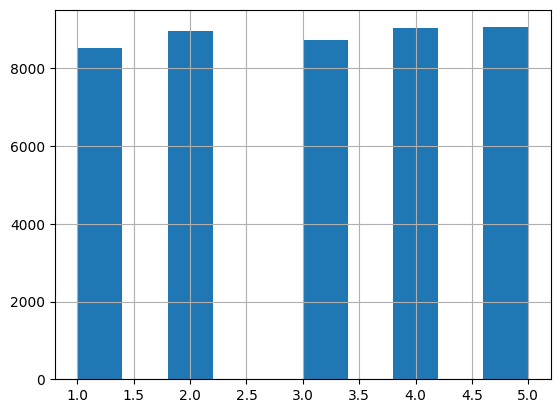

In [75]:
df1_bal['Rating'].hist()

In [76]:
Counter(df1_bal['Rating'])

Counter({4: 9039, 2: 8965, 3: 8736, 5: 9054, 1: 8526})

# **Объявление моделей**

In [4]:
# Чтение датасета из списков
class MyDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = torch.tensor(embeddings).float()
        self.targets = torch.tensor(targets).long()

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.targets[idx]

# Модель с одним скрытым слоем
class ClassifierReLU1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassifierReLU1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Модель с двумя скрытыми слоями (две функции активации)
class ClassifierReLU2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ClassifierReLU2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Модель с тремя скрытыми слоями
class ClassifierReLU3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ClassifierReLU3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc4(x)
        return x

# Сверточная нейронная сеть CNN
class CNN_Text(nn.Module):
    def __init__(self, embedding_size, num_classes, num_filters, filter_sizes):
        super(CNN_Text, self).__init__()
        self.convs = nn.ModuleList([nn.Conv1d(embedding_size, num_filters, f, padding=f-1) for f in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.transpose(1, 2)
        xs = []
        for conv in self.convs:
            x2 = conv(x)
            x2 = F.relu(x2)
            x2 = F.max_pool1d(x2, x2.size(2)).squeeze()
            xs.append(x2)
        x = torch.cat(xs, 1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Нейронка со скрытым слоем LSTM
class LSTM_text(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_text, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        logits = self.fc(output)
        return logits

# Интересный трансформер, который может переобучиться
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, num_heads, hidden_size, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding_size = input_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads) 
            for _ in range(num_layers)
        ])
        self.transformer = nn.TransformerEncoder(encoder_layer=self.transformer_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.embedding(x)
        for i in range(self.num_layers):
            x = self.transformer_layers[i](x)
        x = self.fc(x)
        return x

In [44]:
def model_training(input_model, num_epochs, learning_rate, batch_size, data, embed, target):
    model = input_model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Разделяем на тренировочную и валидационную выборки
    train_index = data.sample(int(data.shape[0]*0.8)).index
    val_index = data.index.difference(train_index)

    # Определим датасет и даталоадер для обучения
    embeddings = data.loc[train_index][f'{embed}'].to_list()  # список с эмбеддингами отзывов
    targets = data.loc[train_index][f'{target}'].to_list()  # список с таргетами (классами)
    dataset = MyDataset(embeddings, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Определим датасет и даталоадер для валидации
    val_embeddings = data.loc[val_index][f'{embed}'].to_list()  # список с эмбеддингами отзывов для валидации
    val_targets = data.loc[val_index][f'{target}'].to_list()  # список с таргетами (классами) для валидации
    val_dataset = MyDataset(val_embeddings, val_targets)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Обучение модели
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, batch_data in enumerate(dataloader, 0):
            inputs, labels = batch_data
            labels = labels - 1
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_history.append(running_loss / i)
        print('[epoch: %d] loss: %.3f' % (epoch + 1, running_loss / i))
        running_loss = 0.0

        # Вычисление метрик на валидационном датасете
        val_running_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for val_data in val_dataloader:
                val_inputs, val_labels = val_data
                val_labels = val_labels - 1
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                val_predictions += list(torch.argmax(val_outputs, dim=1).numpy())
                val_targets += list(val_labels.numpy())
            val_loss_history.append(val_running_loss / len(val_dataloader))
        
        # Вычисление метрик на валидационном датасете
            val_precision = precision_score(val_targets, val_predictions, average='macro', zero_division=True)
            val_recall = recall_score(val_targets, val_predictions, average='macro', zero_division=True)
            val_f1 = f1_score(val_targets, val_predictions, average='macro', zero_division=True)
            print('validation loss: %.3f, validation precision: %.3f, validation recall: %.3f, validation F1: %.3f' % (val_running_loss / len(val_dataloader), val_precision, val_recall, val_f1))

    # Рисуем изменение ошибки
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(num_epochs), train_loss_history, label='train')
    ax.plot(range(num_epochs), val_loss_history, label='val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    # метрики для каждого класса
    print(classification_report((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist(), zero_division=True))
    # матрица ошибок и "попаданий"
    sns.heatmap(confusion_matrix((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()), annot=True, cmap="Blues", fmt="d")
    return model

In [46]:
def testing(model, data, embed, target):
    val_embeddings = data[f'{embed}'].to_list()
    val_targets = data[f'{target}'].to_list()
    val_dataset = MyDataset(val_embeddings, val_targets)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    model = model
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for val_data in val_dataloader:
            val_inputs, val_labels = val_data
            val_labels = val_labels - 1
            val_outputs = model(val_inputs)
            val_predictions += list(torch.argmax(val_outputs, dim=1).numpy())
            val_targets += list(val_labels.numpy())
        val_precision = precision_score(val_targets, val_predictions, average='macro')
        val_recall = recall_score(val_targets, val_predictions, average='macro')
        val_f1 = f1_score(val_targets, val_predictions, average='macro')
    print('precision: %.3f, recall: %.3f, F1: %.3f' % (val_precision, val_recall, val_f1))
    print(classification_report((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()))
    sns.heatmap(confusion_matrix((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()), annot=True, cmap="Blues", fmt="d")

# **Работа с моделями на bert-tiny**

## Предобработка и вычисление эмбеддингов

In [6]:
df_low1 = pd.read_csv('/content/drive/MyDrive/cw_classifier/Hotel_EN_balanced_by_syn.csv')
df_no_bal = pd.read_json('/content/drive/MyDrive/cw_classifier/parsed.jl', lines=True)

df_low1.rename(columns={'Review': 'review', 'Rating': 'rating'}, inplace=True)
df_no_bal['rating'] = df_no_bal['rating']/10
df_no_bal.drop(['hotel', 'address', 'date'], axis=1, inplace=True)
df_no_bal.rename(columns={'content': 'review'}, inplace=True)
grouped_df = df_no_bal.groupby('rating')
dfs_by_rating = [grouped_df.get_group(x) for x in grouped_df.groups]
min_count = min([len(d) for d in dfs_by_rating])
dfs_sampled = [d.sample(min_count, random_state=42) for d in dfs_by_rating]
df_low2 = pd.concat(dfs_sampled)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model_bert_tiny = AutoModel.from_pretrained("prajjwal1/bert-tiny")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
sentences = df_low1['review'].to_list()
total_embed = []
start_time = time.time()
for i in range(0, len(sentences), 1000):
  if i+1000 > len(sentences):
    encoded_input = tokenizer(sentences[i:], padding=True, truncation=True, max_length=64, return_tensors='pt')
  else:
    encoded_input = tokenizer(sentences[i:i+1000], padding=True, truncation=True, max_length=64, return_tensors='pt')
  with torch.no_grad():
    model_output = model_bert_tiny(**encoded_input)
  embeddings = model_output.pooler_output
  embeddings = torch.nn.functional.normalize(embeddings)
  total_embed += embeddings.tolist()
df_low1['bert-tiny'] = total_embed

In [10]:
sentences = df_low2['review'].to_list()
total_embed = []
start_time = time.time()
for i in range(0, len(sentences), 1000):
  # if i % 2000 == 0:
  #   print('i =', i, '\ntime:', time.time() - start_time, '\n')
  if i+1000 > len(sentences):
    encoded_input = tokenizer(sentences[i:], padding=True, truncation=True, max_length=64, return_tensors='pt')
  else:
    encoded_input = tokenizer(sentences[i:i+1000], padding=True, truncation=True, max_length=64, return_tensors='pt')
  with torch.no_grad():
    model_output = model_bert_tiny(**encoded_input)
  embeddings = model_output.pooler_output
  embeddings = torch.nn.functional.normalize(embeddings)
  total_embed += embeddings.tolist()
df_low2['bert-tiny'] = total_embed

In [11]:
df_low1.rename(columns={'Rating': 'rating'}, inplace=True)

In [12]:
min_count

7050

## Обучение

### ReLU1

[epoch: 1] loss: 1.467
validation loss: 1.409, validation precision: 0.343, validation recall: 0.366, validation F1: 0.331
[epoch: 2] loss: 1.381
validation loss: 1.394, validation precision: 0.373, validation recall: 0.375, validation F1: 0.363
[epoch: 3] loss: 1.356
validation loss: 1.358, validation precision: 0.371, validation recall: 0.388, validation F1: 0.372
[epoch: 4] loss: 1.343
validation loss: 1.346, validation precision: 0.386, validation recall: 0.395, validation F1: 0.388
[epoch: 5] loss: 1.334
validation loss: 1.356, validation precision: 0.380, validation recall: 0.393, validation F1: 0.370
[epoch: 6] loss: 1.328
validation loss: 1.355, validation precision: 0.376, validation recall: 0.391, validation F1: 0.359
[epoch: 7] loss: 1.323
validation loss: 1.333, validation precision: 0.389, validation recall: 0.405, validation F1: 0.385
[epoch: 8] loss: 1.319
validation loss: 1.328, validation precision: 0.395, validation recall: 0.407, validation F1: 0.396
[epoch: 9] loss:

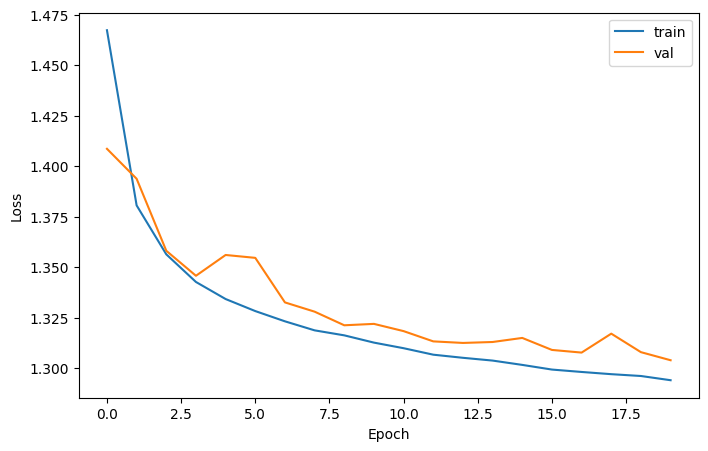

              precision    recall  f1-score   support

           1       0.48      0.68      0.56      1688
           2       0.34      0.24      0.28      1821
           3       0.35      0.27      0.31      1722
           4       0.35      0.41      0.38      1803
           5       0.51      0.51      0.51      1830

    accuracy                           0.42      8864
   macro avg       0.41      0.42      0.41      8864
weighted avg       0.41      0.42      0.41      8864



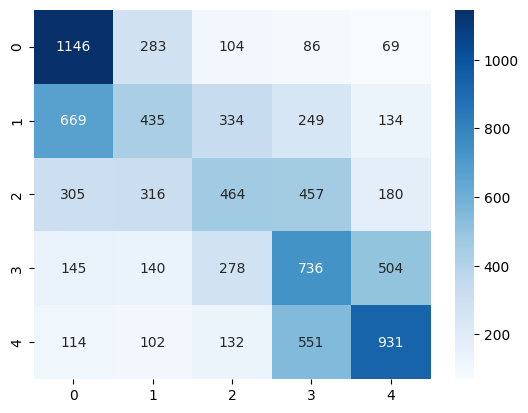

In [13]:
model_bt_1 = ClassifierReLU1(128, 64, 5)
model_bt_1 = model_training(model_bt_1, 20, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.541
validation loss: 1.490, validation precision: 0.320, validation recall: 0.337, validation F1: 0.300
[epoch: 2] loss: 1.470
validation loss: 1.468, validation precision: 0.330, validation recall: 0.346, validation F1: 0.321
[epoch: 3] loss: 1.450
validation loss: 1.454, validation precision: 0.347, validation recall: 0.362, validation F1: 0.334
[epoch: 4] loss: 1.441
validation loss: 1.442, validation precision: 0.365, validation recall: 0.367, validation F1: 0.325
[epoch: 5] loss: 1.433
validation loss: 1.456, validation precision: 0.338, validation recall: 0.353, validation F1: 0.316
[epoch: 6] loss: 1.429
validation loss: 1.434, validation precision: 0.359, validation recall: 0.374, validation F1: 0.359
[epoch: 7] loss: 1.423
validation loss: 1.431, validation precision: 0.361, validation recall: 0.372, validation F1: 0.338
[epoch: 8] loss: 1.421
validation loss: 1.432, validation precision: 0.363, validation recall: 0.366, validation F1: 0.317
[epoch: 9] loss:

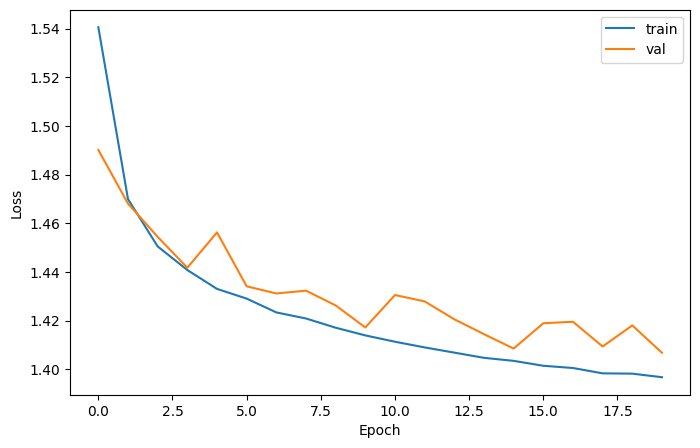

              precision    recall  f1-score   support

           1       0.44      0.55      0.49      1401
           2       0.31      0.24      0.27      1448
           3       0.34      0.19      0.24      1411
           4       0.30      0.34      0.32      1397
           5       0.44      0.60      0.51      1393

    accuracy                           0.38      7050
   macro avg       0.37      0.38      0.37      7050
weighted avg       0.37      0.38      0.37      7050



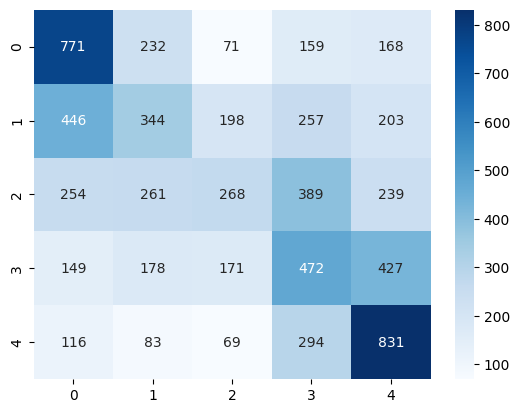

In [14]:
model_bt_2 = ClassifierReLU1(128, 64, 5)
model_bt_2 = model_training(model_bt_2, 20, 0.001, 16, df_low2, 'bert-tiny', 'rating')

### ReLU2

[epoch: 1] loss: 1.461
validation loss: 1.381, validation precision: 0.370, validation recall: 0.385, validation F1: 0.350
[epoch: 2] loss: 1.366
validation loss: 1.338, validation precision: 0.401, validation recall: 0.407, validation F1: 0.403
[epoch: 3] loss: 1.346
validation loss: 1.334, validation precision: 0.371, validation recall: 0.405, validation F1: 0.357
[epoch: 4] loss: 1.335
validation loss: 1.315, validation precision: 0.409, validation recall: 0.419, validation F1: 0.409
[epoch: 5] loss: 1.327
validation loss: 1.307, validation precision: 0.410, validation recall: 0.425, validation F1: 0.413
[epoch: 6] loss: 1.319
validation loss: 1.324, validation precision: 0.392, validation recall: 0.409, validation F1: 0.384
[epoch: 7] loss: 1.315
validation loss: 1.300, validation precision: 0.404, validation recall: 0.422, validation F1: 0.400
[epoch: 8] loss: 1.312
validation loss: 1.310, validation precision: 0.399, validation recall: 0.422, validation F1: 0.395
[epoch: 9] loss:

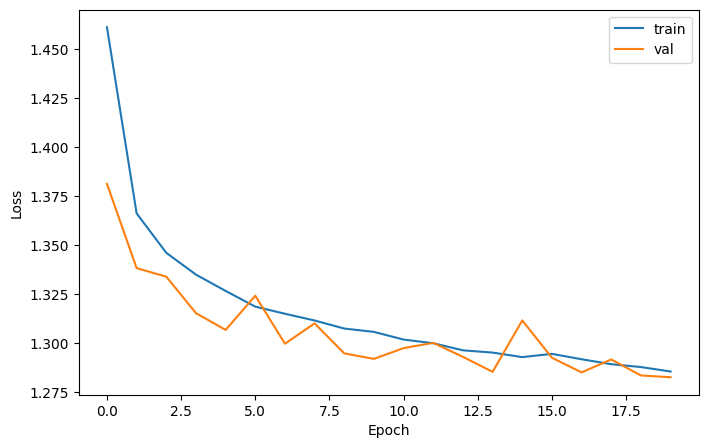

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      1698
           2       0.33      0.52      0.40      1790
           3       0.38      0.24      0.30      1798
           4       0.38      0.30      0.33      1822
           5       0.50      0.59      0.54      1756

    accuracy                           0.43      8864
   macro avg       0.44      0.43      0.42      8864
weighted avg       0.44      0.43      0.42      8864



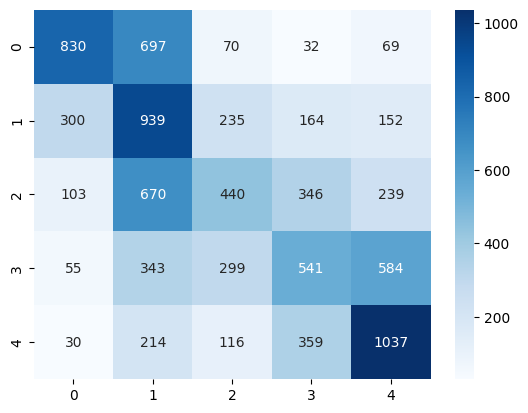

In [15]:
model_bt_3 = ClassifierReLU2(128, 64, 32, 5)
model_bt_3 = model_training(model_bt_3, 20, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.527
validation loss: 1.481, validation precision: 0.311, validation recall: 0.328, validation F1: 0.259
[epoch: 2] loss: 1.457
validation loss: 1.446, validation precision: 0.341, validation recall: 0.357, validation F1: 0.336
[epoch: 3] loss: 1.444
validation loss: 1.446, validation precision: 0.339, validation recall: 0.358, validation F1: 0.320
[epoch: 4] loss: 1.436
validation loss: 1.436, validation precision: 0.359, validation recall: 0.368, validation F1: 0.355
[epoch: 5] loss: 1.429
validation loss: 1.436, validation precision: 0.350, validation recall: 0.362, validation F1: 0.348
[epoch: 6] loss: 1.421
validation loss: 1.428, validation precision: 0.375, validation recall: 0.370, validation F1: 0.361
[epoch: 7] loss: 1.419
validation loss: 1.434, validation precision: 0.356, validation recall: 0.360, validation F1: 0.341
[epoch: 8] loss: 1.412
validation loss: 1.416, validation precision: 0.347, validation recall: 0.369, validation F1: 0.349
[epoch: 9] loss:

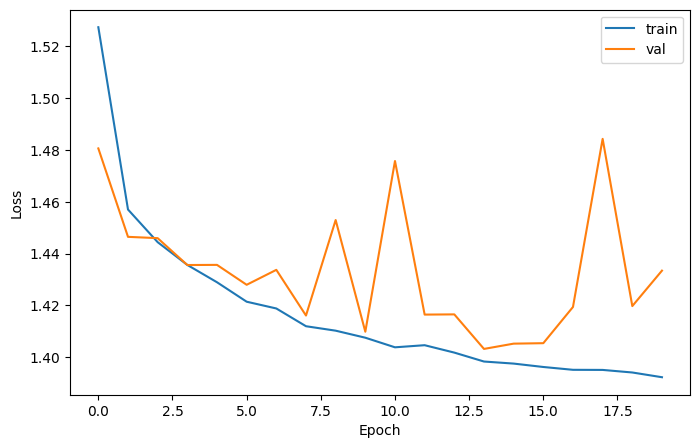

              precision    recall  f1-score   support

           1       0.33      0.78      0.46      1346
           2       0.23      0.16      0.19      1418
           3       0.31      0.21      0.25      1426
           4       0.39      0.19      0.26      1445
           5       0.56      0.46      0.51      1415

    accuracy                           0.36      7050
   macro avg       0.36      0.36      0.33      7050
weighted avg       0.37      0.36      0.33      7050



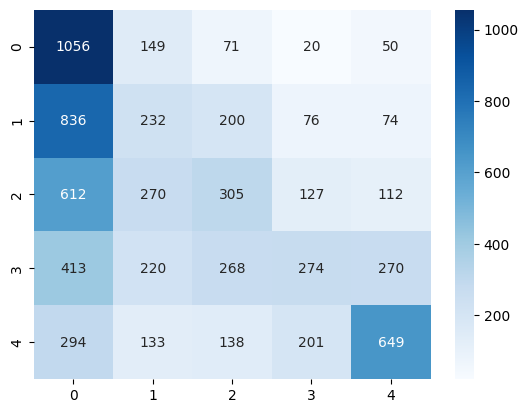

In [16]:
model_bt_4 = ClassifierReLU2(128, 64, 32, 5)
model_bt_4 = model_training(model_bt_4, 20, 0.001, 16, df_low2, 'bert-tiny', 'rating')

### ReLU3

[epoch: 1] loss: 1.443
validation loss: 1.377, validation precision: 0.378, validation recall: 0.382, validation F1: 0.370
[epoch: 2] loss: 1.364
validation loss: 1.339, validation precision: 0.401, validation recall: 0.396, validation F1: 0.394
[epoch: 3] loss: 1.344
validation loss: 1.326, validation precision: 0.393, validation recall: 0.410, validation F1: 0.393
[epoch: 4] loss: 1.334
validation loss: 1.318, validation precision: 0.397, validation recall: 0.414, validation F1: 0.399
[epoch: 5] loss: 1.327
validation loss: 1.332, validation precision: 0.433, validation recall: 0.400, validation F1: 0.400
[epoch: 6] loss: 1.322
validation loss: 1.360, validation precision: 0.387, validation recall: 0.399, validation F1: 0.371
[epoch: 7] loss: 1.318
validation loss: 1.299, validation precision: 0.413, validation recall: 0.426, validation F1: 0.415
[epoch: 8] loss: 1.314
validation loss: 1.301, validation precision: 0.397, validation recall: 0.417, validation F1: 0.395
[epoch: 9] loss:

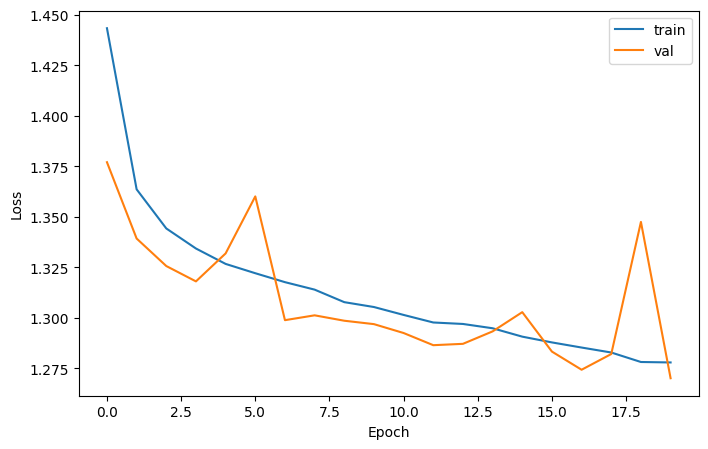

              precision    recall  f1-score   support

           1       0.59      0.60      0.60      1692
           2       0.34      0.39      0.36      1770
           3       0.40      0.23      0.30      1762
           4       0.36      0.36      0.36      1838
           5       0.50      0.61      0.55      1802

    accuracy                           0.44      8864
   macro avg       0.44      0.44      0.43      8864
weighted avg       0.43      0.44      0.43      8864



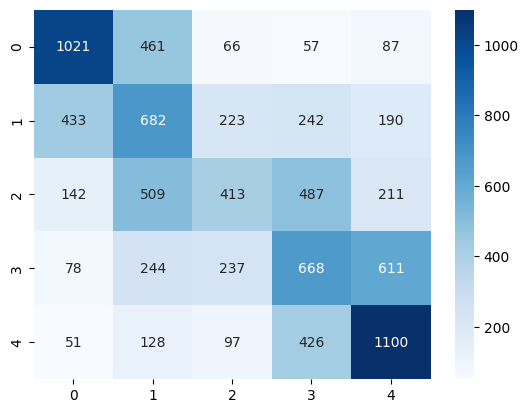

In [17]:
model_bt_5 = ClassifierReLU3(128, 64, 32, 5)
model_bt_5 = model_training(model_bt_5, 20, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.523
validation loss: 1.499, validation precision: 0.326, validation recall: 0.332, validation F1: 0.296
[epoch: 2] loss: 1.456
validation loss: 1.444, validation precision: 0.376, validation recall: 0.369, validation F1: 0.357
[epoch: 3] loss: 1.441
validation loss: 1.421, validation precision: 0.356, validation recall: 0.370, validation F1: 0.347
[epoch: 4] loss: 1.434
validation loss: 1.435, validation precision: 0.388, validation recall: 0.369, validation F1: 0.362
[epoch: 5] loss: 1.424
validation loss: 1.421, validation precision: 0.359, validation recall: 0.372, validation F1: 0.342
[epoch: 6] loss: 1.419
validation loss: 1.412, validation precision: 0.380, validation recall: 0.379, validation F1: 0.371
[epoch: 7] loss: 1.417
validation loss: 1.409, validation precision: 0.388, validation recall: 0.383, validation F1: 0.382
[epoch: 8] loss: 1.412
validation loss: 1.419, validation precision: 0.365, validation recall: 0.373, validation F1: 0.360
[epoch: 9] loss:

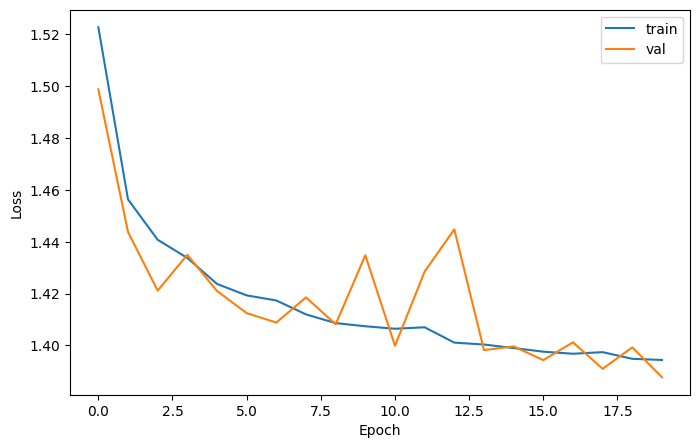

              precision    recall  f1-score   support

           1       0.41      0.60      0.49      1438
           2       0.28      0.20      0.23      1376
           3       0.36      0.21      0.27      1476
           4       0.34      0.37      0.35      1380
           5       0.49      0.59      0.54      1380

    accuracy                           0.39      7050
   macro avg       0.38      0.39      0.38      7050
weighted avg       0.38      0.39      0.38      7050



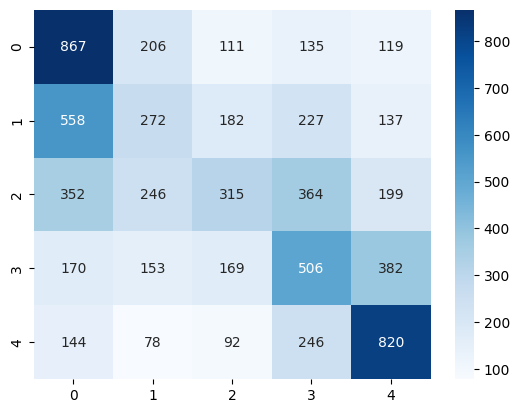

In [18]:
model_bt_6 = ClassifierReLU3(128, 64, 32, 5)
model_bt_6 = model_training(model_bt_6, 20, 0.001, 16, df_low2, 'bert-tiny', 'rating')

### CNN

[epoch: 1] loss: 1.455
validation loss: 1.401, validation precision: 0.361, validation recall: 0.377, validation F1: 0.350
[epoch: 2] loss: 1.385
validation loss: 1.367, validation precision: 0.383, validation recall: 0.386, validation F1: 0.376
[epoch: 3] loss: 1.364
validation loss: 1.353, validation precision: 0.379, validation recall: 0.393, validation F1: 0.380
[epoch: 4] loss: 1.353
validation loss: 1.362, validation precision: 0.400, validation recall: 0.394, validation F1: 0.375
[epoch: 5] loss: 1.346
validation loss: 1.341, validation precision: 0.406, validation recall: 0.402, validation F1: 0.398
[epoch: 6] loss: 1.342
validation loss: 1.336, validation precision: 0.400, validation recall: 0.404, validation F1: 0.395
[epoch: 7] loss: 1.337
validation loss: 1.329, validation precision: 0.403, validation recall: 0.412, validation F1: 0.401
[epoch: 8] loss: 1.333
validation loss: 1.326, validation precision: 0.390, validation recall: 0.408, validation F1: 0.390
[epoch: 9] loss:

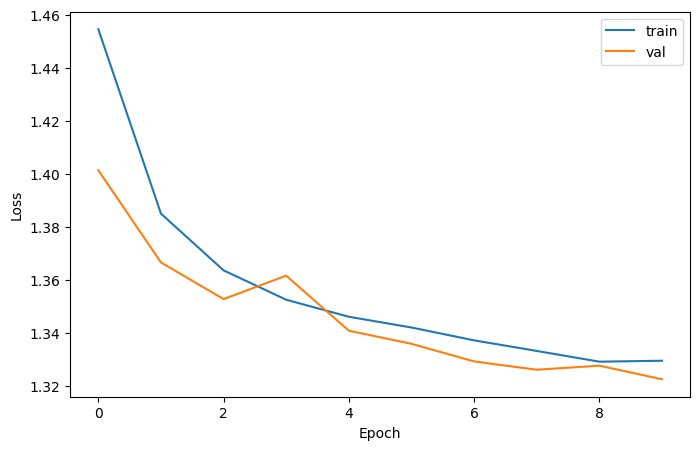

              precision    recall  f1-score   support

           1       0.48      0.71      0.57      1756
           2       0.34      0.31      0.32      1795
           3       0.37      0.21      0.27      1700
           4       0.35      0.29      0.32      1804
           5       0.48      0.58      0.52      1809

    accuracy                           0.42      8864
   macro avg       0.40      0.42      0.40      8864
weighted avg       0.40      0.42      0.40      8864



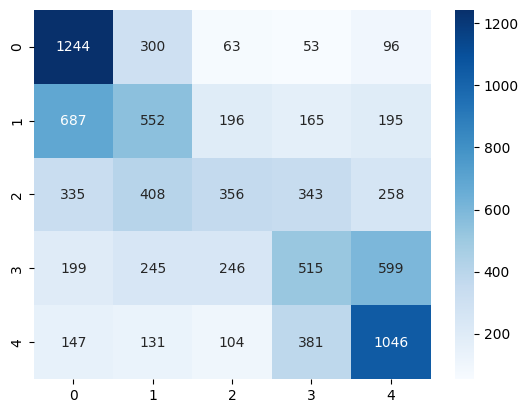

In [19]:
model_bt_7 = CNN_Text(128, 5, 100, [3, 4, 5])
model_bt_7 = model_training(model_bt_7, 10, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.547
validation loss: 1.486, validation precision: 0.322, validation recall: 0.337, validation F1: 0.316
[epoch: 2] loss: 1.484
validation loss: 1.460, validation precision: 0.324, validation recall: 0.350, validation F1: 0.309
[epoch: 3] loss: 1.465
validation loss: 1.452, validation precision: 0.345, validation recall: 0.350, validation F1: 0.327
[epoch: 4] loss: 1.453
validation loss: 1.439, validation precision: 0.355, validation recall: 0.366, validation F1: 0.353
[epoch: 5] loss: 1.446
validation loss: 1.428, validation precision: 0.356, validation recall: 0.372, validation F1: 0.355
[epoch: 6] loss: 1.441
validation loss: 1.439, validation precision: 0.346, validation recall: 0.361, validation F1: 0.316
[epoch: 7] loss: 1.435
validation loss: 1.424, validation precision: 0.355, validation recall: 0.367, validation F1: 0.355
[epoch: 8] loss: 1.432
validation loss: 1.434, validation precision: 0.354, validation recall: 0.356, validation F1: 0.328
[epoch: 9] loss:

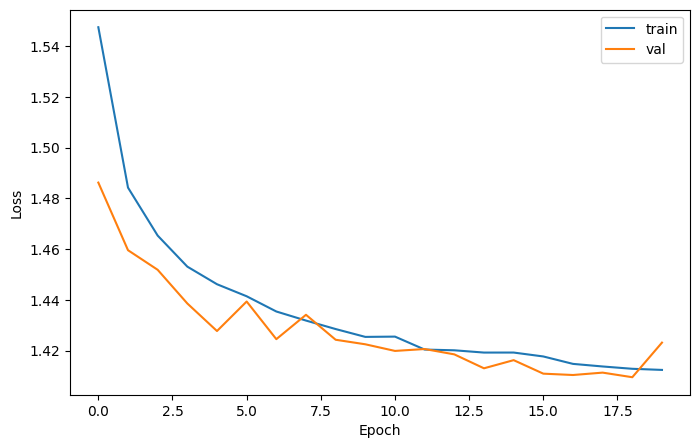

              precision    recall  f1-score   support

           1       0.43      0.48      0.45      1395
           2       0.28      0.16      0.21      1379
           3       0.33      0.21      0.26      1432
           4       0.30      0.35      0.32      1430
           5       0.43      0.64      0.51      1414

    accuracy                           0.37      7050
   macro avg       0.35      0.37      0.35      7050
weighted avg       0.35      0.37      0.35      7050



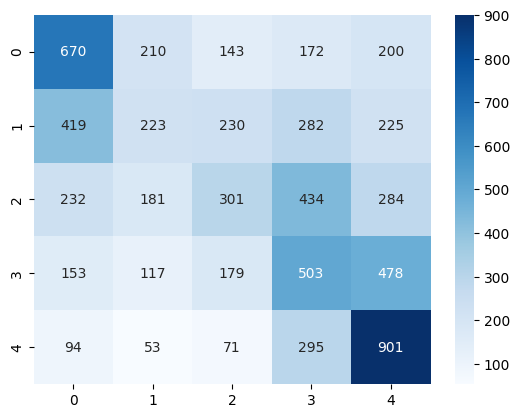

In [20]:
model_bt_8 = CNN_Text(128, 5, 100, [3, 4, 5])
model_bt_8 = model_training(model_bt_8, 20, 0.001, 32, df_low2, 'bert-tiny', 'rating')

### LSTM 1

[epoch: 1] loss: 1.460
validation loss: 1.423, validation precision: 0.353, validation recall: 0.366, validation F1: 0.322
[epoch: 2] loss: 1.368
validation loss: 1.369, validation precision: 0.375, validation recall: 0.394, validation F1: 0.377
[epoch: 3] loss: 1.346
validation loss: 1.364, validation precision: 0.390, validation recall: 0.398, validation F1: 0.386
[epoch: 4] loss: 1.335
validation loss: 1.361, validation precision: 0.388, validation recall: 0.400, validation F1: 0.385
[epoch: 5] loss: 1.329
validation loss: 1.362, validation precision: 0.387, validation recall: 0.398, validation F1: 0.386
[epoch: 6] loss: 1.324
validation loss: 1.332, validation precision: 0.398, validation recall: 0.408, validation F1: 0.401
[epoch: 7] loss: 1.320
validation loss: 1.345, validation precision: 0.401, validation recall: 0.406, validation F1: 0.402
[epoch: 8] loss: 1.316
validation loss: 1.347, validation precision: 0.387, validation recall: 0.402, validation F1: 0.380
[epoch: 9] loss:

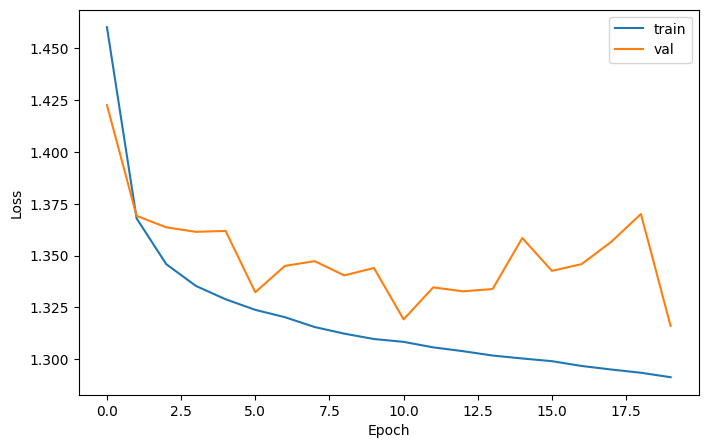

              precision    recall  f1-score   support

           1       0.51      0.62      0.56      1699
           2       0.34      0.35      0.34      1829
           3       0.35      0.21      0.26      1721
           4       0.37      0.27      0.31      1861
           5       0.45      0.65      0.53      1754

    accuracy                           0.42      8864
   macro avg       0.40      0.42      0.40      8864
weighted avg       0.40      0.42      0.40      8864



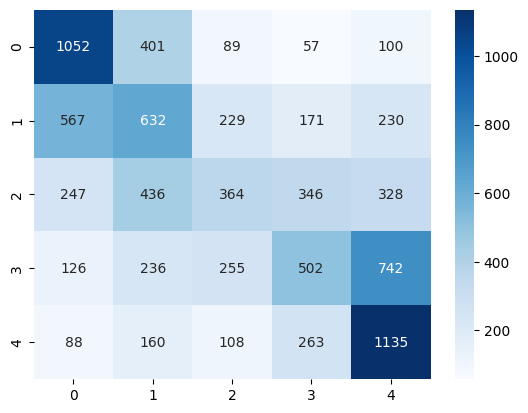

In [21]:
model_bt_9 = LSTM_text(128, 64, 1, 5)
model_bt_9 = model_training(model_bt_9, 20, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.539
validation loss: 1.461, validation precision: 0.334, validation recall: 0.346, validation F1: 0.336
[epoch: 2] loss: 1.467
validation loss: 1.438, validation precision: 0.353, validation recall: 0.359, validation F1: 0.340
[epoch: 3] loss: 1.450
validation loss: 1.434, validation precision: 0.369, validation recall: 0.378, validation F1: 0.358
[epoch: 4] loss: 1.443
validation loss: 1.428, validation precision: 0.354, validation recall: 0.372, validation F1: 0.335
[epoch: 5] loss: 1.436
validation loss: 1.416, validation precision: 0.365, validation recall: 0.375, validation F1: 0.365
[epoch: 6] loss: 1.433
validation loss: 1.426, validation precision: 0.368, validation recall: 0.374, validation F1: 0.363
[epoch: 7] loss: 1.429
validation loss: 1.409, validation precision: 0.372, validation recall: 0.380, validation F1: 0.372
[epoch: 8] loss: 1.425
validation loss: 1.416, validation precision: 0.364, validation recall: 0.379, validation F1: 0.353
[epoch: 9] loss:

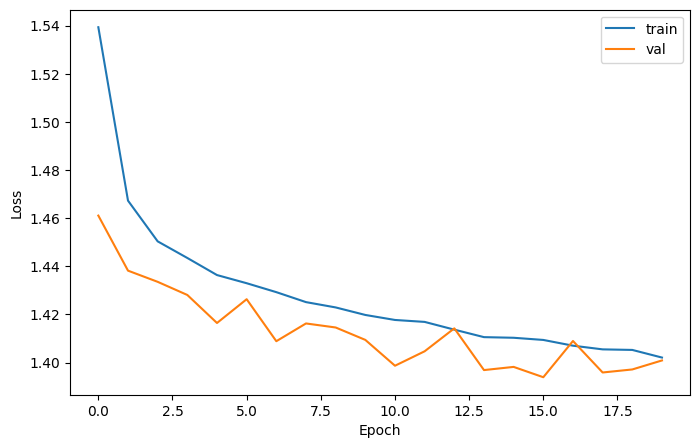

              precision    recall  f1-score   support

           1       0.38      0.67      0.49      1407
           2       0.27      0.25      0.26      1422
           3       0.34      0.21      0.26      1414
           4       0.35      0.21      0.26      1387
           5       0.51      0.57      0.54      1420

    accuracy                           0.38      7050
   macro avg       0.37      0.38      0.36      7050
weighted avg       0.37      0.38      0.36      7050



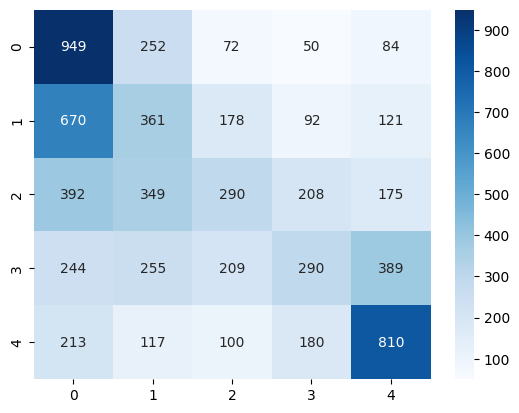

In [22]:
model_bt_10 = LSTM_text(128, 64, 1, 5)
model_bt_10 = model_training(model_bt_10, 20, 0.001, 16, df_low2, 'bert-tiny', 'rating')

### LSTM 2

[epoch: 1] loss: 1.457
validation loss: 1.386, validation precision: 0.383, validation recall: 0.365, validation F1: 0.369
[epoch: 2] loss: 1.359
validation loss: 1.381, validation precision: 0.374, validation recall: 0.380, validation F1: 0.377
[epoch: 3] loss: 1.341
validation loss: 1.408, validation precision: 0.394, validation recall: 0.372, validation F1: 0.369
[epoch: 4] loss: 1.332
validation loss: 1.346, validation precision: 0.393, validation recall: 0.399, validation F1: 0.392
[epoch: 5] loss: 1.323
validation loss: 1.332, validation precision: 0.399, validation recall: 0.408, validation F1: 0.400
[epoch: 6] loss: 1.319
validation loss: 1.364, validation precision: 0.393, validation recall: 0.391, validation F1: 0.388
[epoch: 7] loss: 1.313
validation loss: 1.341, validation precision: 0.383, validation recall: 0.400, validation F1: 0.380
[epoch: 8] loss: 1.310
validation loss: 1.360, validation precision: 0.382, validation recall: 0.397, validation F1: 0.380
[epoch: 9] loss:

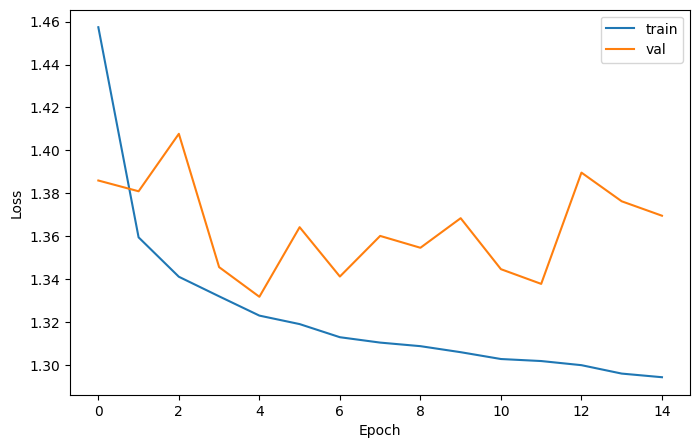

              precision    recall  f1-score   support

           1       0.55      0.35      0.43      1738
           2       0.32      0.36      0.33      1719
           3       0.32      0.26      0.29      1755
           4       0.31      0.25      0.27      1811
           5       0.44      0.71      0.54      1841

    accuracy                           0.39      8864
   macro avg       0.39      0.38      0.37      8864
weighted avg       0.39      0.39      0.37      8864



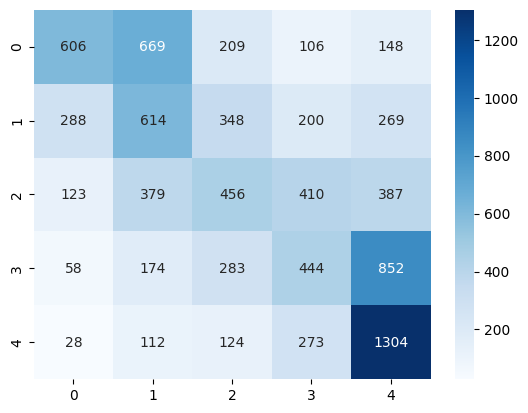

In [23]:
model_bt_11 = LSTM_text(128, 64, 2, 5)
model_bt_11 = model_training(model_bt_11, 15, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.550
validation loss: 1.498, validation precision: 0.308, validation recall: 0.317, validation F1: 0.243
[epoch: 2] loss: 1.459
validation loss: 1.453, validation precision: 0.344, validation recall: 0.361, validation F1: 0.338
[epoch: 3] loss: 1.434
validation loss: 1.454, validation precision: 0.332, validation recall: 0.353, validation F1: 0.325
[epoch: 4] loss: 1.426
validation loss: 1.446, validation precision: 0.362, validation recall: 0.362, validation F1: 0.337
[epoch: 5] loss: 1.420
validation loss: 1.439, validation precision: 0.351, validation recall: 0.362, validation F1: 0.341
[epoch: 6] loss: 1.416
validation loss: 1.454, validation precision: 0.360, validation recall: 0.351, validation F1: 0.348
[epoch: 7] loss: 1.413
validation loss: 1.462, validation precision: 0.352, validation recall: 0.356, validation F1: 0.318
[epoch: 8] loss: 1.410
validation loss: 1.433, validation precision: 0.350, validation recall: 0.369, validation F1: 0.340
[epoch: 9] loss:

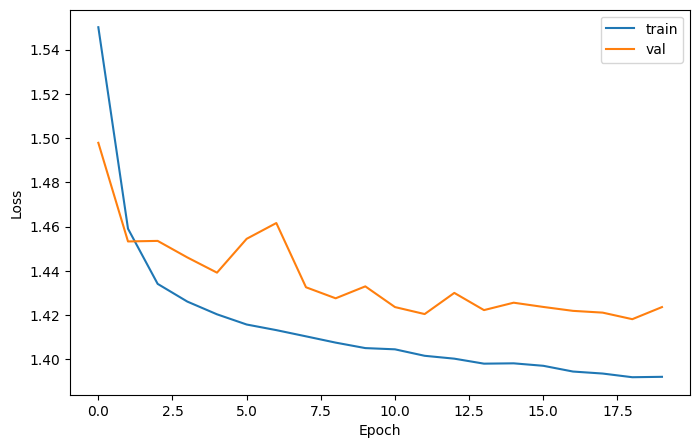

              precision    recall  f1-score   support

           1       0.42      0.48      0.45      1426
           2       0.32      0.27      0.29      1451
           3       0.32      0.28      0.30      1392
           4       0.34      0.27      0.30      1410
           5       0.45      0.60      0.51      1371

    accuracy                           0.38      7050
   macro avg       0.37      0.38      0.37      7050
weighted avg       0.37      0.38      0.37      7050



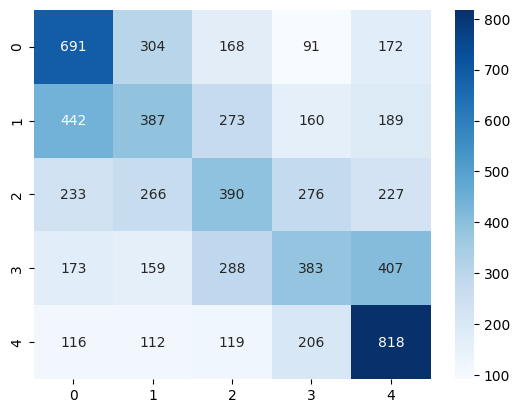

In [24]:
model_bt_12 = LSTM_text(128, 64, 2, 5)
model_bt_12 = model_training(model_bt_12, 20, 0.001, 16, df_low2, 'bert-tiny', 'rating')

### Transformer

[epoch: 1] loss: 1.438
validation loss: 1.620, validation precision: 0.277, validation recall: 0.272, validation F1: 0.232
[epoch: 2] loss: 1.365
validation loss: 1.668, validation precision: 0.277, validation recall: 0.292, validation F1: 0.263
[epoch: 3] loss: 1.352
validation loss: 1.595, validation precision: 0.292, validation recall: 0.294, validation F1: 0.270
[epoch: 4] loss: 1.341
validation loss: 1.565, validation precision: 0.303, validation recall: 0.305, validation F1: 0.293
[epoch: 5] loss: 1.335
validation loss: 1.486, validation precision: 0.324, validation recall: 0.324, validation F1: 0.304
[epoch: 6] loss: 1.328
validation loss: 1.495, validation precision: 0.327, validation recall: 0.323, validation F1: 0.312
[epoch: 7] loss: 1.323
validation loss: 1.550, validation precision: 0.309, validation recall: 0.317, validation F1: 0.302
[epoch: 8] loss: 1.321
validation loss: 1.493, validation precision: 0.336, validation recall: 0.318, validation F1: 0.320
[epoch: 9] loss:

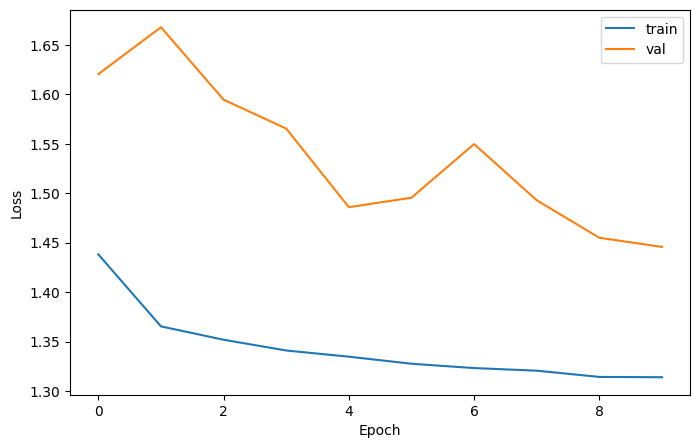

              precision    recall  f1-score   support

           1       0.41      0.54      0.46      1703
           2       0.30      0.15      0.20      1821
           3       0.27      0.32      0.29      1755
           4       0.33      0.24      0.27      1800
           5       0.42      0.53      0.47      1785

    accuracy                           0.35      8864
   macro avg       0.34      0.36      0.34      8864
weighted avg       0.34      0.35      0.34      8864



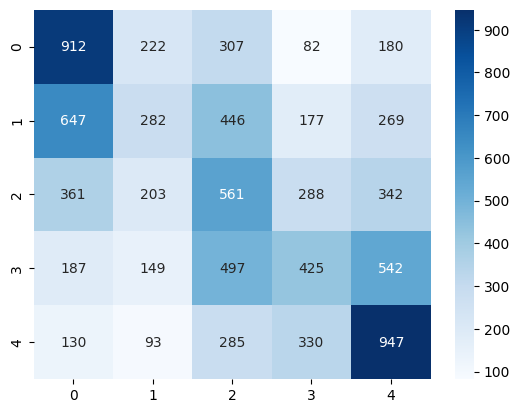

In [25]:
model_bt_13 = TransformerClassifier(128, 5, 2, 8, 64, dropout=0.1)
model_bt_13 = model_training(model_bt_13, 10, 0.001, 16, df_low1, 'bert-tiny', 'rating')

[epoch: 1] loss: 1.535
validation loss: 1.479, validation precision: 0.350, validation recall: 0.340, validation F1: 0.287
[epoch: 2] loss: 1.457
validation loss: 1.452, validation precision: 0.345, validation recall: 0.358, validation F1: 0.337
[epoch: 3] loss: 1.444
validation loss: 1.452, validation precision: 0.349, validation recall: 0.357, validation F1: 0.341
[epoch: 4] loss: 1.438
validation loss: 1.448, validation precision: 0.349, validation recall: 0.362, validation F1: 0.347
[epoch: 5] loss: 1.434
validation loss: 1.451, validation precision: 0.331, validation recall: 0.357, validation F1: 0.308
[epoch: 6] loss: 1.430
validation loss: 1.505, validation precision: 0.337, validation recall: 0.350, validation F1: 0.330
[epoch: 7] loss: 1.428
validation loss: 1.438, validation precision: 0.351, validation recall: 0.364, validation F1: 0.343
[epoch: 8] loss: 1.422
validation loss: 1.435, validation precision: 0.355, validation recall: 0.365, validation F1: 0.356
[epoch: 9] loss:

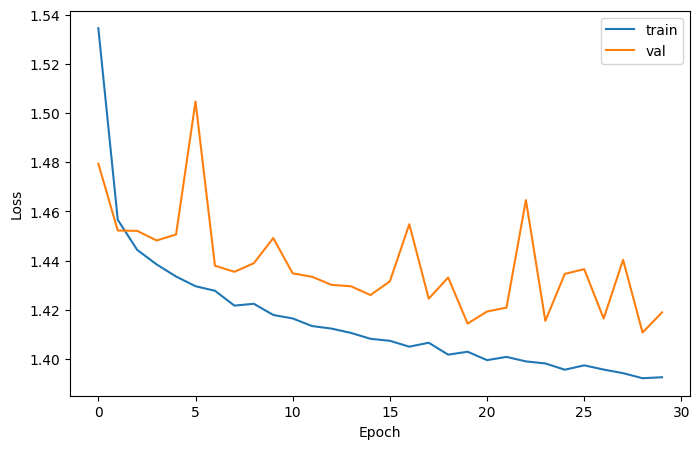

              precision    recall  f1-score   support

           1       0.41      0.64      0.50      1409
           2       0.30      0.14      0.19      1437
           3       0.32      0.24      0.28      1414
           4       0.33      0.23      0.27      1392
           5       0.43      0.65      0.52      1398

    accuracy                           0.38      7050
   macro avg       0.36      0.38      0.35      7050
weighted avg       0.36      0.38      0.35      7050



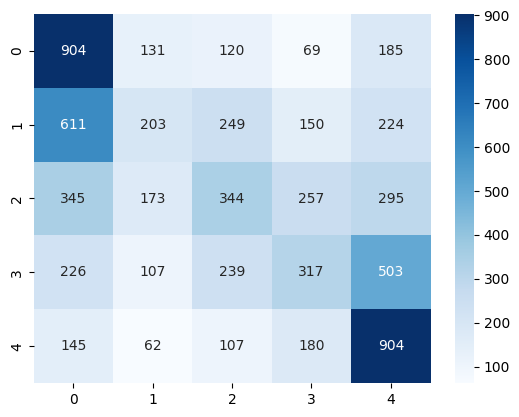

In [26]:
model_bt_14 = TransformerClassifier(128, 5, 2, 8, 64, dropout=0.1)
model_bt_14 = model_training(model_bt_14, 30, 0.001, 16, df_low2, 'bert-tiny', 'rating')

## Сравнение 1

precision: 0.316, recall: 0.262, F1: 0.192
              precision    recall  f1-score   support

           1       0.25      0.92      0.39      7050
           2       0.18      0.06      0.09      7050
           3       0.25      0.16      0.20      7050
           4       0.35      0.04      0.07      7050
           5       0.54      0.13      0.21      7050

    accuracy                           0.26     35250
   macro avg       0.32      0.26      0.19     35250
weighted avg       0.32      0.26      0.19     35250



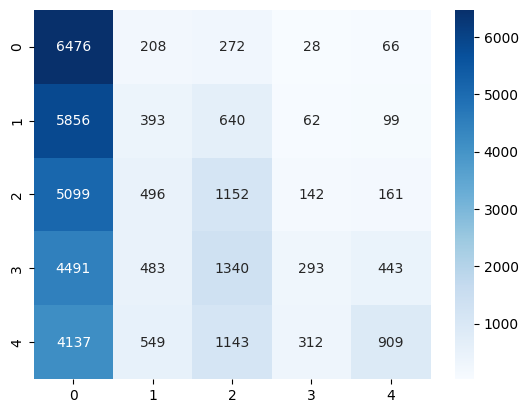

In [57]:
testing(model_bt_1, df_low2, 'bert-tiny', 'rating')

precision: 0.323, recall: 0.306, F1: 0.277
              precision    recall  f1-score   support

           1       0.35      0.66      0.46      7050
           2       0.22      0.36      0.28      7050
           3       0.24      0.18      0.21      7050
           4       0.33      0.06      0.10      7050
           5       0.47      0.26      0.34      7050

    accuracy                           0.31     35250
   macro avg       0.32      0.31      0.28     35250
weighted avg       0.32      0.31      0.28     35250



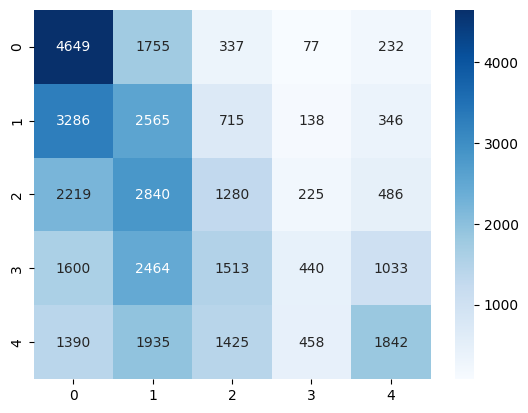

In [58]:
testing(model_bt_3, df_low2, 'bert-tiny', 'rating')

precision: 0.312, recall: 0.311, F1: 0.278
              precision    recall  f1-score   support

           1       0.35      0.65      0.45      7050
           2       0.21      0.34      0.26      7050
           3       0.29      0.14      0.19      7050
           4       0.29      0.05      0.09      7050
           5       0.42      0.38      0.40      7050

    accuracy                           0.31     35250
   macro avg       0.31      0.31      0.28     35250
weighted avg       0.31      0.31      0.28     35250



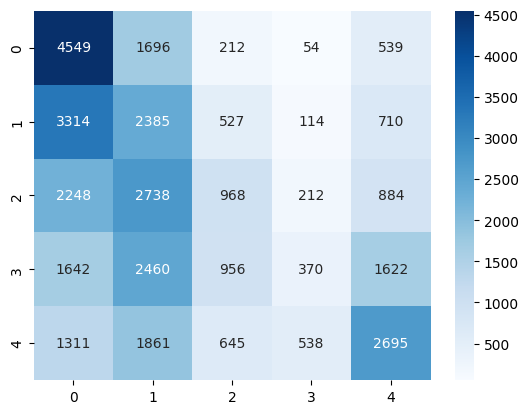

In [59]:
testing(model_bt_5, df_low2, 'bert-tiny', 'rating')

precision: 0.303, recall: 0.246, F1: 0.171
              precision    recall  f1-score   support

           1       0.24      0.90      0.38      7050
           2       0.17      0.13      0.15      7050
           3       0.24      0.05      0.08      7050
           4       0.30      0.02      0.04      7050
           5       0.56      0.12      0.20      7050

    accuracy                           0.25     35250
   macro avg       0.30      0.25      0.17     35250
weighted avg       0.30      0.25      0.17     35250



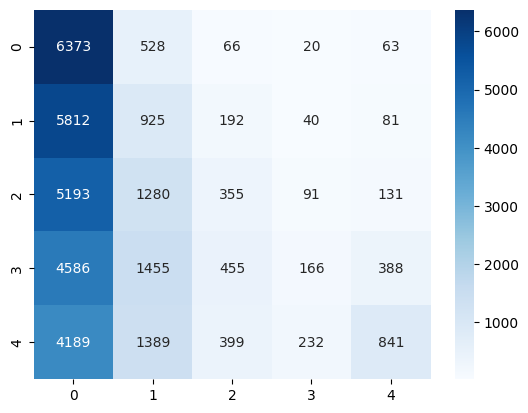

In [60]:
testing(model_bt_7, df_low2, 'bert-tiny', 'rating')

precision: 0.325, recall: 0.263, F1: 0.205
              precision    recall  f1-score   support

           1       0.31      0.74      0.44      7050
           2       0.18      0.36      0.24      7050
           3       0.24      0.08      0.12      7050
           4       0.34      0.03      0.05      7050
           5       0.55      0.10      0.17      7050

    accuracy                           0.26     35250
   macro avg       0.33      0.26      0.21     35250
weighted avg       0.33      0.26      0.21     35250



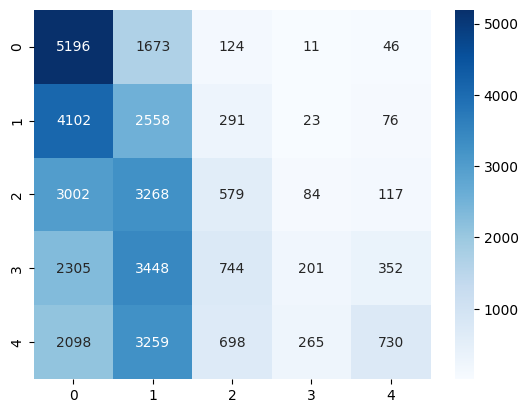

In [61]:
testing(model_bt_9, df_low2, 'bert-tiny', 'rating')

precision: 0.305, recall: 0.289, F1: 0.270
              precision    recall  f1-score   support

           1       0.34      0.47      0.39      7050
           2       0.22      0.43      0.29      7050
           3       0.24      0.18      0.21      7050
           4       0.31      0.07      0.11      7050
           5       0.42      0.30      0.35      7050

    accuracy                           0.29     35250
   macro avg       0.30      0.29      0.27     35250
weighted avg       0.30      0.29      0.27     35250



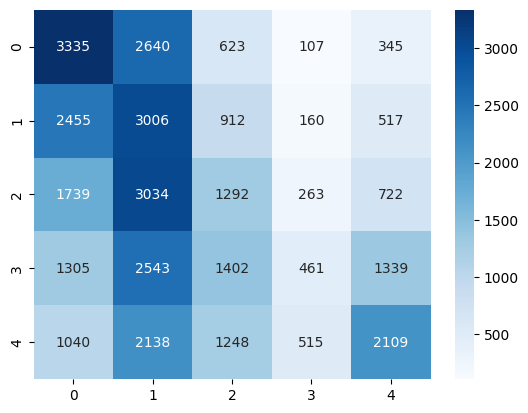

In [62]:
testing(model_bt_11, df_low2, 'bert-tiny', 'rating')

precision: 0.249, recall: 0.242, F1: 0.206
              precision    recall  f1-score   support

           1       0.25      0.63      0.36      7050
           2       0.21      0.17      0.19      7050
           3       0.21      0.19      0.20      7050
           4       0.28      0.03      0.06      7050
           5       0.30      0.18      0.23      7050

    accuracy                           0.24     35250
   macro avg       0.25      0.24      0.21     35250
weighted avg       0.25      0.24      0.21     35250



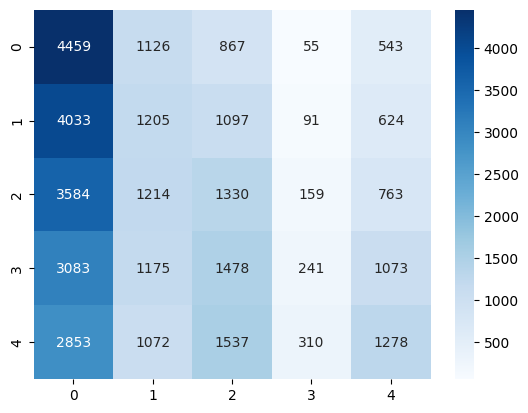

In [63]:
testing(model_bt_13, df_low2, 'bert-tiny', 'rating')

## Сравнение 2

precision: 0.353, recall: 0.369, F1: 0.344
              precision    recall  f1-score   support

           1       0.44      0.64      0.52      8526
           2       0.30      0.13      0.18      8965
           3       0.32      0.18      0.23      8736
           4       0.31      0.40      0.35      9039
           5       0.39      0.50      0.44      9054

    accuracy                           0.37     44320
   macro avg       0.35      0.37      0.34     44320
weighted avg       0.35      0.37      0.34     44320



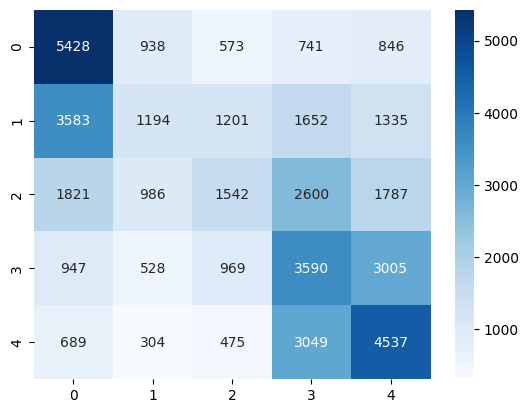

In [64]:
testing(model_bt_2, df_low1, 'bert-tiny', 'rating')

precision: 0.347, recall: 0.360, F1: 0.334
              precision    recall  f1-score   support

           1       0.42      0.69      0.53      8526
           2       0.29      0.19      0.23      8965
           3       0.27      0.37      0.31      8736
           4       0.34      0.13      0.19      9039
           5       0.42      0.41      0.41      9054

    accuracy                           0.36     44320
   macro avg       0.35      0.36      0.33     44320
weighted avg       0.35      0.36      0.33     44320



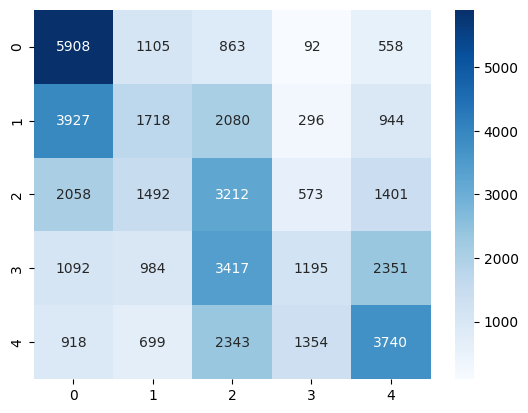

In [65]:
testing(model_bt_4, df_low1, 'bert-tiny', 'rating')

precision: 0.355, recall: 0.365, F1: 0.352
              precision    recall  f1-score   support

           1       0.43      0.67      0.52      8526
           2       0.27      0.20      0.23      8965
           3       0.29      0.32      0.31      8736
           4       0.33      0.27      0.30      9039
           5       0.45      0.36      0.40      9054

    accuracy                           0.36     44320
   macro avg       0.35      0.36      0.35     44320
weighted avg       0.35      0.36      0.35     44320



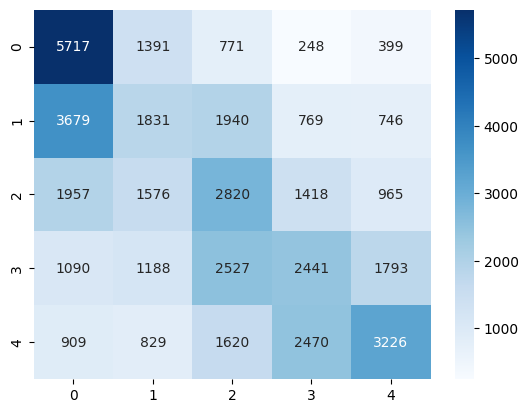

In [66]:
testing(model_bt_6, df_low1, 'bert-tiny', 'rating')

precision: 0.345, recall: 0.356, F1: 0.334
              precision    recall  f1-score   support

           1       0.45      0.55      0.50      8526
           2       0.31      0.12      0.17      8965
           3       0.27      0.39      0.32      8736
           4       0.31      0.19      0.24      9039
           5       0.38      0.53      0.44      9054

    accuracy                           0.35     44320
   macro avg       0.35      0.36      0.33     44320
weighted avg       0.34      0.35      0.33     44320



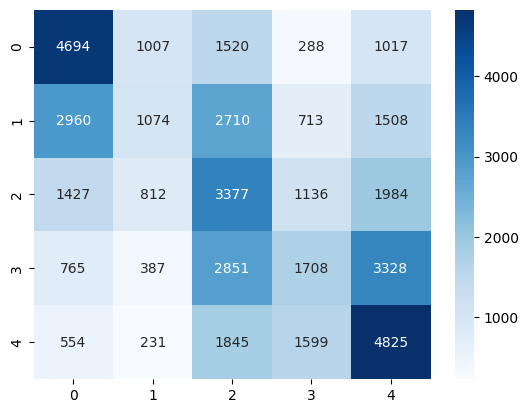

In [67]:
testing(model_bt_8, df_low1, 'bert-tiny', 'rating')

precision: 0.336, recall: 0.341, F1: 0.310
              precision    recall  f1-score   support

           1       0.40      0.64      0.50      8526
           2       0.26      0.27      0.26      8965
           3       0.25      0.34      0.29      8736
           4       0.34      0.05      0.08      9039
           5       0.43      0.41      0.42      9054

    accuracy                           0.34     44320
   macro avg       0.34      0.34      0.31     44320
weighted avg       0.34      0.34      0.31     44320



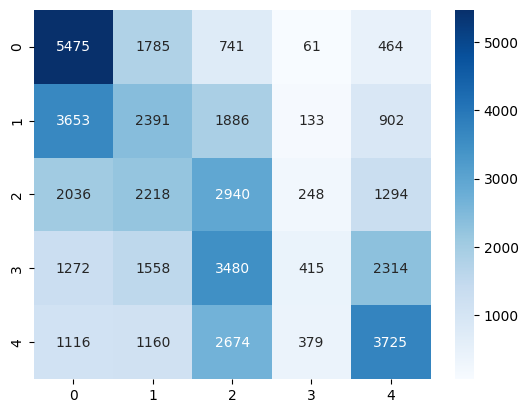

In [68]:
testing(model_bt_10, df_low1, 'bert-tiny', 'rating')

precision: 0.334, recall: 0.328, F1: 0.328
              precision    recall  f1-score   support

           1       0.43      0.36      0.39      8526
           2       0.28      0.26      0.27      8965
           3       0.27      0.38      0.32      8736
           4       0.31      0.26      0.28      9039
           5       0.38      0.38      0.38      9054

    accuracy                           0.33     44320
   macro avg       0.33      0.33      0.33     44320
weighted avg       0.33      0.33      0.33     44320



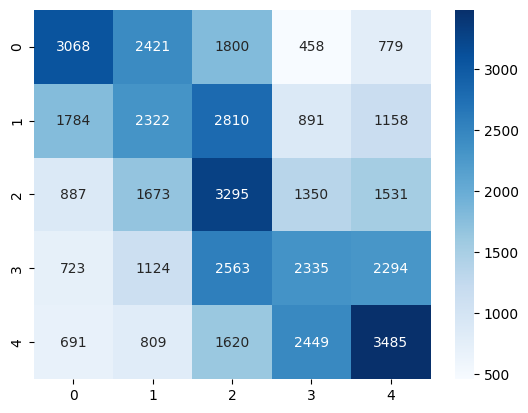

In [69]:
testing(model_bt_12, df_low1, 'bert-tiny', 'rating')

precision: 0.278, recall: 0.298, F1: 0.270
              precision    recall  f1-score   support

           1       0.32      0.49      0.39      8526
           2       0.23      0.09      0.12      8965
           3       0.24      0.22      0.23      8736
           4       0.26      0.16      0.20      9039
           5       0.34      0.54      0.42      9054

    accuracy                           0.30     44320
   macro avg       0.28      0.30      0.27     44320
weighted avg       0.28      0.30      0.27     44320



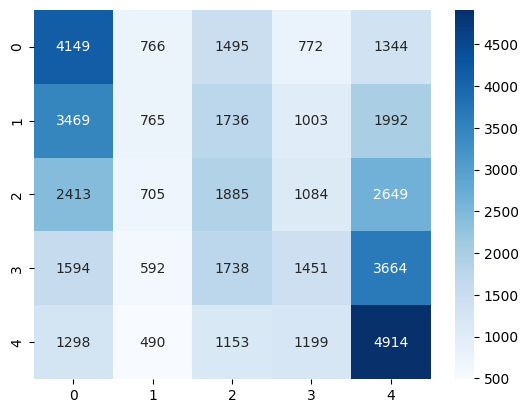

In [70]:
testing(model_bt_14, df_low1, 'bert-tiny', 'rating')

# **Обучение и тестирование моделей на LaBASE**

### Обучение ReLU1

<ipython-input-11-6474ae415547>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.embeddings = torch.tensor(embeddings).float()


[epoch: 1] loss: 1.099
validation loss: 1.066, validation precision: 0.517, validation recall: 0.533, validation F1: 0.510
[epoch: 2] loss: 1.026
validation loss: 1.021, validation precision: 0.552, validation recall: 0.557, validation F1: 0.552
[epoch: 3] loss: 0.984
validation loss: 1.006, validation precision: 0.581, validation recall: 0.560, validation F1: 0.566
[epoch: 4] loss: 0.931
validation loss: 0.951, validation precision: 0.598, validation recall: 0.593, validation F1: 0.589
[epoch: 5] loss: 0.871
validation loss: 0.938, validation precision: 0.603, validation recall: 0.596, validation F1: 0.579
[epoch: 6] loss: 0.809
validation loss: 0.859, validation precision: 0.636, validation recall: 0.642, validation F1: 0.637
[epoch: 7] loss: 0.746
validation loss: 0.836, validation precision: 0.664, validation recall: 0.646, validation F1: 0.652
[epoch: 8] loss: 0.689
validation loss: 0.778, validation precision: 0.675, validation recall: 0.679, validation F1: 0.676
[epoch: 9] loss:

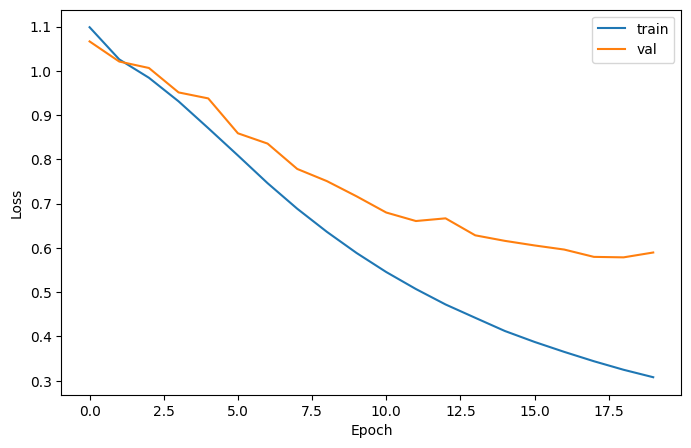

              precision    recall  f1-score   support

           1       0.95      0.92      0.94      1678
           2       0.83      0.93      0.87      1886
           3       0.76      0.84      0.80      1737
           4       0.64      0.51      0.57      1811
           5       0.68      0.68      0.68      1752

    accuracy                           0.78      8864
   macro avg       0.77      0.78      0.77      8864
weighted avg       0.77      0.78      0.77      8864



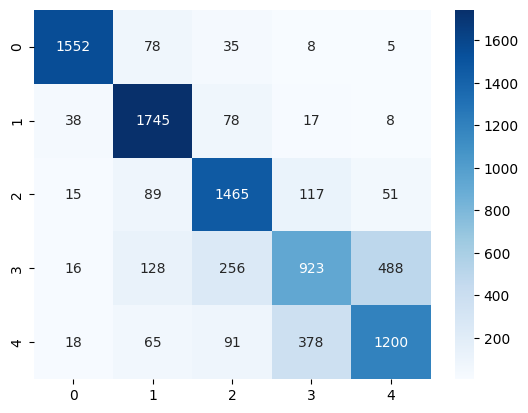

In [ ]:
Model_1 = ClassifierReLU1(768, 256, 5)
Model_1 = model_training(Model_1, 20, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.229
validation loss: 1.194, validation precision: 0.453, validation recall: 0.470, validation F1: 0.455
[epoch: 2] loss: 1.174
validation loss: 1.188, validation precision: 0.455, validation recall: 0.470, validation F1: 0.452
[epoch: 3] loss: 1.155
validation loss: 1.178, validation precision: 0.471, validation recall: 0.477, validation F1: 0.472
[epoch: 4] loss: 1.137
validation loss: 1.188, validation precision: 0.478, validation recall: 0.478, validation F1: 0.468
[epoch: 5] loss: 1.118
validation loss: 1.178, validation precision: 0.463, validation recall: 0.474, validation F1: 0.463
[epoch: 6] loss: 1.097
validation loss: 1.181, validation precision: 0.478, validation recall: 0.479, validation F1: 0.478
[epoch: 7] loss: 1.075
validation loss: 1.178, validation precision: 0.466, validation recall: 0.475, validation F1: 0.469
[epoch: 8] loss: 1.051
validation loss: 1.182, validation precision: 0.470, validation recall: 0.474, validation F1: 0.471
[epoch: 9] loss:

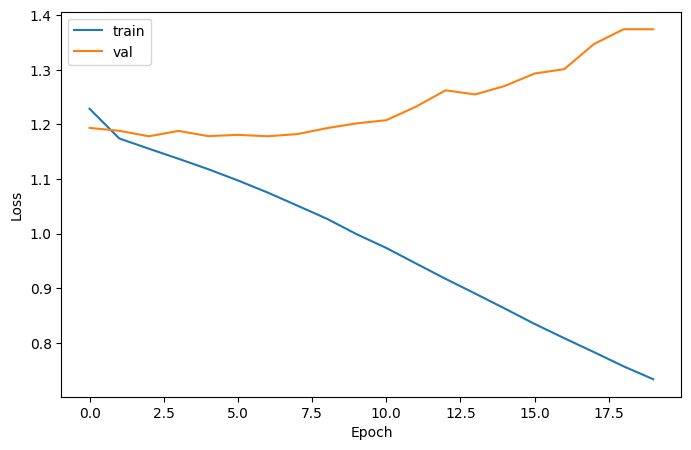

              precision    recall  f1-score   support

           1       0.54      0.58      0.56      1400
           2       0.34      0.28      0.31      1434
           3       0.35      0.40      0.37      1437
           4       0.37      0.33      0.35      1332
           5       0.57      0.62      0.60      1447

    accuracy                           0.44      7050
   macro avg       0.44      0.44      0.44      7050
weighted avg       0.44      0.44      0.44      7050



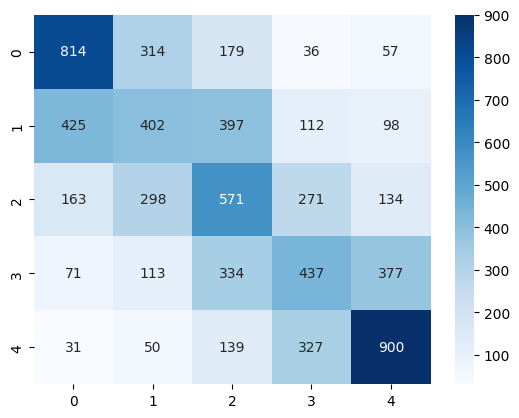

In [ ]:
Model_2 = ClassifierReLU1(768, 256, 5)
# model_training(input_model, num_epochs, learning_rate, batch_size, data, embed, target)
Model_2 = model_training(Model_2, 20, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Обучение ReLU2

[epoch: 1] loss: 1.098
validation loss: 1.069, validation precision: 0.539, validation recall: 0.531, validation F1: 0.529
[epoch: 2] loss: 1.019
validation loss: 1.021, validation precision: 0.549, validation recall: 0.558, validation F1: 0.542
[epoch: 3] loss: 0.951
validation loss: 0.964, validation precision: 0.577, validation recall: 0.587, validation F1: 0.570
[epoch: 4] loss: 0.849
validation loss: 0.877, validation precision: 0.627, validation recall: 0.631, validation F1: 0.625
[epoch: 5] loss: 0.730
validation loss: 0.792, validation precision: 0.656, validation recall: 0.669, validation F1: 0.660
[epoch: 6] loss: 0.622
validation loss: 0.713, validation precision: 0.711, validation recall: 0.712, validation F1: 0.710
[epoch: 7] loss: 0.536
validation loss: 0.663, validation precision: 0.726, validation recall: 0.730, validation F1: 0.727
[epoch: 8] loss: 0.469
validation loss: 0.626, validation precision: 0.744, validation recall: 0.748, validation F1: 0.745
[epoch: 9] loss:

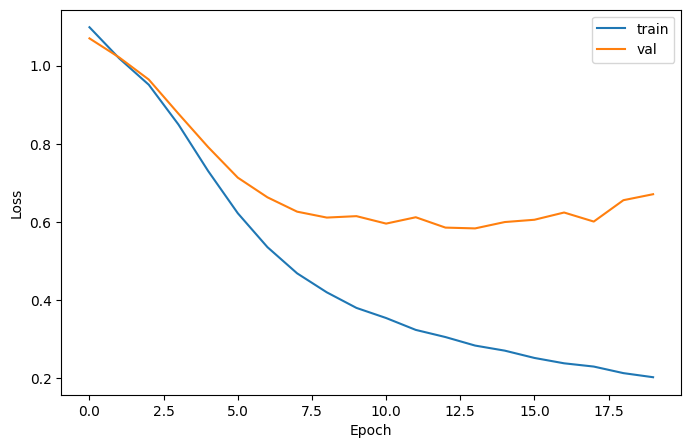

              precision    recall  f1-score   support

           1       0.96      0.94      0.95      1702
           2       0.85      0.95      0.89      1783
           3       0.79      0.89      0.83      1775
           4       0.63      0.59      0.61      1818
           5       0.73      0.60      0.66      1786

    accuracy                           0.79      8864
   macro avg       0.79      0.79      0.79      8864
weighted avg       0.79      0.79      0.79      8864



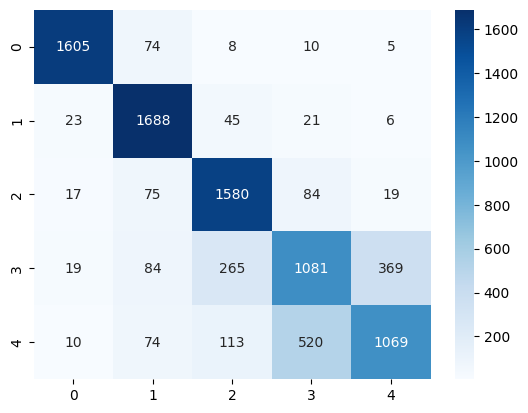

In [ ]:
Model_3 = ClassifierReLU2(768, 256, 128, 5)
Model_3 = model_training(Model_3, 20, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.232
validation loss: 1.186, validation precision: 0.470, validation recall: 0.477, validation F1: 0.469
[epoch: 2] loss: 1.182
validation loss: 1.181, validation precision: 0.485, validation recall: 0.476, validation F1: 0.474
[epoch: 3] loss: 1.161
validation loss: 1.173, validation precision: 0.497, validation recall: 0.477, validation F1: 0.481
[epoch: 4] loss: 1.136
validation loss: 1.156, validation precision: 0.492, validation recall: 0.492, validation F1: 0.492
[epoch: 5] loss: 1.112
validation loss: 1.157, validation precision: 0.488, validation recall: 0.488, validation F1: 0.487
[epoch: 6] loss: 1.086
validation loss: 1.163, validation precision: 0.481, validation recall: 0.483, validation F1: 0.479
[epoch: 7] loss: 1.054
validation loss: 1.183, validation precision: 0.469, validation recall: 0.485, validation F1: 0.471
[epoch: 8] loss: 1.020
validation loss: 1.195, validation precision: 0.483, validation recall: 0.482, validation F1: 0.481
[epoch: 9] loss:

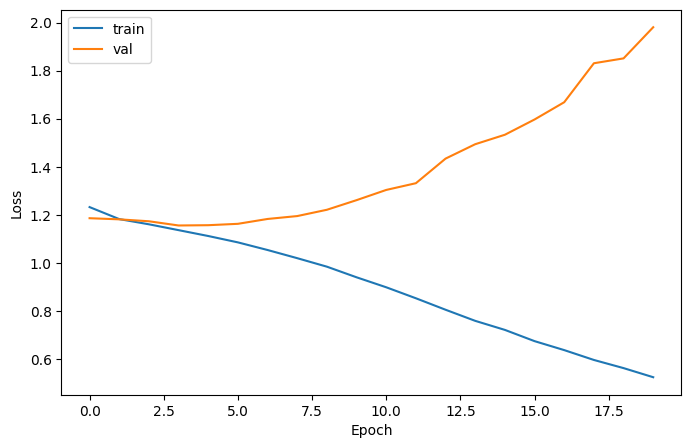

              precision    recall  f1-score   support

           1       0.52      0.55      0.53      1420
           2       0.33      0.32      0.33      1397
           3       0.36      0.36      0.36      1432
           4       0.38      0.35      0.37      1398
           5       0.59      0.62      0.61      1403

    accuracy                           0.44      7050
   macro avg       0.44      0.44      0.44      7050
weighted avg       0.44      0.44      0.44      7050



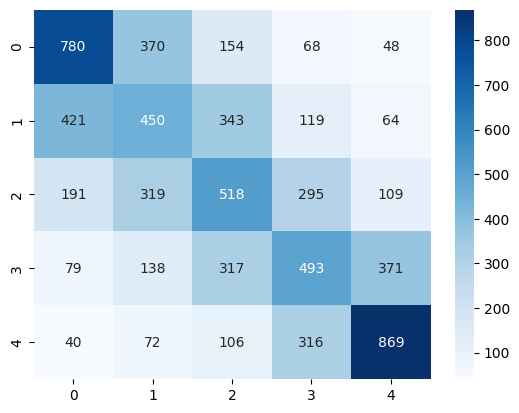

In [ ]:
Model_4 = ClassifierReLU2(768, 256, 128, 5)
Model_4 = model_training(Model_4, 20, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Обучение ReLU3

[epoch: 1] loss: 1.107
validation loss: 1.045, validation precision: 0.551, validation recall: 0.543, validation F1: 0.542
[epoch: 2] loss: 1.026
validation loss: 1.037, validation precision: 0.576, validation recall: 0.537, validation F1: 0.544
[epoch: 3] loss: 0.946
validation loss: 0.925, validation precision: 0.622, validation recall: 0.604, validation F1: 0.608
[epoch: 4] loss: 0.839
validation loss: 0.866, validation precision: 0.622, validation recall: 0.636, validation F1: 0.622
[epoch: 5] loss: 0.726
validation loss: 0.784, validation precision: 0.663, validation recall: 0.672, validation F1: 0.665
[epoch: 6] loss: 0.628
validation loss: 0.708, validation precision: 0.715, validation recall: 0.709, validation F1: 0.709
[epoch: 7] loss: 0.549
validation loss: 0.672, validation precision: 0.735, validation recall: 0.725, validation F1: 0.724
[epoch: 8] loss: 0.486
validation loss: 0.627, validation precision: 0.745, validation recall: 0.753, validation F1: 0.748
[epoch: 9] loss:

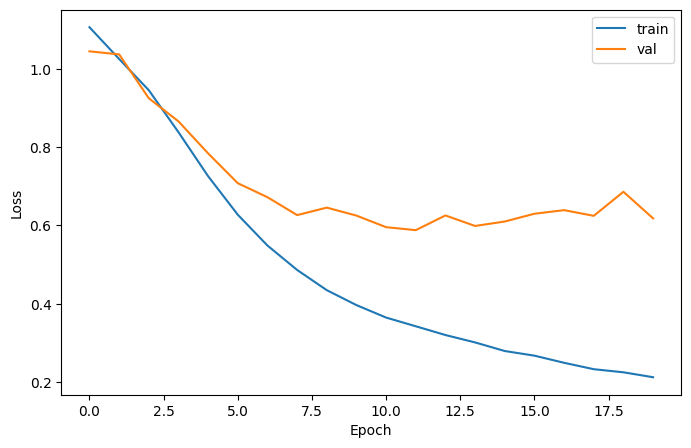

              precision    recall  f1-score   support

           1       0.94      0.96      0.95      1693
           2       0.90      0.93      0.91      1766
           3       0.84      0.85      0.85      1820
           4       0.61      0.64      0.62      1759
           5       0.73      0.66      0.69      1826

    accuracy                           0.80      8864
   macro avg       0.80      0.81      0.80      8864
weighted avg       0.80      0.80      0.80      8864



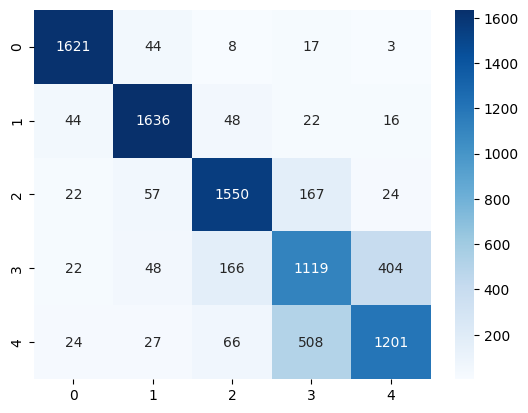

In [ ]:
Model_5 = ClassifierReLU3(768, 256, 128, 5)
Model_5 = model_training(Model_5, 20, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.239
validation loss: 1.196, validation precision: 0.457, validation recall: 0.468, validation F1: 0.455
[epoch: 2] loss: 1.184
validation loss: 1.189, validation precision: 0.462, validation recall: 0.469, validation F1: 0.454
[epoch: 3] loss: 1.159
validation loss: 1.171, validation precision: 0.467, validation recall: 0.478, validation F1: 0.462
[epoch: 4] loss: 1.132
validation loss: 1.183, validation precision: 0.475, validation recall: 0.471, validation F1: 0.466
[epoch: 5] loss: 1.105
validation loss: 1.178, validation precision: 0.470, validation recall: 0.484, validation F1: 0.472
[epoch: 6] loss: 1.072
validation loss: 1.198, validation precision: 0.480, validation recall: 0.486, validation F1: 0.480
[epoch: 7] loss: 1.039
validation loss: 1.201, validation precision: 0.484, validation recall: 0.476, validation F1: 0.479
[epoch: 8] loss: 1.000
validation loss: 1.235, validation precision: 0.477, validation recall: 0.474, validation F1: 0.475
[epoch: 9] loss:

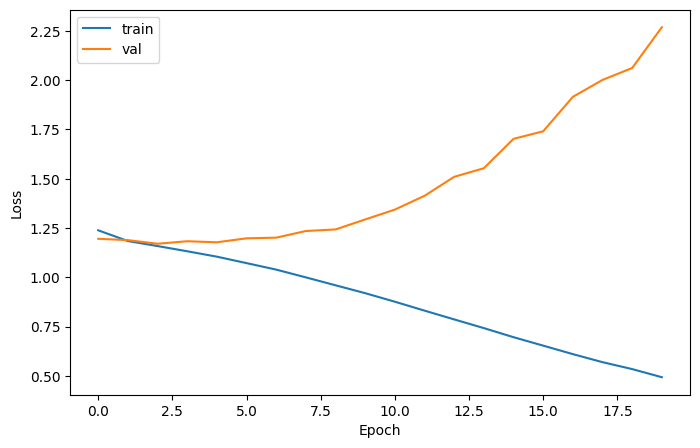

              precision    recall  f1-score   support

           1       0.55      0.53      0.54      1438
           2       0.33      0.38      0.35      1361
           3       0.38      0.30      0.33      1429
           4       0.35      0.37      0.36      1418
           5       0.58      0.61      0.60      1404

    accuracy                           0.44      7050
   macro avg       0.44      0.44      0.44      7050
weighted avg       0.44      0.44      0.44      7050



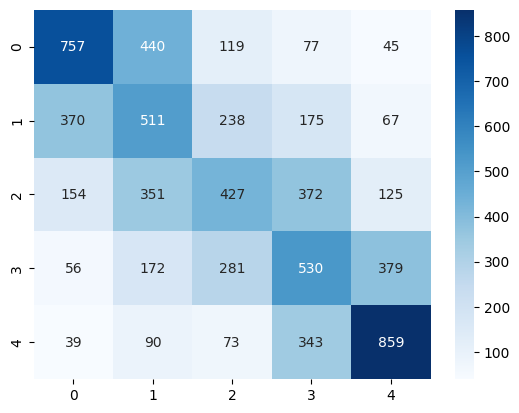

In [ ]:
Model_6 = ClassifierReLU3(768, 256, 128, 5)
Model_6 = model_training(Model_6, 20, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Обучение CNN

[epoch: 1] loss: 1.116
validation loss: 1.063, validation precision: 0.527, validation recall: 0.532, validation F1: 0.527
[epoch: 2] loss: 1.039
validation loss: 1.039, validation precision: 0.547, validation recall: 0.548, validation F1: 0.546
[epoch: 3] loss: 1.003
validation loss: 1.017, validation precision: 0.549, validation recall: 0.552, validation F1: 0.543
[epoch: 4] loss: 0.960
validation loss: 0.987, validation precision: 0.567, validation recall: 0.577, validation F1: 0.569
[epoch: 5] loss: 0.914
validation loss: 0.956, validation precision: 0.603, validation recall: 0.587, validation F1: 0.587
[epoch: 6] loss: 0.865
validation loss: 0.918, validation precision: 0.605, validation recall: 0.611, validation F1: 0.606
[epoch: 7] loss: 0.813
validation loss: 0.893, validation precision: 0.624, validation recall: 0.619, validation F1: 0.619
[epoch: 8] loss: 0.769
validation loss: 0.865, validation precision: 0.630, validation recall: 0.631, validation F1: 0.628
[epoch: 9] loss:

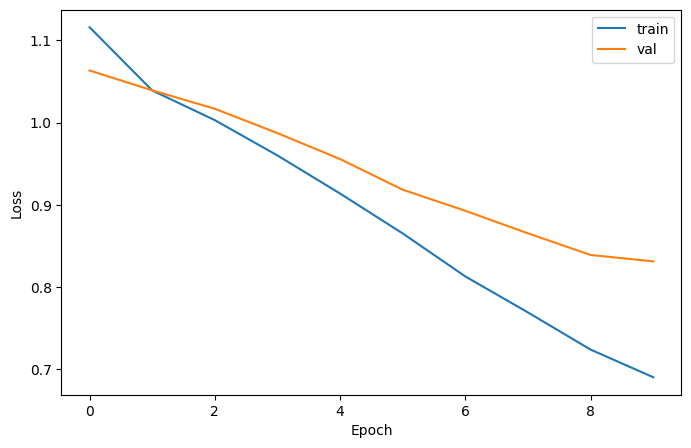

              precision    recall  f1-score   support

           1       0.81      0.88      0.84      1715
           2       0.63      0.77      0.69      1770
           3       0.62      0.53      0.57      1705
           4       0.50      0.47      0.49      1828
           5       0.68      0.60      0.64      1846

    accuracy                           0.65      8864
   macro avg       0.65      0.65      0.65      8864
weighted avg       0.65      0.65      0.64      8864



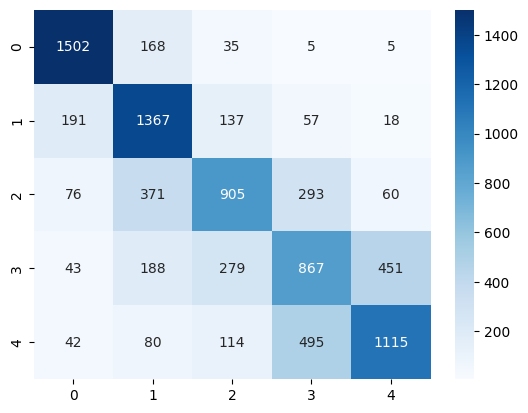

In [ ]:
Model_7 = CNN_Text(768, 5, 100, [3, 4, 5])
Model_7 = model_training(Model_7, 10, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.250
validation loss: 1.196, validation precision: 0.463, validation recall: 0.477, validation F1: 0.456
[epoch: 2] loss: 1.193
validation loss: 1.184, validation precision: 0.477, validation recall: 0.481, validation F1: 0.477
[epoch: 3] loss: 1.179
validation loss: 1.178, validation precision: 0.477, validation recall: 0.475, validation F1: 0.472
[epoch: 4] loss: 1.163
validation loss: 1.173, validation precision: 0.472, validation recall: 0.484, validation F1: 0.470
[epoch: 5] loss: 1.150
validation loss: 1.176, validation precision: 0.478, validation recall: 0.481, validation F1: 0.476
[epoch: 6] loss: 1.136
validation loss: 1.174, validation precision: 0.478, validation recall: 0.476, validation F1: 0.475
[epoch: 7] loss: 1.121
validation loss: 1.175, validation precision: 0.474, validation recall: 0.480, validation F1: 0.467
[epoch: 8] loss: 1.107
validation loss: 1.189, validation precision: 0.465, validation recall: 0.480, validation F1: 0.466
[epoch: 9] loss:

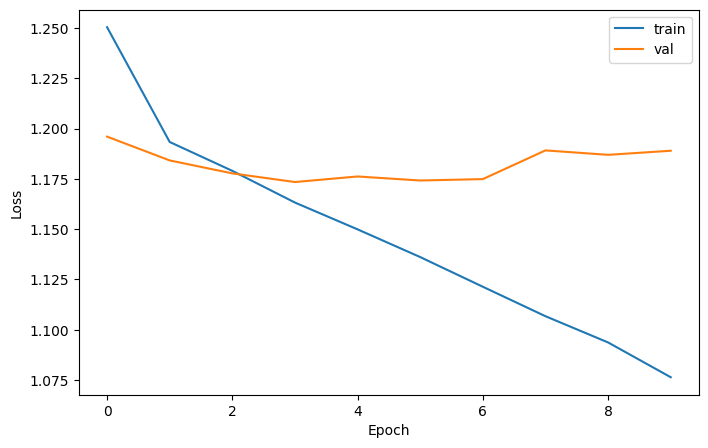

              precision    recall  f1-score   support

           1       0.56      0.60      0.58      1396
           2       0.35      0.40      0.38      1386
           3       0.40      0.34      0.37      1440
           4       0.42      0.43      0.42      1450
           5       0.64      0.60      0.62      1378

    accuracy                           0.47      7050
   macro avg       0.47      0.47      0.47      7050
weighted avg       0.47      0.47      0.47      7050



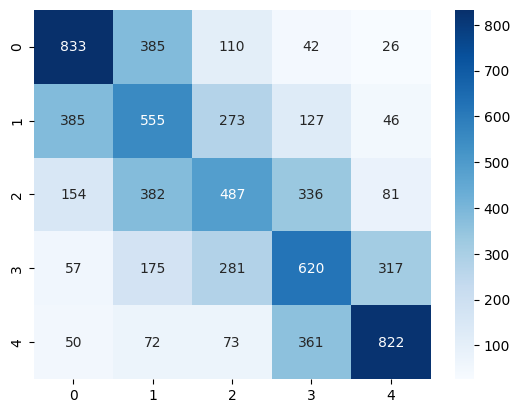

In [ ]:
Model_8 = CNN_Text(768, 5, 100, [3, 4, 5])
Model_8 = model_training(Model_8, 10, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Обучение LSTM

[epoch: 1] loss: 1.115
validation loss: 1.064, validation precision: 0.535, validation recall: 0.539, validation F1: 0.532
[epoch: 2] loss: 1.045
validation loss: 1.066, validation precision: 0.519, validation recall: 0.531, validation F1: 0.517
[epoch: 3] loss: 1.024
validation loss: 1.028, validation precision: 0.551, validation recall: 0.550, validation F1: 0.546
[epoch: 4] loss: 0.998
validation loss: 1.010, validation precision: 0.558, validation recall: 0.562, validation F1: 0.558
[epoch: 5] loss: 0.966
validation loss: 1.009, validation precision: 0.567, validation recall: 0.568, validation F1: 0.561
[epoch: 6] loss: 0.925
validation loss: 0.970, validation precision: 0.578, validation recall: 0.586, validation F1: 0.577
[epoch: 7] loss: 0.877
validation loss: 0.949, validation precision: 0.615, validation recall: 0.596, validation F1: 0.596
[epoch: 8] loss: 0.825
validation loss: 0.909, validation precision: 0.609, validation recall: 0.620, validation F1: 0.611
[epoch: 9] loss:

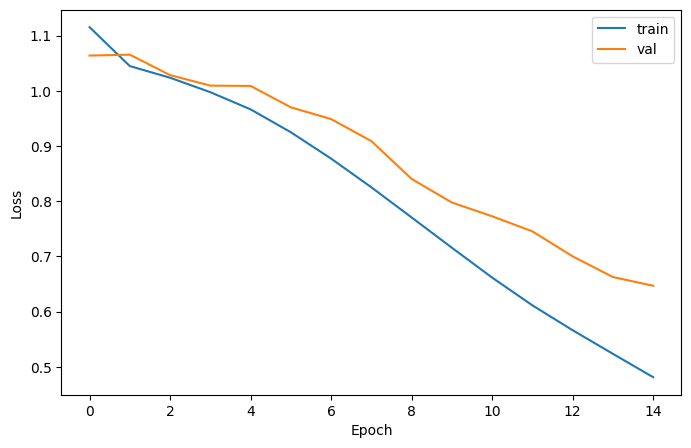

              precision    recall  f1-score   support

           1       0.93      0.94      0.93      1670
           2       0.80      0.85      0.82      1754
           3       0.75      0.72      0.73      1783
           4       0.59      0.47      0.53      1850
           5       0.63      0.76      0.69      1807

    accuracy                           0.74      8864
   macro avg       0.74      0.75      0.74      8864
weighted avg       0.74      0.74      0.74      8864



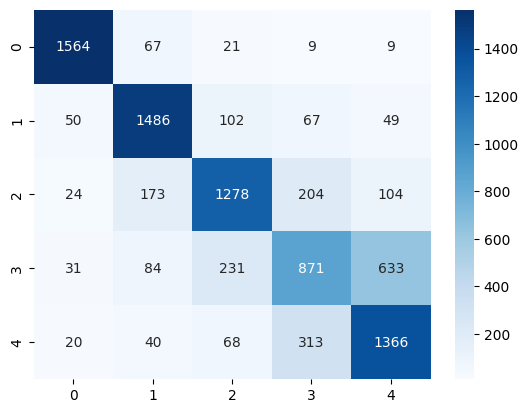

In [ ]:
Model_9 = LSTM_text(768, 256, 1, 5)
Model_9 = model_training(Model_9, 15, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.252
validation loss: 1.188, validation precision: 0.481, validation recall: 0.486, validation F1: 0.483
[epoch: 2] loss: 1.194
validation loss: 1.168, validation precision: 0.470, validation recall: 0.480, validation F1: 0.473
[epoch: 3] loss: 1.180
validation loss: 1.170, validation precision: 0.467, validation recall: 0.484, validation F1: 0.470
[epoch: 4] loss: 1.170
validation loss: 1.160, validation precision: 0.482, validation recall: 0.482, validation F1: 0.480
[epoch: 5] loss: 1.158
validation loss: 1.160, validation precision: 0.497, validation recall: 0.489, validation F1: 0.490
[epoch: 6] loss: 1.145
validation loss: 1.158, validation precision: 0.487, validation recall: 0.491, validation F1: 0.485
[epoch: 7] loss: 1.132
validation loss: 1.154, validation precision: 0.492, validation recall: 0.494, validation F1: 0.491
[epoch: 8] loss: 1.120
validation loss: 1.148, validation precision: 0.487, validation recall: 0.493, validation F1: 0.488
[epoch: 9] loss:

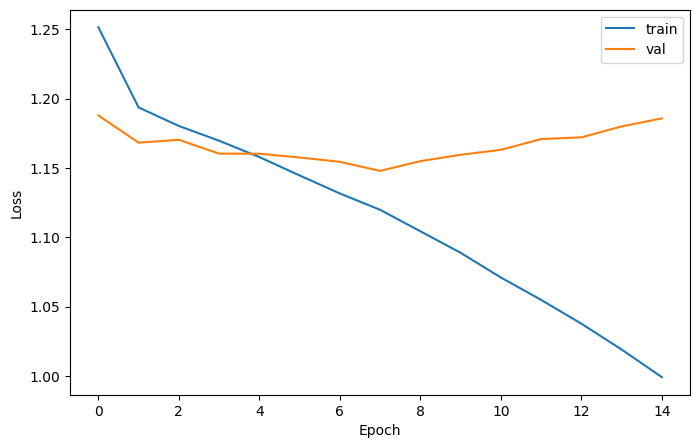

              precision    recall  f1-score   support

           1       0.60      0.60      0.60      1428
           2       0.36      0.39      0.38      1383
           3       0.38      0.31      0.34      1412
           4       0.40      0.43      0.42      1436
           5       0.64      0.65      0.65      1391

    accuracy                           0.48      7050
   macro avg       0.48      0.48      0.48      7050
weighted avg       0.48      0.48      0.48      7050



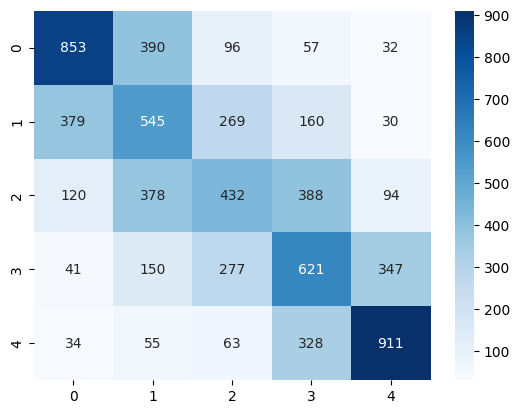

In [ ]:
Model_10 = LSTM_text(768, 256, 1, 5)
Model_10 = model_training(Model_10, 15, 0.001, 16, df2_bal, 'LaBASE', 'rating')

[epoch: 1] loss: 1.131
validation loss: 1.087, validation precision: 0.531, validation recall: 0.521, validation F1: 0.522
[epoch: 2] loss: 1.055
validation loss: 1.046, validation precision: 0.543, validation recall: 0.549, validation F1: 0.544
[epoch: 3] loss: 1.025
validation loss: 1.043, validation precision: 0.550, validation recall: 0.550, validation F1: 0.548
[epoch: 4] loss: 0.986
validation loss: 1.022, validation precision: 0.550, validation recall: 0.549, validation F1: 0.549
[epoch: 5] loss: 0.932
validation loss: 0.977, validation precision: 0.586, validation recall: 0.579, validation F1: 0.581
[epoch: 6] loss: 0.855
validation loss: 0.890, validation precision: 0.610, validation recall: 0.613, validation F1: 0.609
[epoch: 7] loss: 0.769
validation loss: 0.849, validation precision: 0.642, validation recall: 0.641, validation F1: 0.636
[epoch: 8] loss: 0.683
validation loss: 0.802, validation precision: 0.669, validation recall: 0.664, validation F1: 0.661
[epoch: 9] loss:

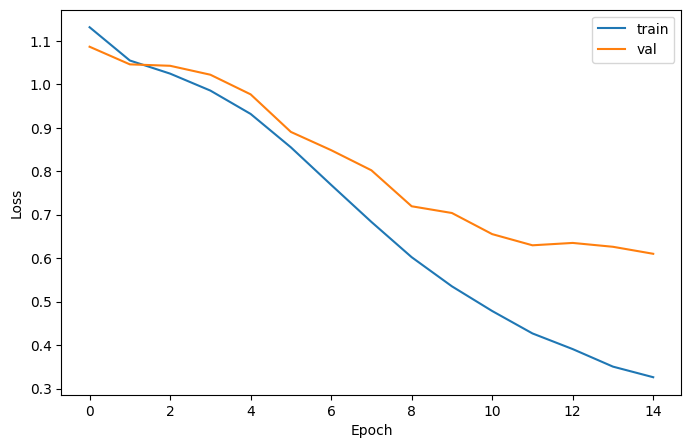

              precision    recall  f1-score   support

           1       0.92      0.98      0.95      1736
           2       0.89      0.88      0.89      1843
           3       0.72      0.85      0.78      1769
           4       0.61      0.42      0.50      1736
           5       0.70      0.74      0.72      1780

    accuracy                           0.78      8864
   macro avg       0.77      0.78      0.77      8864
weighted avg       0.77      0.78      0.77      8864



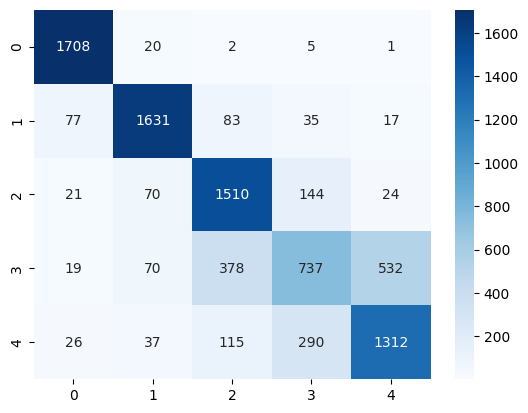

In [ ]:
Model_11 = LSTM_text(768, 256, 2, 5)
Model_11 = model_training(Model_11, 15, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.261
validation loss: 1.196, validation precision: 0.467, validation recall: 0.472, validation F1: 0.469
[epoch: 2] loss: 1.194
validation loss: 1.194, validation precision: 0.486, validation recall: 0.479, validation F1: 0.480
[epoch: 3] loss: 1.181
validation loss: 1.182, validation precision: 0.477, validation recall: 0.478, validation F1: 0.477
[epoch: 4] loss: 1.165
validation loss: 1.178, validation precision: 0.467, validation recall: 0.480, validation F1: 0.468
[epoch: 5] loss: 1.149
validation loss: 1.160, validation precision: 0.486, validation recall: 0.486, validation F1: 0.485
[epoch: 6] loss: 1.130
validation loss: 1.172, validation precision: 0.485, validation recall: 0.479, validation F1: 0.481
[epoch: 7] loss: 1.113
validation loss: 1.165, validation precision: 0.472, validation recall: 0.487, validation F1: 0.475
[epoch: 8] loss: 1.095
validation loss: 1.171, validation precision: 0.475, validation recall: 0.485, validation F1: 0.478
[epoch: 9] loss:

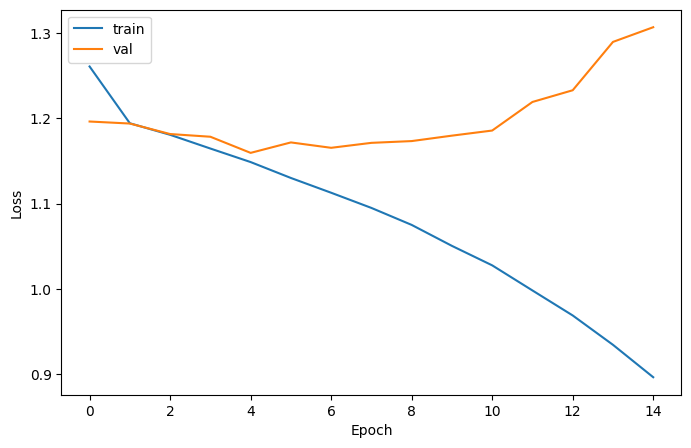

              precision    recall  f1-score   support

           1       0.59      0.61      0.60      1424
           2       0.39      0.30      0.34      1391
           3       0.36      0.42      0.39      1387
           4       0.43      0.39      0.41      1482
           5       0.59      0.66      0.62      1366

    accuracy                           0.48      7050
   macro avg       0.47      0.48      0.47      7050
weighted avg       0.47      0.48      0.47      7050



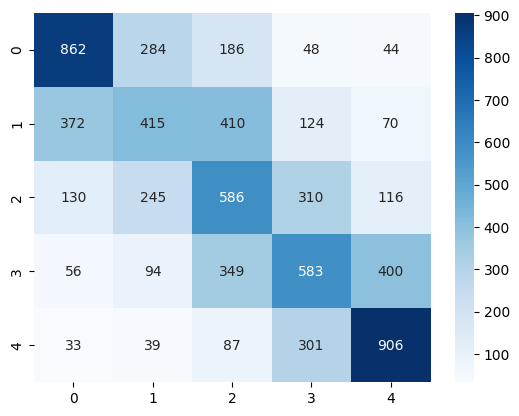

In [ ]:
Model_12 = LSTM_text(768, 256, 2, 5)
Model_12 = model_training(Model_12, 15, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Обучение Transformers

[epoch: 1] loss: 1.202
validation loss: 1.176, validation precision: 0.469, validation recall: 0.479, validation F1: 0.416
[epoch: 2] loss: 1.111
validation loss: 1.219, validation precision: 0.466, validation recall: 0.452, validation F1: 0.433
[epoch: 3] loss: 1.153
validation loss: 1.158, validation precision: 0.510, validation recall: 0.490, validation F1: 0.490
[epoch: 4] loss: 1.133
validation loss: 1.184, validation precision: 0.446, validation recall: 0.471, validation F1: 0.437
[epoch: 5] loss: 1.108
validation loss: 1.181, validation precision: 0.507, validation recall: 0.475, validation F1: 0.483
[epoch: 6] loss: 1.096
validation loss: 1.274, validation precision: 0.481, validation recall: 0.459, validation F1: 0.462
[epoch: 7] loss: 1.083
validation loss: 1.205, validation precision: 0.488, validation recall: 0.482, validation F1: 0.481
[epoch: 8] loss: 1.083
validation loss: 1.215, validation precision: 0.505, validation recall: 0.478, validation F1: 0.487
[epoch: 9] loss:

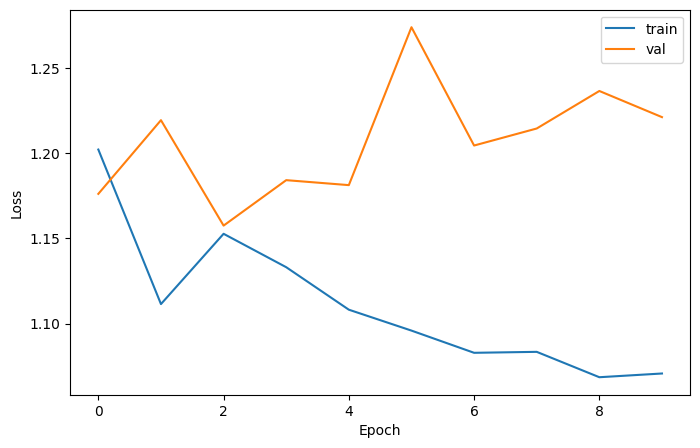

              precision    recall  f1-score   support

           1       0.55      0.77      0.64      1683
           2       0.38      0.28      0.32      1814
           3       0.39      0.40      0.39      1740
           4       0.45      0.29      0.36      1839
           5       0.58      0.71      0.64      1788

    accuracy                           0.49      8864
   macro avg       0.47      0.49      0.47      8864
weighted avg       0.47      0.49      0.47      8864



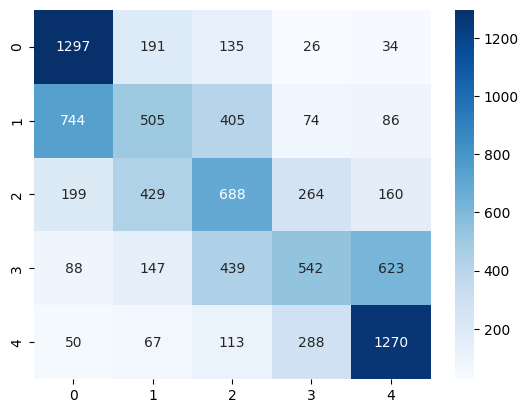

In [ ]:
Model_13 = TransformerClassifier(768, 5, 2, 8, 256, dropout=0.1)
Model_13 = model_training(Model_13, 10, 0.001, 16, df1_bal, 'LaBASE', 'Rating')

[epoch: 1] loss: 1.350
validation loss: 1.558, validation precision: 0.256, validation recall: 0.301, validation F1: 0.214
[epoch: 2] loss: 1.384
validation loss: 1.345, validation precision: 0.424, validation recall: 0.428, validation F1: 0.414
[epoch: 3] loss: 1.327
validation loss: 1.283, validation precision: 0.428, validation recall: 0.435, validation F1: 0.419
[epoch: 4] loss: 1.282
validation loss: 1.256, validation precision: 0.447, validation recall: 0.451, validation F1: 0.443
[epoch: 5] loss: 1.269
validation loss: 1.272, validation precision: 0.439, validation recall: 0.441, validation F1: 0.424
[epoch: 6] loss: 1.294
validation loss: 1.299, validation precision: 0.427, validation recall: 0.447, validation F1: 0.420
[epoch: 7] loss: 1.283
validation loss: 1.271, validation precision: 0.459, validation recall: 0.442, validation F1: 0.432
[epoch: 8] loss: 1.264
validation loss: 1.285, validation precision: 0.451, validation recall: 0.441, validation F1: 0.443
[epoch: 9] loss:

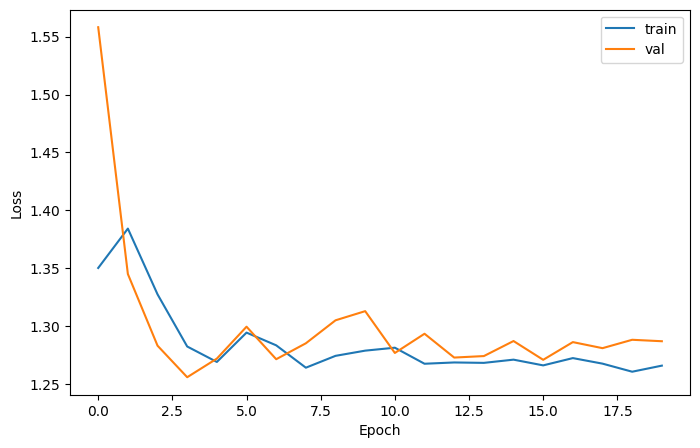

              precision    recall  f1-score   support

           1       0.48      0.77      0.59      1357
           2       0.34      0.15      0.21      1410
           3       0.33      0.48      0.39      1425
           4       0.39      0.25      0.31      1435
           5       0.65      0.55      0.59      1423

    accuracy                           0.44      7050
   macro avg       0.44      0.44      0.42      7050
weighted avg       0.44      0.44      0.42      7050



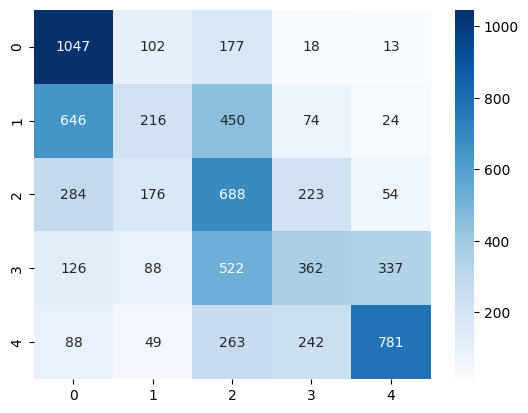

In [ ]:
Model_14 = TransformerClassifier(768, 5, 2, 8, 256, dropout=0.1)
Model_14 = model_training(Model_14, 20, 0.001, 16, df2_bal, 'LaBASE', 'rating')

### Сравнение 1
Как поведут себя модели, обученные на oversample датасете

In [ ]:
def testing(model, data, embed, target):
    val_embeddings = data[f'{embed}'].to_list()
    val_targets = data[f'{target}'].to_list()
    val_dataset = MyDataset(val_embeddings, val_targets)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    model = model
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for val_data in val_dataloader:
            val_inputs, val_labels = val_data
            val_labels = val_labels - 1
            val_outputs = model(val_inputs)
            val_predictions += list(torch.argmax(val_outputs, dim=1).numpy())
            val_targets += list(val_labels.numpy())
        val_precision = precision_score(val_targets, val_predictions, average='macro')
        val_recall = recall_score(val_targets, val_predictions, average='macro')
        val_f1 = f1_score(val_targets, val_predictions, average='macro')
    print('precision: %.3f, recall: %.3f, F1: %.3f' % (val_precision, val_recall, val_f1))
    print(classification_report((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()))
    sns.heatmap(confusion_matrix((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()), annot=True, cmap="Blues", fmt="d")

precision: 0.383, recall: 0.372, F1: 0.350
              precision    recall  f1-score   support

           1       0.59      0.37      0.46      7050
           2       0.33      0.24      0.28      7050
           3       0.31      0.16      0.21      7050
           4       0.32      0.31      0.32      7050
           5       0.36      0.79      0.49      7050

    accuracy                           0.37     35250
   macro avg       0.38      0.37      0.35     35250
weighted avg       0.38      0.37      0.35     35250



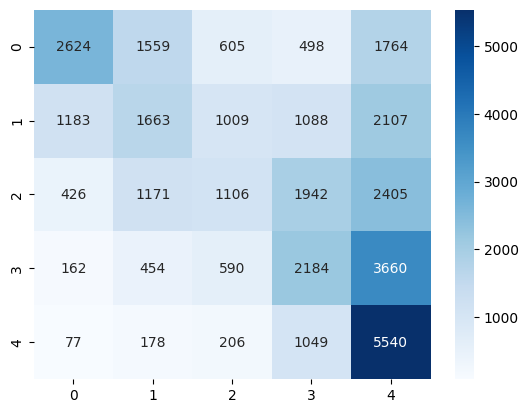

In [ ]:
testing(Model_1, df2_bal, 'LaBASE', 'rating')

precision: 0.378, recall: 0.361, F1: 0.345
              precision    recall  f1-score   support

           1       0.59      0.32      0.42      7050
           2       0.33      0.21      0.26      7050
           3       0.30      0.17      0.21      7050
           4       0.29      0.44      0.35      7050
           5       0.39      0.66      0.49      7050

    accuracy                           0.36     35250
   macro avg       0.38      0.36      0.35     35250
weighted avg       0.38      0.36      0.35     35250



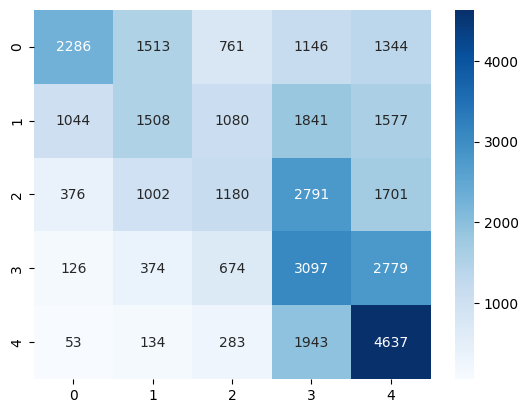

In [ ]:
testing(Model_3, df2_bal, 'LaBASE', 'rating')

precision: 0.378, recall: 0.363, F1: 0.342
              precision    recall  f1-score   support

           1       0.59      0.32      0.41      7050
           2       0.32      0.25      0.28      7050
           3       0.32      0.17      0.22      7050
           4       0.29      0.30      0.29      7050
           5       0.37      0.78      0.50      7050

    accuracy                           0.36     35250
   macro avg       0.38      0.36      0.34     35250
weighted avg       0.38      0.36      0.34     35250



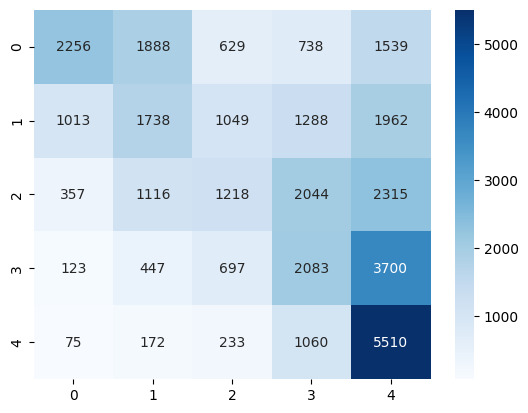

In [ ]:
testing(Model_5, df2_bal, 'LaBASE', 'rating')

precision: 0.386, recall: 0.389, F1: 0.366
              precision    recall  f1-score   support

           1       0.54      0.46      0.50      7050
           2       0.35      0.20      0.25      7050
           3       0.33      0.19      0.24      7050
           4       0.31      0.34      0.32      7050
           5       0.40      0.77      0.52      7050

    accuracy                           0.39     35250
   macro avg       0.39      0.39      0.37     35250
weighted avg       0.39      0.39      0.37     35250



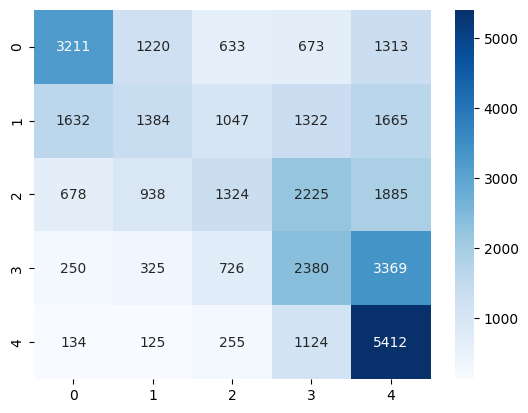

In [ ]:
testing(Model_7, df2_bal, 'LaBASE', 'rating')

precision: 0.375, recall: 0.363, F1: 0.331
              precision    recall  f1-score   support

           1       0.57      0.37      0.45      7050
           2       0.35      0.20      0.25      7050
           3       0.31      0.11      0.17      7050
           4       0.29      0.30      0.30      7050
           5       0.35      0.84      0.49      7050

    accuracy                           0.36     35250
   macro avg       0.37      0.36      0.33     35250
weighted avg       0.37      0.36      0.33     35250



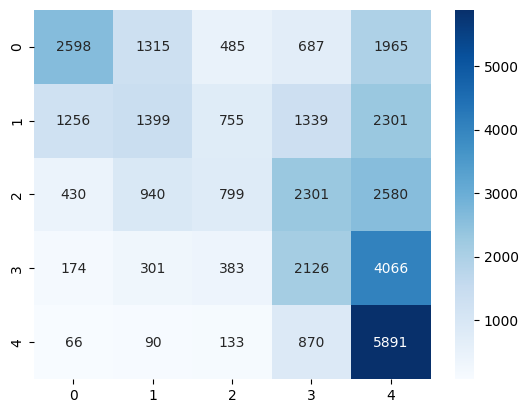

In [ ]:
testing(Model_9, df2_bal, 'LaBASE', 'rating')

precision: 0.377, recall: 0.364, F1: 0.332
              precision    recall  f1-score   support

           1       0.59      0.38      0.46      7050
           2       0.35      0.18      0.24      7050
           3       0.32      0.16      0.22      7050
           4       0.28      0.23      0.25      7050
           5       0.35      0.87      0.50      7050

    accuracy                           0.36     35250
   macro avg       0.38      0.36      0.33     35250
weighted avg       0.38      0.36      0.33     35250



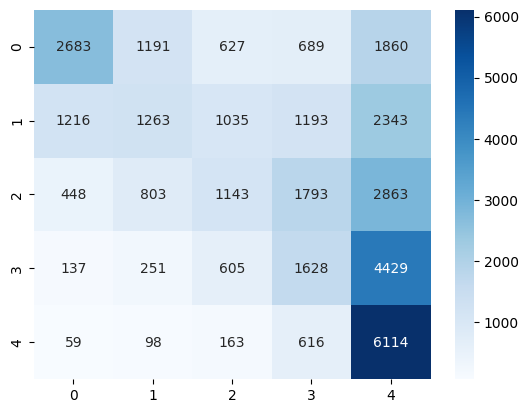

In [ ]:
testing(Model_11, df2_bal, 'LaBASE', 'rating')

precision: 0.363, recall: 0.393, F1: 0.345
              precision    recall  f1-score   support

           1       0.46      0.66      0.54      7050
           2       0.29      0.16      0.20      7050
           3       0.36      0.17      0.23      7050
           4       0.29      0.16      0.21      7050
           5       0.41      0.83      0.55      7050

    accuracy                           0.39     35250
   macro avg       0.36      0.39      0.35     35250
weighted avg       0.36      0.39      0.35     35250



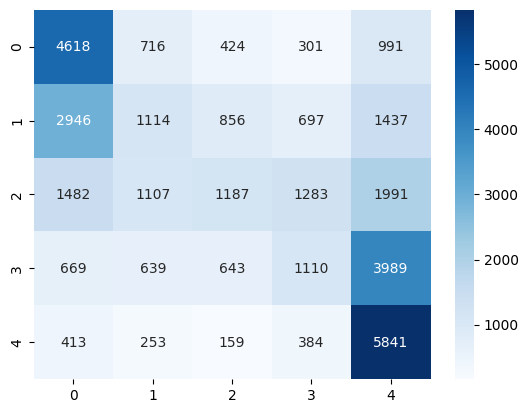

In [ ]:
testing(Model_13, df2_bal, 'LaBASE', 'rating')

### Сравнение 2
Как поведут себя модели, обученные на undersample датасете

precision: 0.420, recall: 0.397, F1: 0.394
              precision    recall  f1-score   support

           1       0.48      0.60      0.53      8526
           2       0.32      0.38      0.35      8965
           3       0.31      0.43      0.36      8736
           4       0.36      0.25      0.30      9039
           5       0.62      0.33      0.43      9054

    accuracy                           0.39     44320
   macro avg       0.42      0.40      0.39     44320
weighted avg       0.42      0.39      0.39     44320



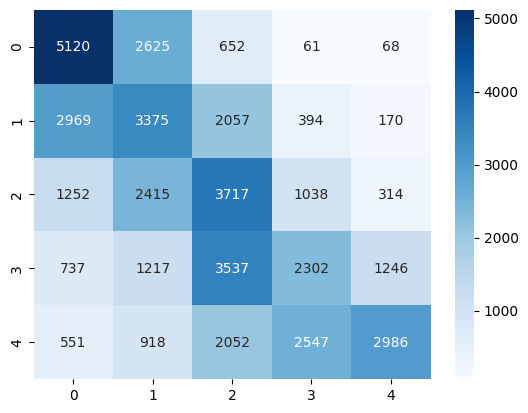

In [ ]:
testing(Model_2, df1_bal, 'LaBASE', 'Rating')

precision: 0.414, recall: 0.384, F1: 0.383
              precision    recall  f1-score   support

           1       0.47      0.52      0.50      8526
           2       0.32      0.42      0.36      8965
           3       0.30      0.41      0.35      8736
           4       0.36      0.29      0.32      9039
           5       0.62      0.29      0.39      9054

    accuracy                           0.38     44320
   macro avg       0.41      0.38      0.38     44320
weighted avg       0.41      0.38      0.38     44320



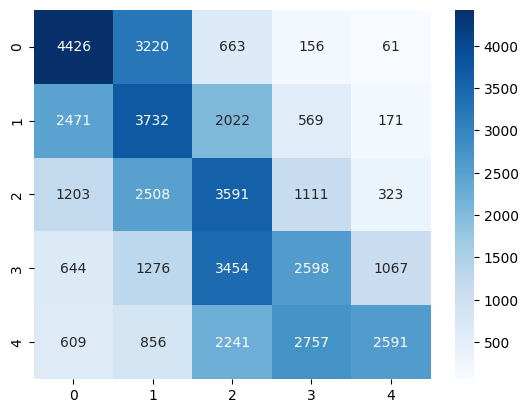

In [ ]:
testing(Model_4, df1_bal, 'LaBASE', 'Rating')

precision: 0.419, recall: 0.394, F1: 0.393
              precision    recall  f1-score   support

           1       0.51      0.59      0.55      8526
           2       0.31      0.40      0.35      8965
           3       0.31      0.34      0.32      8736
           4       0.35      0.35      0.35      9039
           5       0.62      0.30      0.40      9054

    accuracy                           0.39     44320
   macro avg       0.42      0.39      0.39     44320
weighted avg       0.42      0.39      0.39     44320



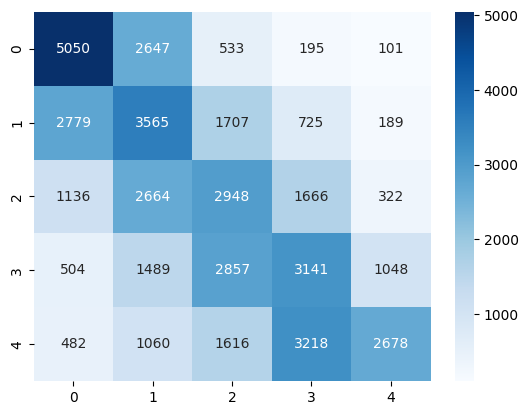

In [ ]:
testing(Model_6, df1_bal, 'LaBASE', 'Rating')

precision: 0.466, recall: 0.444, F1: 0.439
              precision    recall  f1-score   support

           1       0.54      0.69      0.61      8526
           2       0.35      0.43      0.39      8965
           3       0.37      0.36      0.37      8736
           4       0.39      0.41      0.40      9039
           5       0.68      0.32      0.44      9054

    accuracy                           0.44     44320
   macro avg       0.47      0.44      0.44     44320
weighted avg       0.47      0.44      0.44     44320



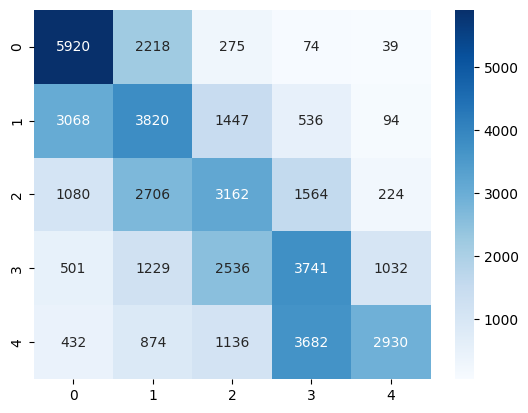

In [ ]:
testing(Model_8, df1_bal, 'LaBASE', 'Rating')

precision: 0.465, recall: 0.454, F1: 0.453
              precision    recall  f1-score   support

           1       0.56      0.63      0.59      8526
           2       0.37      0.46      0.41      8965
           3       0.35      0.41      0.37      8736
           4       0.41      0.31      0.35      9039
           5       0.64      0.46      0.54      9054

    accuracy                           0.45     44320
   macro avg       0.47      0.45      0.45     44320
weighted avg       0.47      0.45      0.45     44320



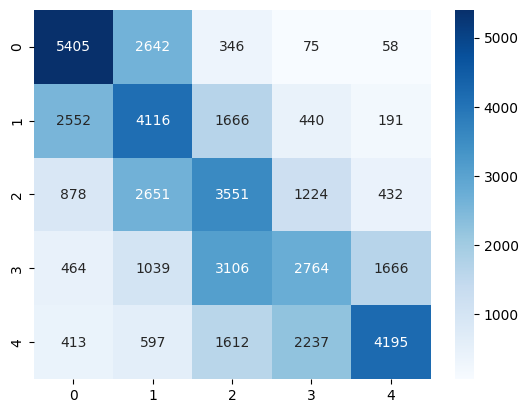

In [ ]:
testing(Model_10, df1_bal, 'LaBASE', 'Rating')

precision: 0.484, recall: 0.448, F1: 0.446
              precision    recall  f1-score   support

           1       0.59      0.61      0.60      8526
           2       0.37      0.35      0.36      8965
           3       0.35      0.54      0.43      8736
           4       0.40      0.41      0.41      9039
           5       0.71      0.32      0.44      9054

    accuracy                           0.45     44320
   macro avg       0.48      0.45      0.45     44320
weighted avg       0.48      0.45      0.44     44320



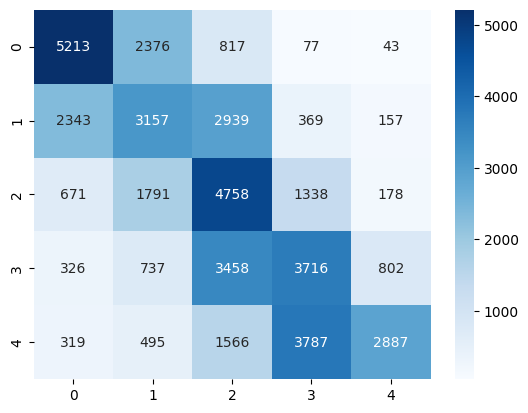

In [ ]:
testing(Model_12, df1_bal, 'LaBASE', 'Rating')

precision: 0.378, recall: 0.362, F1: 0.339
              precision    recall  f1-score   support

           1       0.41      0.75      0.53      8526
           2       0.28      0.19      0.23      8965
           3       0.27      0.40      0.32      8736
           4       0.36      0.25      0.29      9039
           5       0.57      0.23      0.33      9054

    accuracy                           0.36     44320
   macro avg       0.38      0.36      0.34     44320
weighted avg       0.38      0.36      0.34     44320



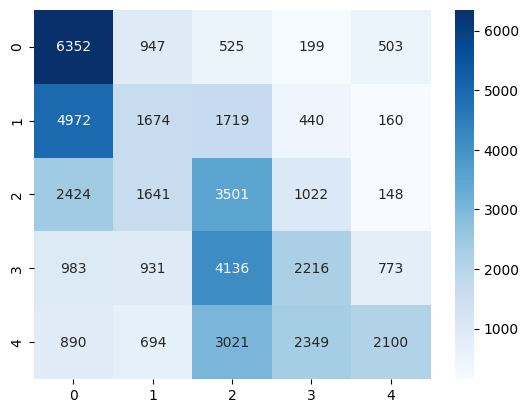

In [ ]:
testing(Model_14, df1_bal, 'LaBASE', 'Rating')

# **Немного несбалансированный датасет на bert-tiny**
По итогу модели "не видят" самый маленький класс, при это в обучениии и валидации он присутствует

## Подготовка

In [27]:
df_no_bal = pd.read_json('/content/drive/MyDrive/cw_classifier/parsed.jl', lines=True)
df_no_bal['rating'] = df_no_bal['rating']/10
df_no_bal.drop(['hotel', 'address', 'date'], axis=1, inplace=True)
df_no_bal.rename(columns={'content': 'review'}, inplace=True)
grouped_df = df_no_bal.groupby('rating')
dfs_by_rating = [grouped_df.get_group(x) for x in grouped_df.groups]
min_count = 12000
dfs_sampled = []
for d in dfs_by_rating:
  if len(d) >= min_count:
    dfs_sampled.append(d.sample(min_count, random_state=42))
  else:
    dfs_sampled.append(d.sample(len(d), random_state=42))
# dfs_sampled = [d.sample(min_count, random_state=42) for d in dfs_by_rating]
df_such_no_bal = pd.concat(dfs_sampled)

In [28]:
sentences = df_such_no_bal['review'].to_list()
total_embed = []
start_time = time.time()
for i in range(0, len(sentences), 1000):
  if i+1000 > len(sentences):
    encoded_input = tokenizer(sentences[i:], padding=True, truncation=True, max_length=64, return_tensors='pt')
  else:
    encoded_input = tokenizer(sentences[i:i+1000], padding=True, truncation=True, max_length=64, return_tensors='pt')
  with torch.no_grad():
    model_output = model_bert_tiny(**encoded_input)
  embeddings = model_output.pooler_output
  embeddings = torch.nn.functional.normalize(embeddings)
  total_embed += embeddings.tolist()
df_such_no_bal['bert-tiny'] = total_embed

In [31]:
Counter(df_such_no_bal['rating'])

Counter({1.0: 8082, 2.0: 7050, 3.0: 12000, 4.0: 12000, 5.0: 12000})

In [32]:
df_such_no_bal

rating                                             review  \
98449      1.0  Believe me it's a real catastrophe, bad animat...   
14567      1.0  dog poo at swimming pool area[ if dogs allowed...   
98849      1.0  My family was kicked out of the main restauran...   
14518      1.0  Cant even speak English properly, Ants in the ...   
108611     1.0  We have just come back from Tunisia, Hammamet,...   
...        ...                                                ...   
222        5.0  Dear All (Hotel Staff of Ibis, Sfax), I am wri...   
92973      5.0  Very friendly staff and perfect service!Thanks...   
59264      5.0  Naprostá spokojenost hlavně animátoři se velmi...   
41359      5.0  We stayed at Nozha beach 25th August - 8th Sep...   
108477     5.0  I have just returned from my holiday at the Ib...   

                                                bert-tiny  
98449   [-0.11144425719976425, 0.006086986046284437, -...  
14567   [-0.11140421777963638, 0.007238183636218309, -...  
98849   [-0.11129186302423477, 0.006494430359452963, -...  
14518   [-0.11145908385515213, -0.0010922732762992382,...  
108611  [-0.11131948232650757, 0.004333480726927519, -...  
...                                                   ...  
222     [-0.1117435023188591, 0.01454569585621357, -0....  
92973   [-0.11396761238574982, 0.009059498086571693, -...  
59264   [-0.12608401477336884, 0.005776694510132074, -...  
41359   [-0.11137653142213821, 0.0018923251191154122, ...  
108477  [-0.11143425852060318, 0.013541772961616516, -...  

[51132 rows x 3 columns]

In [34]:
train_index = df_such_no_bal.sample(int(df_such_no_bal.shape[0]*0.8)).index
Counter(df_such_no_bal.loc[train_index][f'rating'].to_list())

Counter({5.0: 9503, 3.0: 9598, 4.0: 9600, 2.0: 5673, 1.0: 6531})

## Обучение

### ReLU1

Counter({5.0: 2465, 3.0: 2396, 4.0: 2389, 1.0: 1560, 2.0: 1417})
[epoch: 1] loss: 1.526
validation loss: 1.468, validation precision: 0.484, validation recall: 0.330, validation F1: 0.285
[epoch: 2] loss: 1.453
validation loss: 1.437, validation precision: 0.491, validation recall: 0.337, validation F1: 0.301
[epoch: 3] loss: 1.434
validation loss: 1.431, validation precision: 0.506, validation recall: 0.356, validation F1: 0.326
[epoch: 4] loss: 1.423
validation loss: 1.418, validation precision: 0.500, validation recall: 0.355, validation F1: 0.316
[epoch: 5] loss: 1.416
validation loss: 1.420, validation precision: 0.499, validation recall: 0.346, validation F1: 0.318
[epoch: 6] loss: 1.410
validation loss: 1.406, validation precision: 0.513, validation recall: 0.360, validation F1: 0.327
[epoch: 7] loss: 1.406
validation loss: 1.403, validation precision: 0.510, validation recall: 0.365, validation F1: 0.334
[epoch: 8] loss: 1.403
validation loss: 1.405, validation precision: 0.522

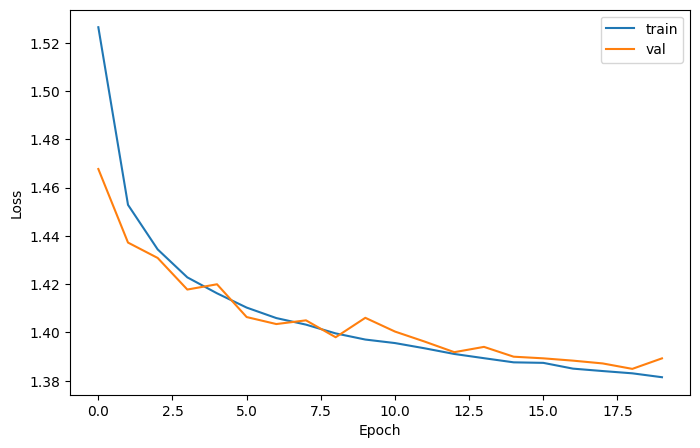

              precision    recall  f1-score   support

           1       0.40      0.47      0.43      1560
           2       0.67      0.00      0.00      1417
           3       0.35      0.42      0.38      2396
           4       0.33      0.28      0.30      2389
           5       0.46      0.66      0.54      2465

    accuracy                           0.39     10227
   macro avg       0.44      0.37      0.33     10227
weighted avg       0.42      0.39      0.36     10227



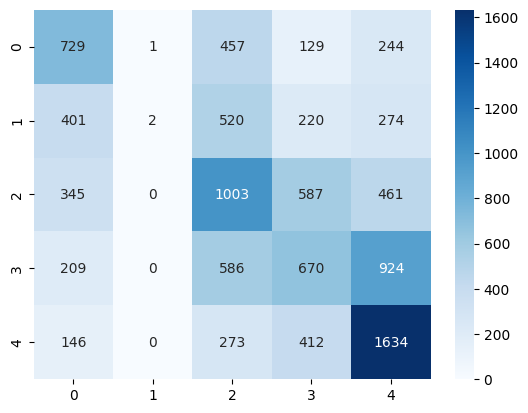

In [54]:
model_bt_nb_2 = ClassifierReLU1(128, 64, 5)
model_bt_nb_2 = model_training(model_bt_nb_2, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### ReLU2

Counter({5.0: 2423, 4.0: 2386, 3.0: 2381, 1.0: 1682, 2.0: 1355})
[epoch: 1] loss: 1.504
validation loss: 1.440, validation precision: 0.490, validation recall: 0.336, validation F1: 0.304
[epoch: 2] loss: 1.434
validation loss: 1.429, validation precision: 0.493, validation recall: 0.337, validation F1: 0.307
[epoch: 3] loss: 1.421
validation loss: 1.410, validation precision: 0.501, validation recall: 0.353, validation F1: 0.323
[epoch: 4] loss: 1.412
validation loss: 1.424, validation precision: 0.487, validation recall: 0.344, validation F1: 0.300
[epoch: 5] loss: 1.406
validation loss: 1.402, validation precision: 0.501, validation recall: 0.355, validation F1: 0.310
[epoch: 6] loss: 1.404
validation loss: 1.411, validation precision: 0.507, validation recall: 0.363, validation F1: 0.317
[epoch: 7] loss: 1.399
validation loss: 1.402, validation precision: 0.518, validation recall: 0.349, validation F1: 0.322
[epoch: 8] loss: 1.396
validation loss: 1.400, validation precision: 0.501

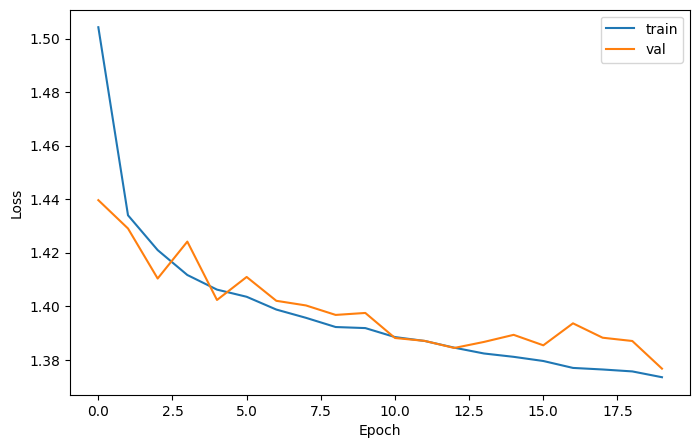

              precision    recall  f1-score   support

           1       0.39      0.52      0.44      1682
           2       1.00      0.00      0.00      1355
           3       0.34      0.45      0.39      2381
           4       0.34      0.25      0.29      2386
           5       0.48      0.62      0.54      2423

    accuracy                           0.39     10227
   macro avg       0.51      0.37      0.33     10227
weighted avg       0.47      0.39      0.36     10227



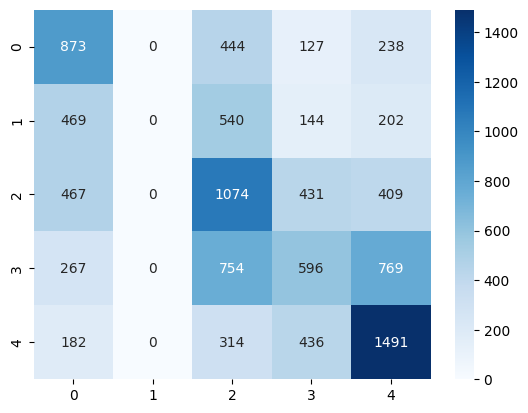

In [48]:
model_bt_nb_4 = ClassifierReLU2(128, 64, 32, 5)
model_bt_nb_4 = model_training(model_bt_nb_4, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### ReLU3

Counter({5.0: 2425, 3.0: 2407, 4.0: 2344, 1.0: 1629, 2.0: 1422})
[epoch: 1] loss: 1.510
validation loss: 1.440, validation precision: 0.492, validation recall: 0.327, validation F1: 0.306
[epoch: 2] loss: 1.434
validation loss: 1.430, validation precision: 0.515, validation recall: 0.347, validation F1: 0.317
[epoch: 3] loss: 1.417
validation loss: 1.407, validation precision: 0.515, validation recall: 0.355, validation F1: 0.325
[epoch: 4] loss: 1.411
validation loss: 1.398, validation precision: 0.505, validation recall: 0.365, validation F1: 0.327
[epoch: 5] loss: 1.402
validation loss: 1.397, validation precision: 0.517, validation recall: 0.354, validation F1: 0.326
[epoch: 6] loss: 1.399
validation loss: 1.403, validation precision: 0.491, validation recall: 0.359, validation F1: 0.301
[epoch: 7] loss: 1.393
validation loss: 1.397, validation precision: 0.529, validation recall: 0.360, validation F1: 0.331
[epoch: 8] loss: 1.392
validation loss: 1.383, validation precision: 0.520

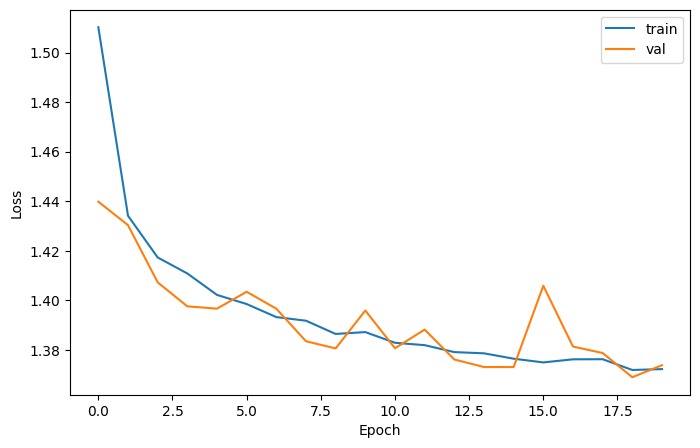

              precision    recall  f1-score   support

           1       0.44      0.40      0.42      1629
           2       1.00      0.00      0.00      1422
           3       0.33      0.52      0.40      2407
           4       0.33      0.33      0.33      2344
           5       0.52      0.56      0.54      2425

    accuracy                           0.39     10227
   macro avg       0.52      0.36      0.34     10227
weighted avg       0.48      0.39      0.36     10227



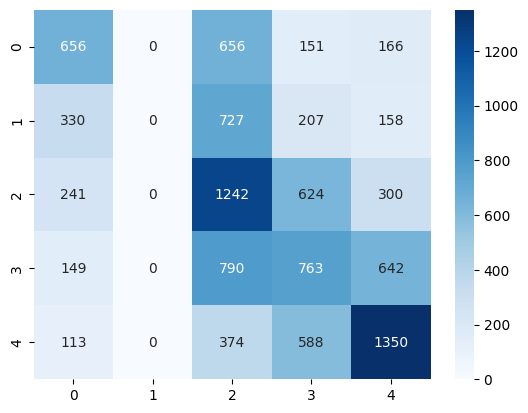

In [49]:
model_bt_nb_6 = ClassifierReLU3(128, 64, 32, 5)
model_bt_nb_6 = model_training(model_bt_nb_6, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### CNN

Counter({5.0: 2467, 3.0: 2399, 4.0: 2362, 1.0: 1621, 2.0: 1378})
[epoch: 1] loss: 1.514
validation loss: 1.464, validation precision: 0.510, validation recall: 0.307, validation F1: 0.285
[epoch: 2] loss: 1.456
validation loss: 1.430, validation precision: 0.506, validation recall: 0.342, validation F1: 0.320
[epoch: 3] loss: 1.440
validation loss: 1.419, validation precision: 0.314, validation recall: 0.340, validation F1: 0.320
[epoch: 4] loss: 1.429
validation loss: 1.412, validation precision: 0.522, validation recall: 0.347, validation F1: 0.322
[epoch: 5] loss: 1.422
validation loss: 1.408, validation precision: 0.497, validation recall: 0.360, validation F1: 0.314
[epoch: 6] loss: 1.418
validation loss: 1.400, validation precision: 0.420, validation recall: 0.369, validation F1: 0.338
[epoch: 7] loss: 1.416
validation loss: 1.395, validation precision: 0.513, validation recall: 0.368, validation F1: 0.334
[epoch: 8] loss: 1.411
validation loss: 1.402, validation precision: 0.519

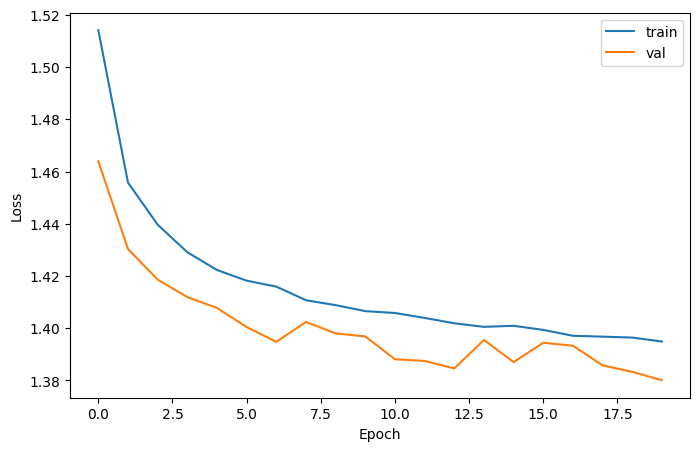

              precision    recall  f1-score   support

           1       0.39      0.55      0.45      1621
           2       0.14      0.00      0.00      1378
           3       0.34      0.47      0.40      2399
           4       0.36      0.25      0.29      2362
           5       0.50      0.60      0.54      2467

    accuracy                           0.40     10227
   macro avg       0.34      0.37      0.34     10227
weighted avg       0.36      0.40      0.36     10227



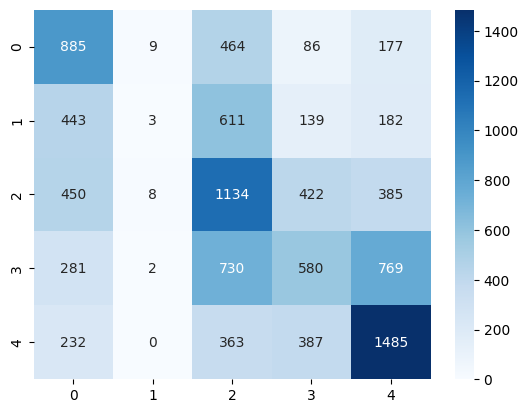

In [50]:
model_bt_nb_8 = CNN_Text(128, 5, 100, [3, 4, 5])
model_bt_nb_8 = model_training(model_bt_nb_8, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### LSTM 1

Counter({4.0: 2428, 3.0: 2405, 5.0: 2358, 1.0: 1618, 2.0: 1418})
[epoch: 1] loss: 1.520
validation loss: 1.462, validation precision: 0.471, validation recall: 0.331, validation F1: 0.281
[epoch: 2] loss: 1.444
validation loss: 1.430, validation precision: 0.500, validation recall: 0.348, validation F1: 0.311
[epoch: 3] loss: 1.427
validation loss: 1.420, validation precision: 0.510, validation recall: 0.357, validation F1: 0.328
[epoch: 4] loss: 1.419
validation loss: 1.419, validation precision: 0.503, validation recall: 0.367, validation F1: 0.318
[epoch: 5] loss: 1.414
validation loss: 1.417, validation precision: 0.514, validation recall: 0.362, validation F1: 0.321
[epoch: 6] loss: 1.410
validation loss: 1.402, validation precision: 0.511, validation recall: 0.363, validation F1: 0.331
[epoch: 7] loss: 1.405
validation loss: 1.406, validation precision: 0.509, validation recall: 0.372, validation F1: 0.327
[epoch: 8] loss: 1.404
validation loss: 1.403, validation precision: 0.522

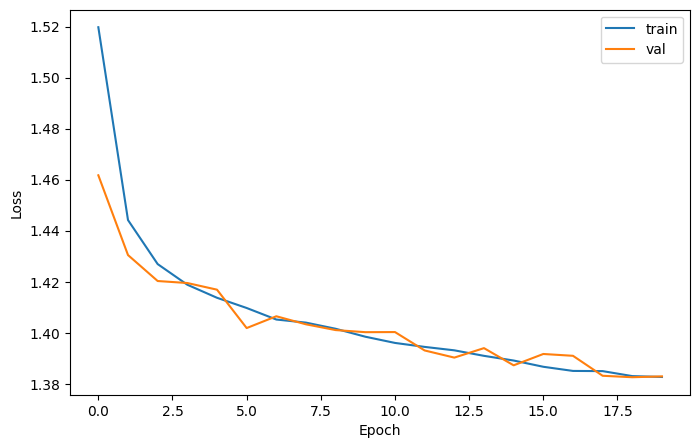

              precision    recall  f1-score   support

           1       0.37      0.54      0.44      1618
           2       0.00      0.00      0.00      1418
           3       0.34      0.49      0.40      2405
           4       0.35      0.27      0.31      2428
           5       0.53      0.56      0.54      2358

    accuracy                           0.40     10227
   macro avg       0.32      0.37      0.34     10227
weighted avg       0.34      0.40      0.36     10227



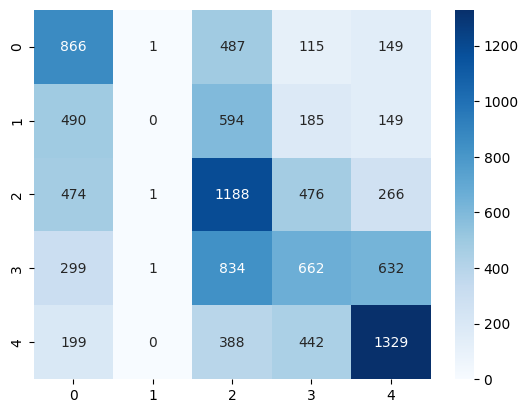

In [51]:
model_bt_nb_10 = LSTM_text(128, 64, 1, 5)
model_bt_nb_10 = model_training(model_bt_nb_10, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### LSTM 2

Counter({3.0: 2427, 4.0: 2405, 5.0: 2388, 1.0: 1603, 2.0: 1404})
[epoch: 1] loss: 1.525
validation loss: 1.445, validation precision: 0.498, validation recall: 0.328, validation F1: 0.302
[epoch: 2] loss: 1.435
validation loss: 1.408, validation precision: 0.496, validation recall: 0.347, validation F1: 0.315
[epoch: 3] loss: 1.420
validation loss: 1.406, validation precision: 0.518, validation recall: 0.358, validation F1: 0.318
[epoch: 4] loss: 1.411
validation loss: 1.425, validation precision: 0.521, validation recall: 0.363, validation F1: 0.318
[epoch: 5] loss: 1.405
validation loss: 1.401, validation precision: 0.507, validation recall: 0.352, validation F1: 0.322
[epoch: 6] loss: 1.403
validation loss: 1.397, validation precision: 0.505, validation recall: 0.361, validation F1: 0.314
[epoch: 7] loss: 1.399
validation loss: 1.391, validation precision: 0.508, validation recall: 0.376, validation F1: 0.324
[epoch: 8] loss: 1.396
validation loss: 1.395, validation precision: 0.505

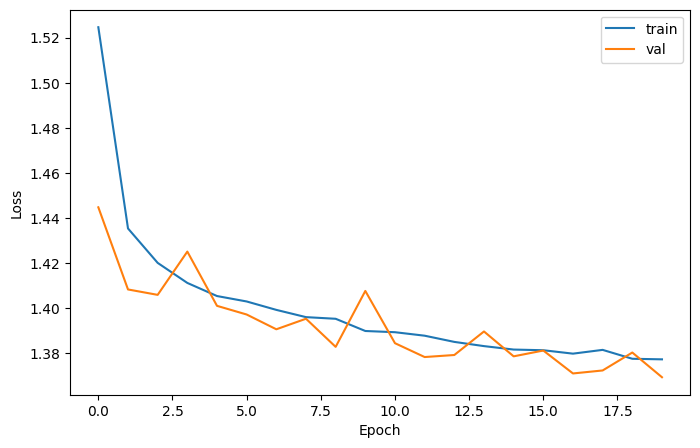

              precision    recall  f1-score   support

           1       0.39      0.48      0.43      1603
           2       1.00      0.00      0.00      1404
           3       0.34      0.51      0.41      2427
           4       0.36      0.28      0.31      2405
           5       0.52      0.59      0.55      2388

    accuracy                           0.40     10227
   macro avg       0.52      0.37      0.34     10227
weighted avg       0.48      0.40      0.37     10227



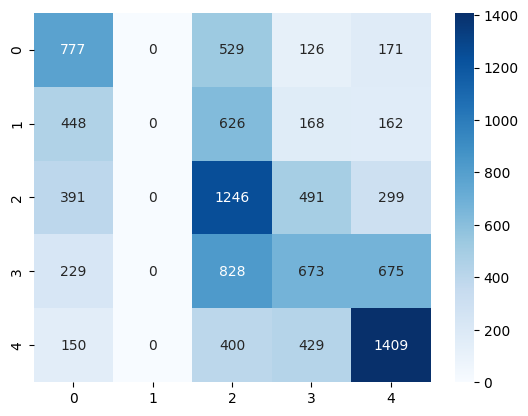

In [52]:
model_bt_nb_12 = LSTM_text(128, 64, 2, 5)
model_bt_nb_12 = model_training(model_bt_nb_12, 20, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

### Transformer

Counter({5.0: 2426, 4.0: 2369, 3.0: 2365, 1.0: 1651, 2.0: 1416})
[epoch: 1] loss: 1.479
validation loss: 1.461, validation precision: 0.489, validation recall: 0.330, validation F1: 0.300
[epoch: 2] loss: 1.421
validation loss: 1.442, validation precision: 0.483, validation recall: 0.346, validation F1: 0.302
[epoch: 3] loss: 1.411
validation loss: 1.437, validation precision: 0.492, validation recall: 0.342, validation F1: 0.313
[epoch: 4] loss: 1.405
validation loss: 1.427, validation precision: 0.353, validation recall: 0.339, validation F1: 0.302
[epoch: 5] loss: 1.399
validation loss: 1.423, validation precision: 0.319, validation recall: 0.350, validation F1: 0.285
[epoch: 6] loss: 1.395
validation loss: 1.428, validation precision: 0.382, validation recall: 0.345, validation F1: 0.320
[epoch: 7] loss: 1.394
validation loss: 1.425, validation precision: 0.373, validation recall: 0.347, validation F1: 0.323
[epoch: 8] loss: 1.390
validation loss: 1.424, validation precision: 0.500

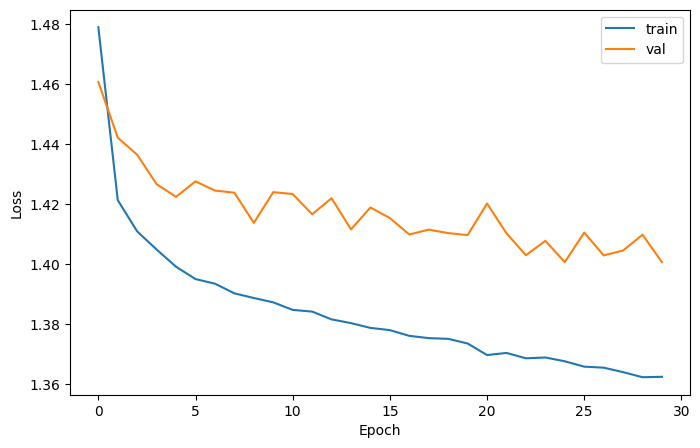

              precision    recall  f1-score   support

           1       0.39      0.51      0.44      1651
           2       1.00      0.00      0.00      1416
           3       0.34      0.41      0.37      2365
           4       0.33      0.39      0.36      2369
           5       0.53      0.52      0.53      2426

    accuracy                           0.39     10227
   macro avg       0.52      0.37      0.34     10227
weighted avg       0.48      0.39      0.37     10227



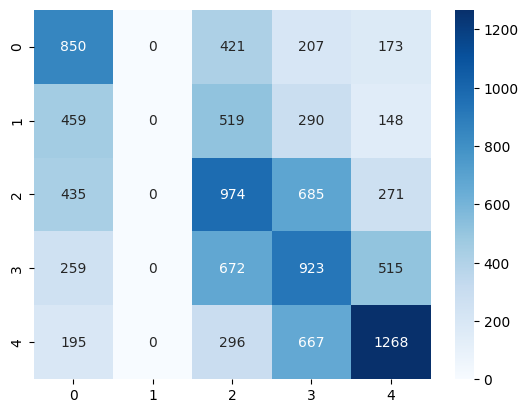

In [53]:
model_bt_nb_14 = TransformerClassifier(128, 5, 2, 8, 64, dropout=0.1)
model_bt_nb_14 = model_training(model_bt_nb_14, 30, 0.001, 32, df_such_no_bal, 'bert-tiny', 'rating')

# **Русский** **текст**

## Подготовка

In [147]:
df_ru_la = pd.read_csv('/content/drive/MyDrive/cw_classifier/ru_LaBASE.csv')
df_ru_bt = pd.read_csv('/content/drive/MyDrive/cw_classifier/ru_bert.csv')

In [152]:
df_ru_la['LaBASE'] = df_ru_la['LaBASE'].apply(lambda x: np.fromstring(x[1:-1], sep=','))

In [153]:
df_ru_bt['bert'] = df_ru_bt['bert'].apply(lambda x: np.fromstring(x[2:-2].replace('\n', ' '), sep=' '))

In [157]:
len(df_ru_bt['bert'].iloc[0])

312

## ReLU1

Counter({3: 813, 5: 781, 4: 770, 2: 385, 1: 255})
[epoch: 1] loss: 1.238
validation loss: 1.169, validation precision: 0.455, validation recall: 0.450, validation F1: 0.435
[epoch: 2] loss: 1.135
validation loss: 1.149, validation precision: 0.465, validation recall: 0.455, validation F1: 0.446
[epoch: 3] loss: 1.119
validation loss: 1.146, validation precision: 0.482, validation recall: 0.447, validation F1: 0.453
[epoch: 4] loss: 1.106
validation loss: 1.142, validation precision: 0.469, validation recall: 0.467, validation F1: 0.458
[epoch: 5] loss: 1.094
validation loss: 1.154, validation precision: 0.454, validation recall: 0.469, validation F1: 0.453
[epoch: 6] loss: 1.086
validation loss: 1.145, validation precision: 0.476, validation recall: 0.459, validation F1: 0.454
[epoch: 7] loss: 1.073
validation loss: 1.155, validation precision: 0.462, validation recall: 0.452, validation F1: 0.443
[epoch: 8] loss: 1.061
validation loss: 1.147, validation precision: 0.460, validation re

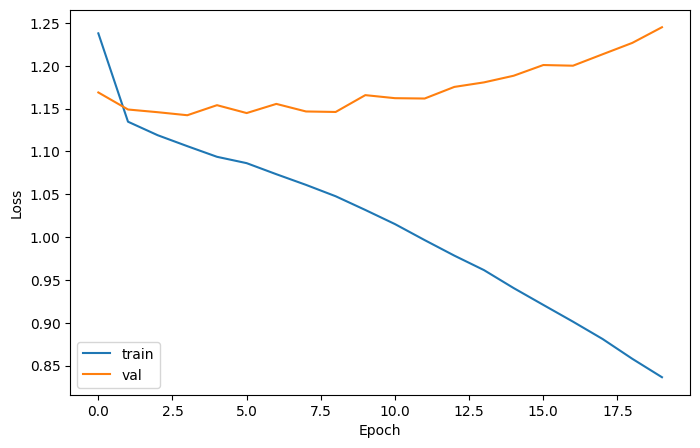

              precision    recall  f1-score   support

           1       0.48      0.52      0.50       255
           2       0.37      0.15      0.21       385
           3       0.45      0.45      0.45       813
           4       0.38      0.46      0.42       770
           5       0.58      0.62      0.60       781

    accuracy                           0.46      3004
   macro avg       0.45      0.44      0.44      3004
weighted avg       0.46      0.46      0.45      3004



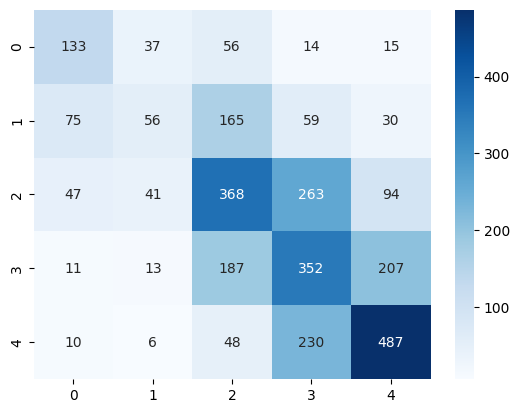

In [158]:
model_la_1 = ClassifierReLU1(768, 256, 5)
model_la_1 = model_training(model_la_1, 20, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({5: 819, 3: 806, 4: 793, 2: 334, 1: 252})
[epoch: 1] loss: 1.260
validation loss: 1.107, validation precision: 0.502, validation recall: 0.473, validation F1: 0.483
[epoch: 2] loss: 1.080
validation loss: 1.073, validation precision: 0.487, validation recall: 0.473, validation F1: 0.454
[epoch: 3] loss: 1.053
validation loss: 1.058, validation precision: 0.501, validation recall: 0.490, validation F1: 0.490
[epoch: 4] loss: 1.040
validation loss: 1.055, validation precision: 0.532, validation recall: 0.493, validation F1: 0.504
[epoch: 5] loss: 1.033
validation loss: 1.050, validation precision: 0.497, validation recall: 0.493, validation F1: 0.490
[epoch: 6] loss: 1.024
validation loss: 1.058, validation precision: 0.516, validation recall: 0.504, validation F1: 0.504
[epoch: 7] loss: 1.021
validation loss: 1.044, validation precision: 0.522, validation recall: 0.490, validation F1: 0.500
[epoch: 8] loss: 1.013
validation loss: 1.040, validation precision: 0.510, validation re

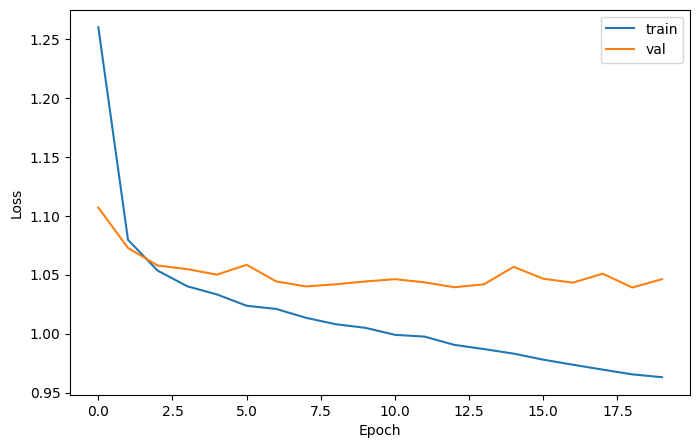

              precision    recall  f1-score   support

           1       0.48      0.57      0.52       252
           2       0.41      0.28      0.34       334
           3       0.50      0.55      0.52       806
           4       0.46      0.47      0.46       793
           5       0.68      0.64      0.66       819

    accuracy                           0.53      3004
   macro avg       0.51      0.50      0.50      3004
weighted avg       0.53      0.53      0.52      3004



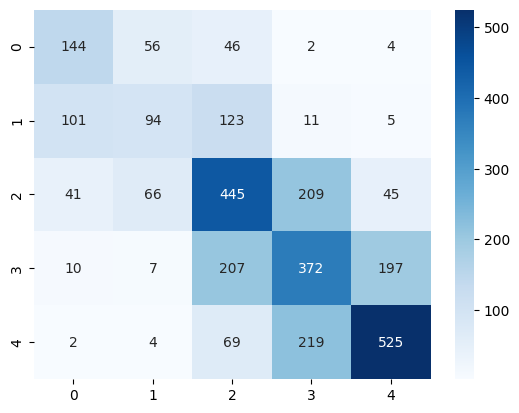

In [159]:
model_bt_2 = ClassifierReLU1(312, 128, 5)
model_bt_2 = model_training(model_bt_2, 20, 0.001, 32, df_ru_bt, 'bert', 'rating')

## ReLU2

Counter({4: 797, 5: 792, 3: 787, 2: 371, 1: 257})
[epoch: 1] loss: 1.237
validation loss: 1.157, validation precision: 0.453, validation recall: 0.451, validation F1: 0.421
[epoch: 2] loss: 1.136
validation loss: 1.156, validation precision: 0.442, validation recall: 0.473, validation F1: 0.437
[epoch: 3] loss: 1.122
validation loss: 1.133, validation precision: 0.479, validation recall: 0.470, validation F1: 0.470
[epoch: 4] loss: 1.109
validation loss: 1.141, validation precision: 0.447, validation recall: 0.463, validation F1: 0.442
[epoch: 5] loss: 1.098
validation loss: 1.128, validation precision: 0.489, validation recall: 0.474, validation F1: 0.477
[epoch: 6] loss: 1.086
validation loss: 1.131, validation precision: 0.498, validation recall: 0.463, validation F1: 0.475
[epoch: 7] loss: 1.068
validation loss: 1.138, validation precision: 0.470, validation recall: 0.466, validation F1: 0.457
[epoch: 8] loss: 1.047
validation loss: 1.142, validation precision: 0.487, validation re

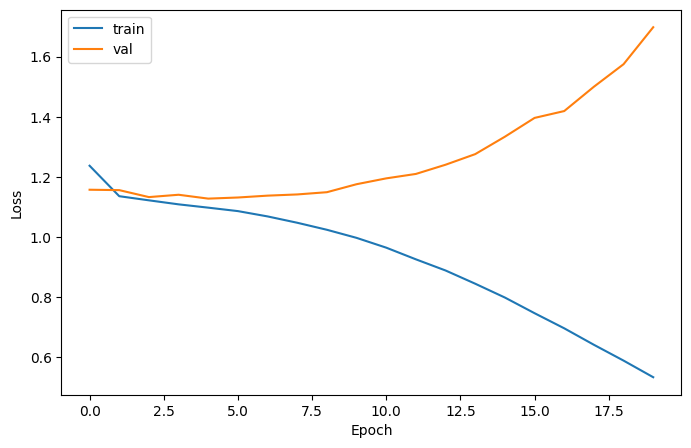

              precision    recall  f1-score   support

           1       0.39      0.56      0.46       257
           2       0.31      0.21      0.25       371
           3       0.41      0.48      0.44       787
           4       0.41      0.40      0.40       797
           5       0.60      0.52      0.56       792

    accuracy                           0.44      3004
   macro avg       0.42      0.43      0.42      3004
weighted avg       0.45      0.44      0.44      3004



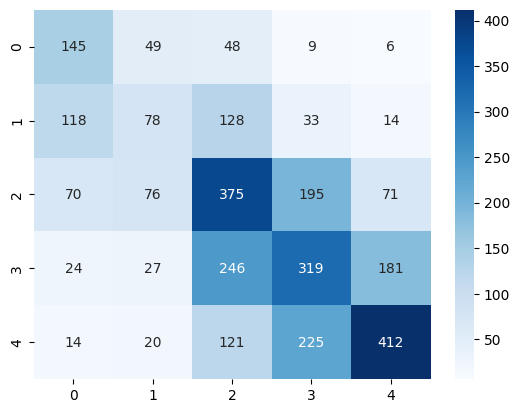

In [160]:
model_la_3 = ClassifierReLU2(768, 256, 64, 5)
model_la_3 = model_training(model_la_3, 20, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({5: 855, 3: 794, 4: 739, 2: 341, 1: 275})
[epoch: 1] loss: 1.232
validation loss: 1.101, validation precision: 0.500, validation recall: 0.461, validation F1: 0.459
[epoch: 2] loss: 1.076
validation loss: 1.049, validation precision: 0.552, validation recall: 0.497, validation F1: 0.511
[epoch: 3] loss: 1.053
validation loss: 1.040, validation precision: 0.521, validation recall: 0.508, validation F1: 0.507
[epoch: 4] loss: 1.045
validation loss: 1.025, validation precision: 0.534, validation recall: 0.527, validation F1: 0.527
[epoch: 5] loss: 1.034
validation loss: 1.035, validation precision: 0.554, validation recall: 0.494, validation F1: 0.510
[epoch: 6] loss: 1.028
validation loss: 1.019, validation precision: 0.533, validation recall: 0.512, validation F1: 0.512
[epoch: 7] loss: 1.021
validation loss: 1.030, validation precision: 0.538, validation recall: 0.499, validation F1: 0.473
[epoch: 8] loss: 1.017
validation loss: 1.026, validation precision: 0.554, validation re

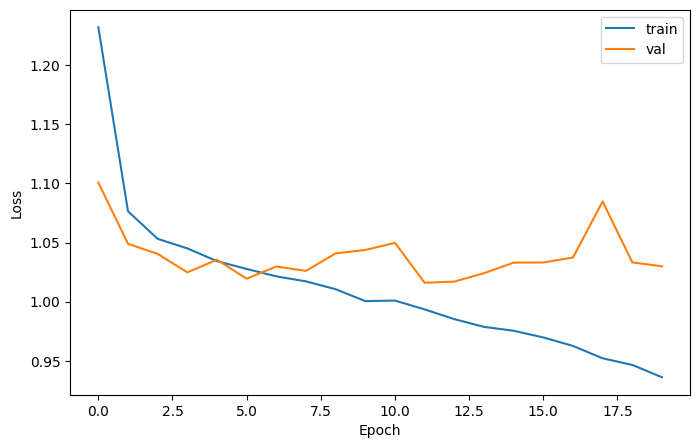

              precision    recall  f1-score   support

           1       0.55      0.70      0.62       275
           2       0.43      0.29      0.35       341
           3       0.53      0.53      0.53       794
           4       0.45      0.45      0.45       739
           5       0.67      0.69      0.68       855

    accuracy                           0.54      3004
   macro avg       0.52      0.53      0.52      3004
weighted avg       0.54      0.54      0.54      3004



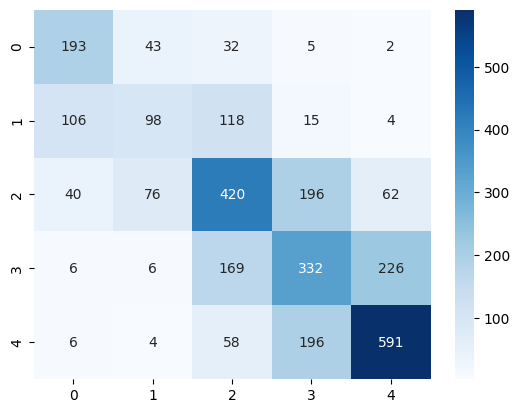

In [161]:
model_bt_4 = ClassifierReLU2(312, 128, 64, 5)
model_bt_4 = model_training(model_bt_4, 20, 0.001, 32, df_ru_bt, 'bert', 'rating')

## ReLU3

Counter({4: 838, 3: 797, 5: 790, 2: 323, 1: 256})
[epoch: 1] loss: 1.252
validation loss: 1.149, validation precision: 0.503, validation recall: 0.448, validation F1: 0.464
[epoch: 2] loss: 1.146
validation loss: 1.138, validation precision: 0.485, validation recall: 0.456, validation F1: 0.452
[epoch: 3] loss: 1.127
validation loss: 1.137, validation precision: 0.477, validation recall: 0.446, validation F1: 0.433
[epoch: 4] loss: 1.112
validation loss: 1.125, validation precision: 0.486, validation recall: 0.458, validation F1: 0.464
[epoch: 5] loss: 1.099
validation loss: 1.141, validation precision: 0.481, validation recall: 0.453, validation F1: 0.438
[epoch: 6] loss: 1.078
validation loss: 1.160, validation precision: 0.464, validation recall: 0.466, validation F1: 0.457
[epoch: 7] loss: 1.059
validation loss: 1.129, validation precision: 0.461, validation recall: 0.454, validation F1: 0.452
[epoch: 8] loss: 1.035
validation loss: 1.145, validation precision: 0.475, validation re

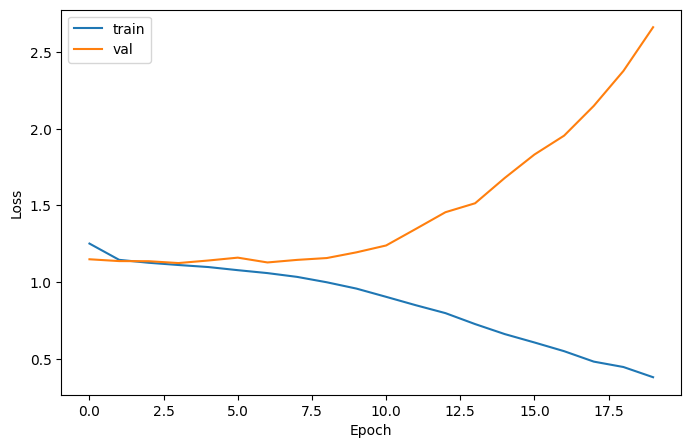

              precision    recall  f1-score   support

           1       0.50      0.35      0.41       256
           2       0.24      0.35      0.29       323
           3       0.42      0.41      0.41       797
           4       0.42      0.36      0.39       838
           5       0.56      0.61      0.58       790

    accuracy                           0.44      3004
   macro avg       0.43      0.41      0.42      3004
weighted avg       0.44      0.44      0.44      3004



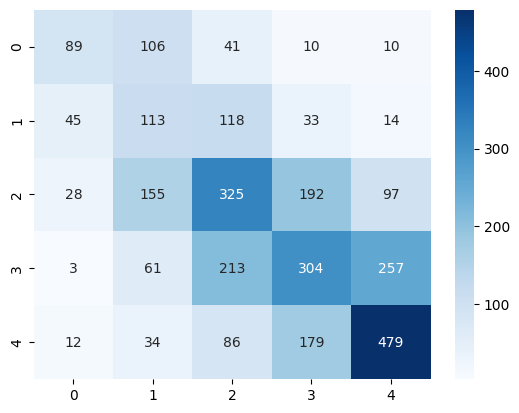

In [162]:
model_la_5 = ClassifierReLU3(768, 256, 64, 5)
model_la_5 = model_training(model_la_5, 20, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({3: 808, 4: 798, 5: 793, 2: 340, 1: 265})
[epoch: 1] loss: 1.232
validation loss: 1.087, validation precision: 0.467, validation recall: 0.485, validation F1: 0.445
[epoch: 2] loss: 1.070
validation loss: 1.073, validation precision: 0.506, validation recall: 0.508, validation F1: 0.494
[epoch: 3] loss: 1.050
validation loss: 1.070, validation precision: 0.515, validation recall: 0.472, validation F1: 0.479
[epoch: 4] loss: 1.037
validation loss: 1.050, validation precision: 0.511, validation recall: 0.514, validation F1: 0.508
[epoch: 5] loss: 1.029
validation loss: 1.072, validation precision: 0.506, validation recall: 0.525, validation F1: 0.509
[epoch: 6] loss: 1.023
validation loss: 1.046, validation precision: 0.507, validation recall: 0.514, validation F1: 0.507
[epoch: 7] loss: 1.016
validation loss: 1.053, validation precision: 0.528, validation recall: 0.511, validation F1: 0.515
[epoch: 8] loss: 1.007
validation loss: 1.055, validation precision: 0.508, validation re

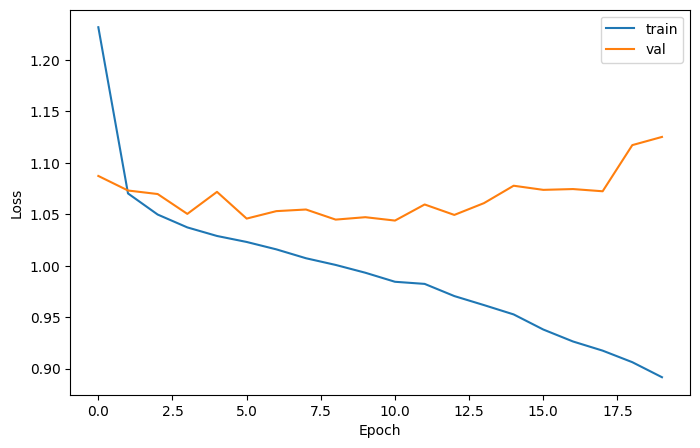

              precision    recall  f1-score   support

           1       0.58      0.57      0.58       265
           2       0.37      0.32      0.35       340
           3       0.50      0.38      0.43       808
           4       0.45      0.48      0.46       798
           5       0.62      0.76      0.68       793

    accuracy                           0.52      3004
   macro avg       0.50      0.50      0.50      3004
weighted avg       0.51      0.52      0.51      3004



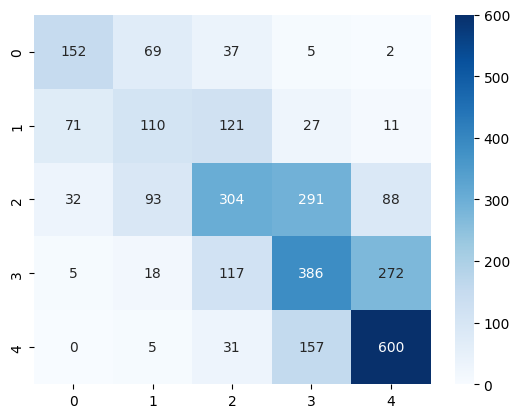

In [163]:
model_bt_6 = ClassifierReLU3(312, 128, 64, 5)
model_bt_6 = model_training(model_bt_6, 20, 0.001, 32, df_ru_bt, 'bert', 'rating')

## CNN

Counter({4: 806, 3: 795, 5: 794, 2: 348, 1: 261})
[epoch: 1] loss: 1.258
validation loss: 1.151, validation precision: 0.476, validation recall: 0.459, validation F1: 0.442
[epoch: 2] loss: 1.151
validation loss: 1.137, validation precision: 0.477, validation recall: 0.483, validation F1: 0.463
[epoch: 3] loss: 1.137
validation loss: 1.128, validation precision: 0.479, validation recall: 0.473, validation F1: 0.468
[epoch: 4] loss: 1.121
validation loss: 1.130, validation precision: 0.490, validation recall: 0.453, validation F1: 0.456
[epoch: 5] loss: 1.115
validation loss: 1.132, validation precision: 0.483, validation recall: 0.458, validation F1: 0.464
[epoch: 6] loss: 1.100
validation loss: 1.129, validation precision: 0.476, validation recall: 0.479, validation F1: 0.468
[epoch: 7] loss: 1.091
validation loss: 1.125, validation precision: 0.482, validation recall: 0.484, validation F1: 0.478
[epoch: 8] loss: 1.081
validation loss: 1.125, validation precision: 0.485, validation re

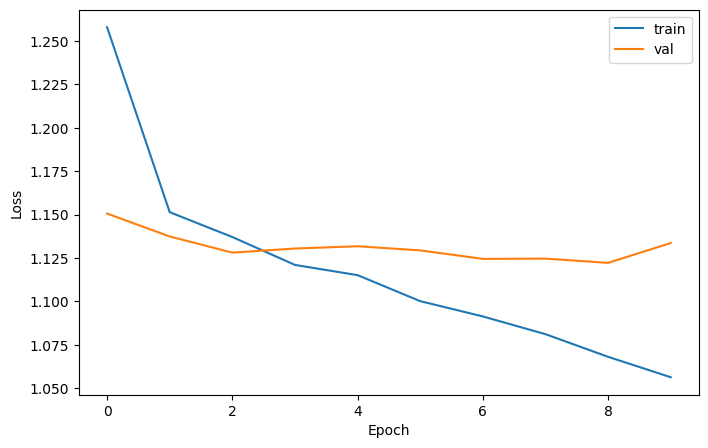

              precision    recall  f1-score   support

           1       0.57      0.46      0.51       261
           2       0.33      0.17      0.23       348
           3       0.43      0.52      0.47       795
           4       0.45      0.47      0.46       806
           5       0.63      0.64      0.64       794

    accuracy                           0.49      3004
   macro avg       0.48      0.45      0.46      3004
weighted avg       0.49      0.49      0.49      3004



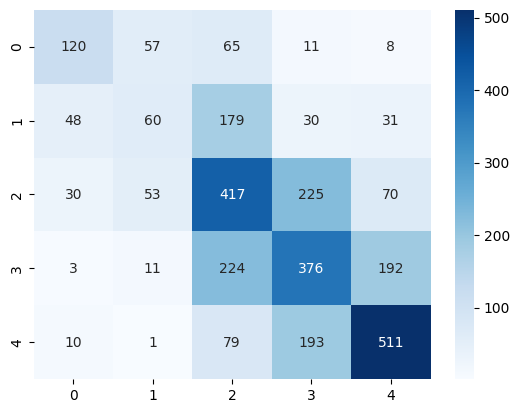

In [164]:
model_la_7 = CNN_Text(768, 5, 100, [3, 4, 5])
model_la_7 = model_training(model_la_7, 10, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({4: 812, 3: 794, 5: 779, 2: 364, 1: 255})
[epoch: 1] loss: 1.254
validation loss: 1.096, validation precision: 0.478, validation recall: 0.460, validation F1: 0.443
[epoch: 2] loss: 1.098
validation loss: 1.074, validation precision: 0.496, validation recall: 0.455, validation F1: 0.466
[epoch: 3] loss: 1.070
validation loss: 1.057, validation precision: 0.495, validation recall: 0.509, validation F1: 0.499
[epoch: 4] loss: 1.056
validation loss: 1.056, validation precision: 0.505, validation recall: 0.502, validation F1: 0.487
[epoch: 5] loss: 1.046
validation loss: 1.043, validation precision: 0.510, validation recall: 0.508, validation F1: 0.499
[epoch: 6] loss: 1.039
validation loss: 1.059, validation precision: 0.488, validation recall: 0.490, validation F1: 0.472
[epoch: 7] loss: 1.036
validation loss: 1.061, validation precision: 0.536, validation recall: 0.493, validation F1: 0.502
[epoch: 8] loss: 1.028
validation loss: 1.051, validation precision: 0.514, validation re

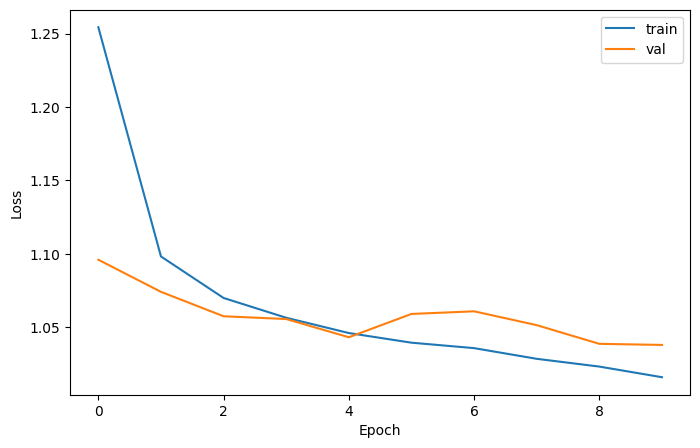

              precision    recall  f1-score   support

           1       0.53      0.52      0.52       255
           2       0.39      0.20      0.27       364
           3       0.48      0.55      0.51       794
           4       0.46      0.53      0.50       812
           5       0.67      0.61      0.64       779

    accuracy                           0.52      3004
   macro avg       0.50      0.48      0.49      3004
weighted avg       0.52      0.52      0.51      3004



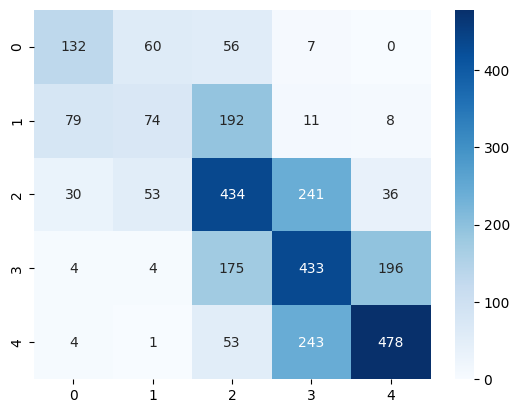

In [165]:
model_bt_8 = CNN_Text(312, 5, 100, [3, 4, 5])
model_bt_8 = model_training(model_bt_8, 10, 0.001, 32, df_ru_bt, 'bert', 'rating')

## LSTM 1

Counter({4: 802, 5: 802, 3: 780, 2: 365, 1: 255})
[epoch: 1] loss: 1.267
validation loss: 1.222, validation precision: 0.460, validation recall: 0.404, validation F1: 0.396
[epoch: 2] loss: 1.144
validation loss: 1.171, validation precision: 0.436, validation recall: 0.433, validation F1: 0.422
[epoch: 3] loss: 1.130
validation loss: 1.067, validation precision: 0.496, validation recall: 0.465, validation F1: 0.452
[epoch: 4] loss: 1.121
validation loss: 1.104, validation precision: 0.465, validation recall: 0.476, validation F1: 0.459
[epoch: 5] loss: 1.111
validation loss: 1.124, validation precision: 0.475, validation recall: 0.443, validation F1: 0.447
[epoch: 6] loss: 1.102
validation loss: 1.142, validation precision: 0.453, validation recall: 0.451, validation F1: 0.436
[epoch: 7] loss: 1.101
validation loss: 1.162, validation precision: 0.473, validation recall: 0.444, validation F1: 0.442
[epoch: 8] loss: 1.095
validation loss: 1.173, validation precision: 0.462, validation re

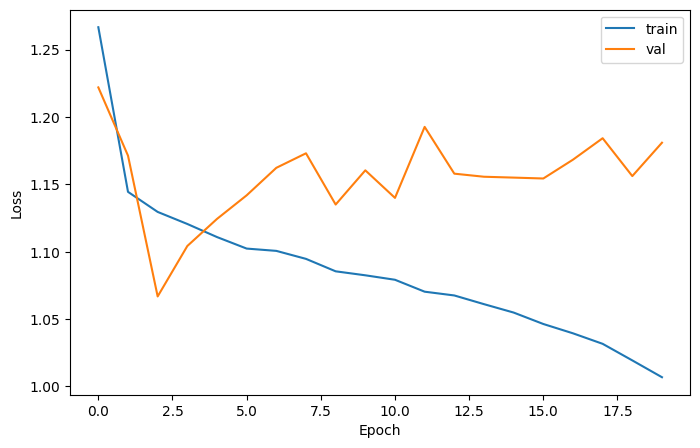

              precision    recall  f1-score   support

           1       0.48      0.48      0.48       255
           2       0.35      0.22      0.27       365
           3       0.42      0.55      0.48       780
           4       0.46      0.39      0.42       802
           5       0.58      0.60      0.59       802

    accuracy                           0.47      3004
   macro avg       0.46      0.45      0.45      3004
weighted avg       0.47      0.47      0.47      3004



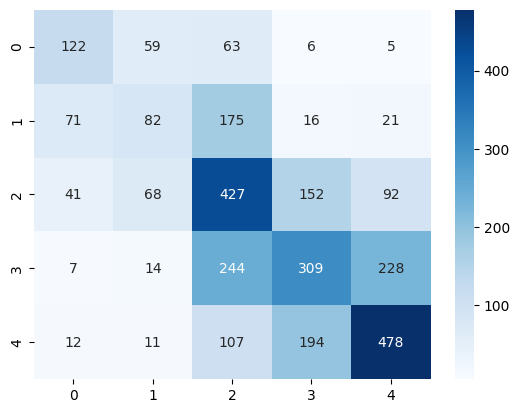

In [166]:
model_la_9 = LSTM_text(768, 256, 1, 5)
model_la_9 = model_training(model_la_9, 20, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({3: 802, 5: 800, 4: 799, 2: 362, 1: 241})
[epoch: 1] loss: 1.316
validation loss: 1.146, validation precision: 0.373, validation recall: 0.424, validation F1: 0.389
[epoch: 2] loss: 1.098
validation loss: 1.081, validation precision: 0.494, validation recall: 0.477, validation F1: 0.477
[epoch: 3] loss: 1.065
validation loss: 1.073, validation precision: 0.474, validation recall: 0.482, validation F1: 0.467
[epoch: 4] loss: 1.051
validation loss: 1.053, validation precision: 0.496, validation recall: 0.488, validation F1: 0.486
[epoch: 5] loss: 1.044
validation loss: 1.055, validation precision: 0.493, validation recall: 0.513, validation F1: 0.493
[epoch: 6] loss: 1.038
validation loss: 1.048, validation precision: 0.517, validation recall: 0.485, validation F1: 0.495
[epoch: 7] loss: 1.033
validation loss: 1.095, validation precision: 0.479, validation recall: 0.481, validation F1: 0.472
[epoch: 8] loss: 1.026
validation loss: 1.077, validation precision: 0.483, validation re

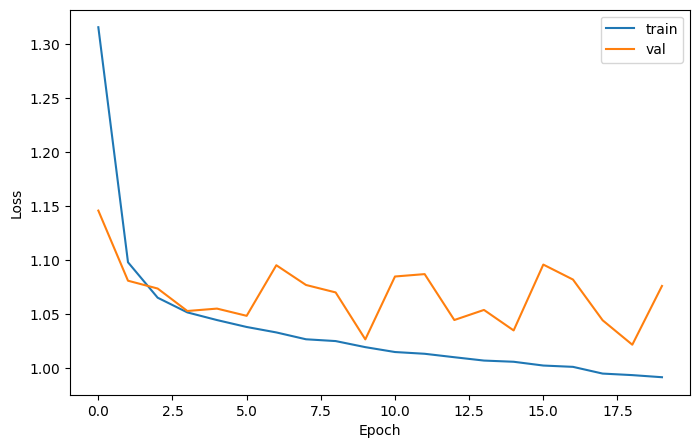

              precision    recall  f1-score   support

           1       0.56      0.49      0.53       241
           2       0.37      0.25      0.30       362
           3       0.48      0.59      0.53       802
           4       0.47      0.40      0.43       799
           5       0.61      0.67      0.64       800

    accuracy                           0.51      3004
   macro avg       0.50      0.48      0.48      3004
weighted avg       0.50      0.51      0.50      3004



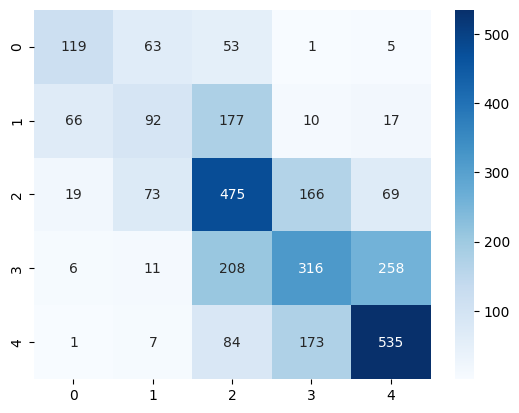

In [167]:
model_bt_10 = LSTM_text(312, 128, 1, 5)
model_bt_10 = model_training(model_bt_10, 20, 0.001, 32, df_ru_bt, 'bert', 'rating')

## LSTM 2

Counter({3: 812, 4: 788, 5: 787, 2: 321, 1: 296})
[epoch: 1] loss: 1.295
validation loss: 1.199, validation precision: 0.423, validation recall: 0.420, validation F1: 0.405
[epoch: 2] loss: 1.150
validation loss: 1.159, validation precision: 0.453, validation recall: 0.446, validation F1: 0.431
[epoch: 3] loss: 1.134
validation loss: 1.148, validation precision: 0.458, validation recall: 0.449, validation F1: 0.442
[epoch: 4] loss: 1.122
validation loss: 1.200, validation precision: 0.425, validation recall: 0.437, validation F1: 0.424
[epoch: 5] loss: 1.115
validation loss: 1.123, validation precision: 0.459, validation recall: 0.475, validation F1: 0.455
[epoch: 6] loss: 1.110
validation loss: 1.089, validation precision: 0.490, validation recall: 0.470, validation F1: 0.477
[epoch: 7] loss: 1.103
validation loss: 1.190, validation precision: 0.435, validation recall: 0.408, validation F1: 0.411
[epoch: 8] loss: 1.098
validation loss: 1.149, validation precision: 0.457, validation re

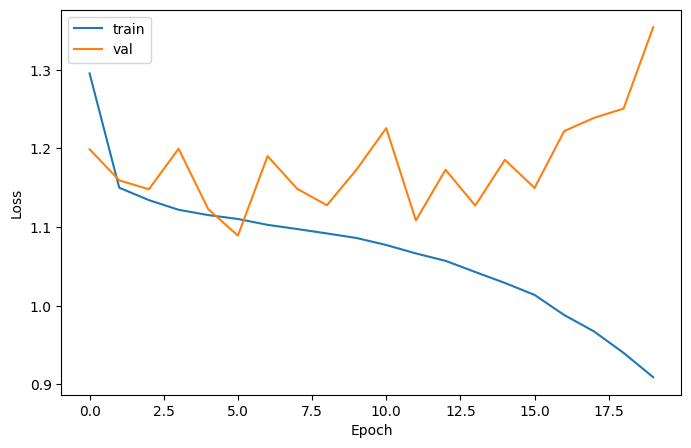

              precision    recall  f1-score   support

           1       0.47      0.42      0.44       296
           2       0.24      0.34      0.28       321
           3       0.40      0.55      0.46       812
           4       0.43      0.22      0.30       788
           5       0.58      0.57      0.58       787

    accuracy                           0.43      3004
   macro avg       0.42      0.42      0.41      3004
weighted avg       0.45      0.43      0.43      3004



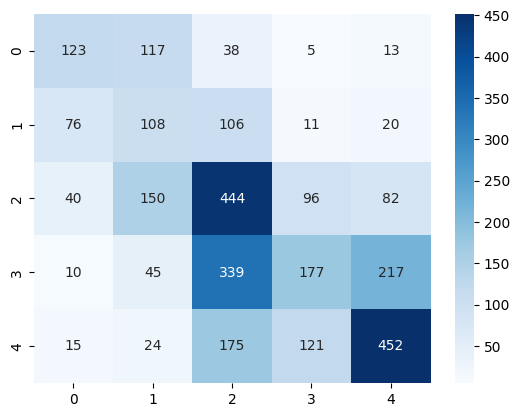

In [168]:
model_la_11 = LSTM_text(768, 256, 2, 5)
model_la_11 = model_training(model_la_11, 20, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({3: 817, 5: 797, 4: 776, 2: 354, 1: 260})
[epoch: 1] loss: 1.327
validation loss: 1.228, validation precision: 0.405, validation recall: 0.361, validation F1: 0.356
[epoch: 2] loss: 1.090
validation loss: 1.119, validation precision: 0.478, validation recall: 0.479, validation F1: 0.456
[epoch: 3] loss: 1.066
validation loss: 1.072, validation precision: 0.493, validation recall: 0.459, validation F1: 0.451
[epoch: 4] loss: 1.053
validation loss: 1.107, validation precision: 0.483, validation recall: 0.479, validation F1: 0.477
[epoch: 5] loss: 1.040
validation loss: 1.038, validation precision: 0.518, validation recall: 0.523, validation F1: 0.517
[epoch: 6] loss: 1.039
validation loss: 1.067, validation precision: 0.528, validation recall: 0.477, validation F1: 0.490
[epoch: 7] loss: 1.034
validation loss: 1.065, validation precision: 0.509, validation recall: 0.506, validation F1: 0.506
[epoch: 8] loss: 1.030
validation loss: 1.072, validation precision: 0.511, validation re

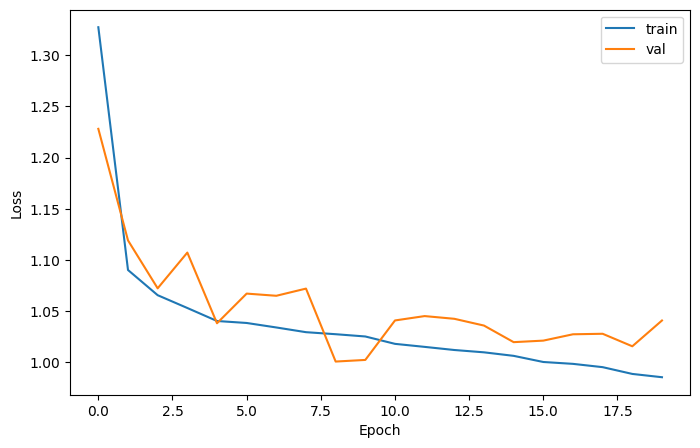

              precision    recall  f1-score   support

           1       0.59      0.54      0.56       260
           2       0.45      0.34      0.39       354
           3       0.51      0.57      0.53       817
           4       0.46      0.51      0.48       776
           5       0.68      0.62      0.65       797

    accuracy                           0.54      3004
   macro avg       0.54      0.52      0.52      3004
weighted avg       0.54      0.54      0.54      3004



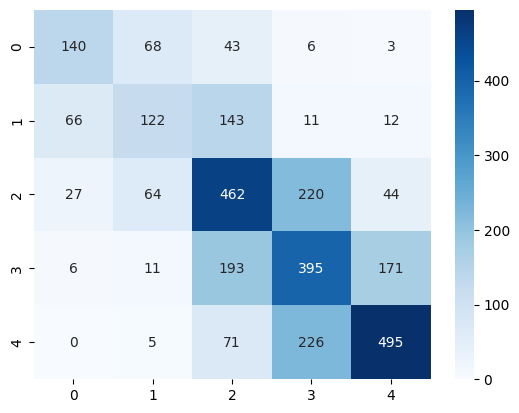

In [169]:
model_bt_12 = LSTM_text(312, 128, 2, 5)
model_bt_12 = model_training(model_bt_12, 20, 0.001, 32, df_ru_bt, 'bert', 'rating')

## Transformer

Counter({5: 814, 3: 802, 4: 789, 2: 360, 1: 239})
[epoch: 1] loss: 1.303
validation loss: 1.277, validation precision: 0.433, validation recall: 0.389, validation F1: 0.380
[epoch: 2] loss: 1.186
validation loss: 1.274, validation precision: 0.426, validation recall: 0.386, validation F1: 0.389
[epoch: 3] loss: 1.162
validation loss: 1.221, validation precision: 0.478, validation recall: 0.434, validation F1: 0.399
[epoch: 4] loss: 1.149
validation loss: 1.195, validation precision: 0.440, validation recall: 0.388, validation F1: 0.377
[epoch: 5] loss: 1.145
validation loss: 1.183, validation precision: 0.475, validation recall: 0.420, validation F1: 0.423
[epoch: 6] loss: 1.139
validation loss: 1.235, validation precision: 0.455, validation recall: 0.396, validation F1: 0.399
[epoch: 7] loss: 1.142
validation loss: 1.268, validation precision: 0.401, validation recall: 0.395, validation F1: 0.384
[epoch: 8] loss: 1.133
validation loss: 1.283, validation precision: 0.370, validation re

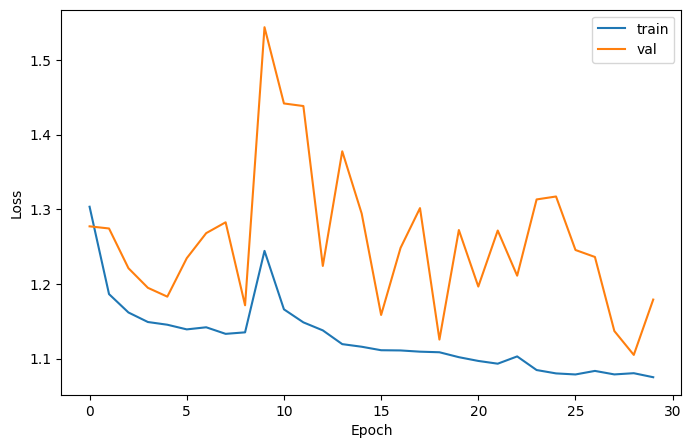

              precision    recall  f1-score   support

           1       0.47      0.40      0.43       239
           2       0.27      0.07      0.11       360
           3       0.41      0.59      0.49       802
           4       0.43      0.50      0.46       789
           5       0.72      0.58      0.64       814

    accuracy                           0.48      3004
   macro avg       0.46      0.43      0.43      3004
weighted avg       0.49      0.48      0.47      3004



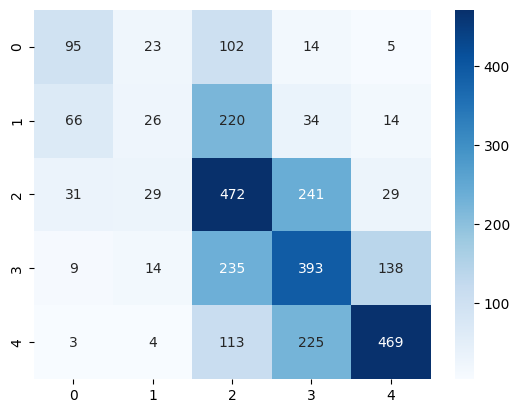

In [170]:
model_la_13 = TransformerClassifier(768, 5, 2, 8, 256, dropout=0.1)
model_la_13 = model_training(model_la_13, 30, 0.001, 32, df_ru_la, 'LaBASE', 'rating')

Counter({3: 819, 5: 792, 4: 770, 2: 356, 1: 267})
[epoch: 1] loss: 1.279
validation loss: 1.359, validation precision: 0.348, validation recall: 0.296, validation F1: 0.284
[epoch: 2] loss: 1.101
validation loss: 1.355, validation precision: 0.407, validation recall: 0.363, validation F1: 0.346
[epoch: 3] loss: 1.081
validation loss: 1.199, validation precision: 0.442, validation recall: 0.428, validation F1: 0.392
[epoch: 4] loss: 1.056
validation loss: 1.331, validation precision: 0.390, validation recall: 0.397, validation F1: 0.390
[epoch: 5] loss: 1.052
validation loss: 1.269, validation precision: 0.419, validation recall: 0.421, validation F1: 0.410
[epoch: 6] loss: 1.050
validation loss: 1.303, validation precision: 0.446, validation recall: 0.378, validation F1: 0.364
[epoch: 7] loss: 1.042
validation loss: 1.213, validation precision: 0.471, validation recall: 0.450, validation F1: 0.454
[epoch: 8] loss: 1.038
validation loss: 1.168, validation precision: 0.434, validation re

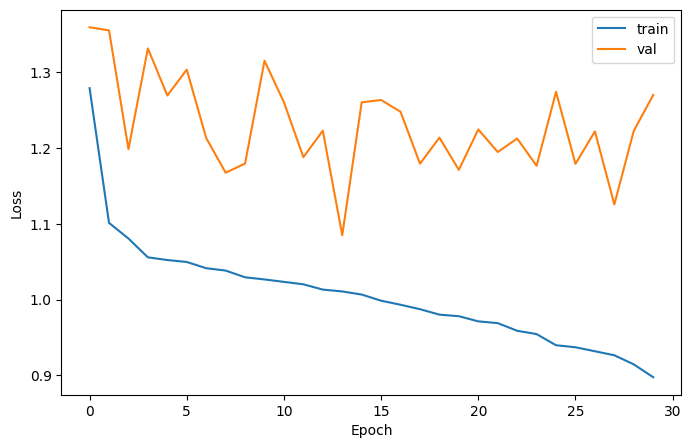

              precision    recall  f1-score   support

           1       0.53      0.47      0.50       267
           2       0.32      0.49      0.39       356
           3       0.45      0.45      0.45       819
           4       0.45      0.29      0.36       770
           5       0.58      0.67      0.62       792

    accuracy                           0.47      3004
   macro avg       0.47      0.47      0.46      3004
weighted avg       0.48      0.47      0.47      3004



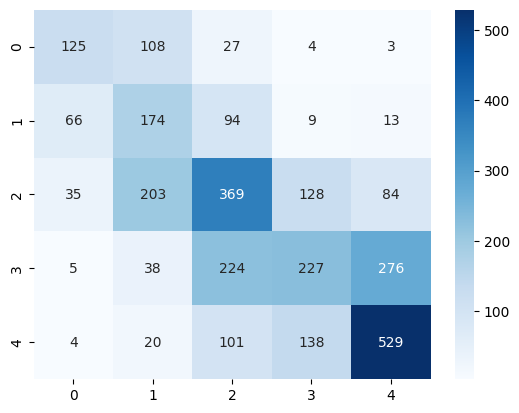

In [171]:
model_bt_14 = TransformerClassifier(312, 5, 2, 8, 128, dropout=0.1)
model_bt_14 = model_training(model_bt_14, 30, 0.001, 32, df_ru_bt, 'bert', 'rating')

## Тестирование на валидационном датасете

In [180]:
test_ru_la = pd.read_csv('/content/drive/MyDrive/cw_classifier/test_ru_LaBASE.csv')
test_ru_bt = pd.read_csv('/content/drive/MyDrive/cw_classifier/test_ru_bert.csv')
test_ru_la['LaBASE'] = test_ru_la['LaBASE'].apply(lambda x: np.fromstring(x[1:-1], sep=','))
test_ru_bt['bert'] = test_ru_bt['bert'].apply(lambda x: np.fromstring(x[2:-2].replace('\n', ' '), sep=' '))

### LaBASE

precision: 0.451, recall: 0.439, F1: 0.425
              precision    recall  f1-score   support

           1       0.46      0.49      0.48       148
           2       0.49      0.15      0.23       245
           3       0.37      0.49      0.42       270
           4       0.38      0.43      0.41       270
           5       0.55      0.64      0.59       270

    accuracy                           0.44      1203
   macro avg       0.45      0.44      0.43      1203
weighted avg       0.45      0.44      0.42      1203



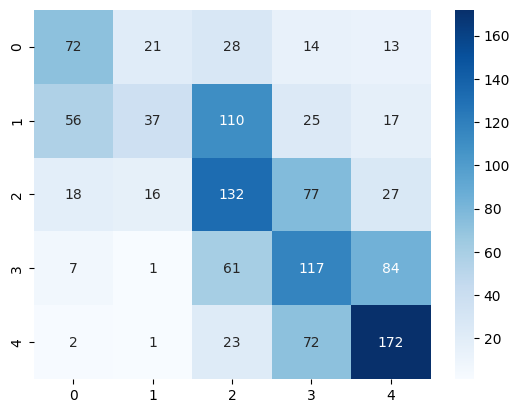

In [181]:
testing(model_la_1, test_ru_la, 'LaBASE', 'rating')

precision: 0.410, recall: 0.401, F1: 0.397
              precision    recall  f1-score   support

           1       0.37      0.45      0.41       148
           2       0.45      0.24      0.32       245
           3       0.33      0.44      0.38       270
           4       0.33      0.34      0.33       270
           5       0.57      0.53      0.55       270

    accuracy                           0.40      1203
   macro avg       0.41      0.40      0.40      1203
weighted avg       0.41      0.40      0.40      1203



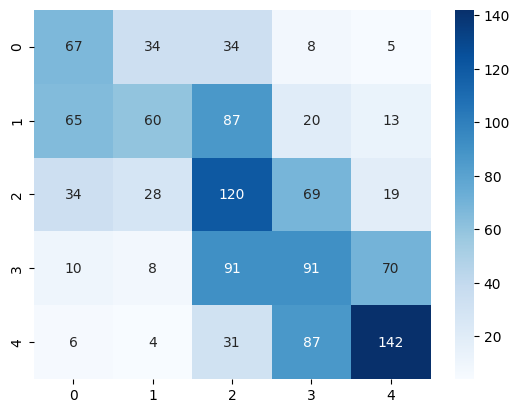

In [182]:
testing(model_la_3, test_ru_la, 'LaBASE', 'rating')

precision: 0.447, recall: 0.430, F1: 0.434
              precision    recall  f1-score   support

           1       0.50      0.34      0.40       148
           2       0.42      0.36      0.39       245
           3       0.35      0.43      0.39       270
           4       0.41      0.39      0.40       270
           5       0.55      0.63      0.59       270

    accuracy                           0.44      1203
   macro avg       0.45      0.43      0.43      1203
weighted avg       0.44      0.44      0.44      1203



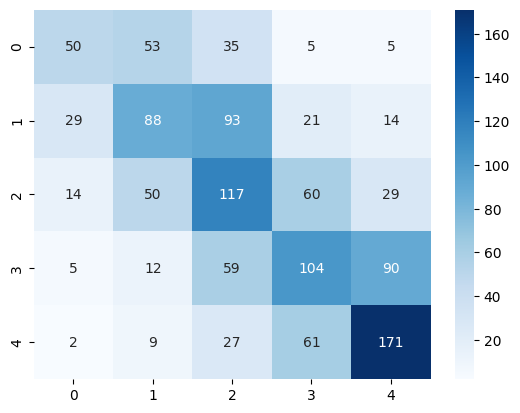

In [183]:
testing(model_la_5, test_ru_la, 'LaBASE', 'rating')

precision: 0.455, recall: 0.429, F1: 0.424
              precision    recall  f1-score   support

           1       0.54      0.41      0.47       148
           2       0.45      0.17      0.24       245
           3       0.34      0.50      0.40       270
           4       0.40      0.44      0.42       270
           5       0.55      0.63      0.59       270

    accuracy                           0.44      1203
   macro avg       0.45      0.43      0.42      1203
weighted avg       0.45      0.44      0.42      1203



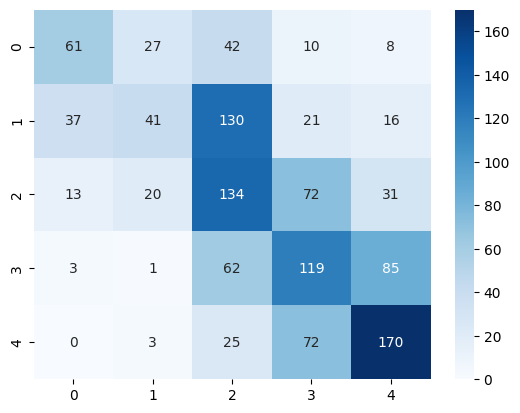

In [184]:
testing(model_la_7, test_ru_la, 'LaBASE', 'rating')

precision: 0.454, recall: 0.445, F1: 0.436
              precision    recall  f1-score   support

           1       0.48      0.49      0.49       148
           2       0.46      0.21      0.29       245
           3       0.35      0.52      0.42       270
           4       0.43      0.37      0.40       270
           5       0.55      0.64      0.59       270

    accuracy                           0.44      1203
   macro avg       0.45      0.44      0.44      1203
weighted avg       0.45      0.44      0.43      1203



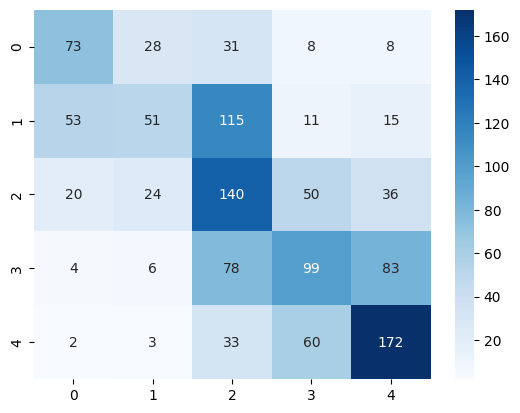

In [185]:
testing(model_la_9, test_ru_la, 'LaBASE', 'rating')

precision: 0.442, recall: 0.427, F1: 0.418
              precision    recall  f1-score   support

           1       0.50      0.45      0.47       148
           2       0.42      0.31      0.36       245
           3       0.34      0.57      0.42       270
           4       0.41      0.19      0.26       270
           5       0.54      0.61      0.58       270

    accuracy                           0.43      1203
   macro avg       0.44      0.43      0.42      1203
weighted avg       0.44      0.43      0.41      1203



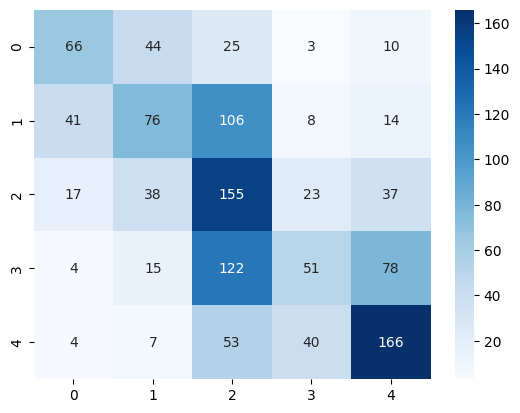

In [186]:
testing(model_la_11, test_ru_la, 'LaBASE', 'rating')

precision: 0.433, recall: 0.407, F1: 0.388
              precision    recall  f1-score   support

           1       0.49      0.38      0.43       148
           2       0.32      0.04      0.08       245
           3       0.31      0.59      0.41       270
           4       0.40      0.44      0.42       270
           5       0.64      0.58      0.61       270

    accuracy                           0.42      1203
   macro avg       0.43      0.41      0.39      1203
weighted avg       0.43      0.42      0.39      1203



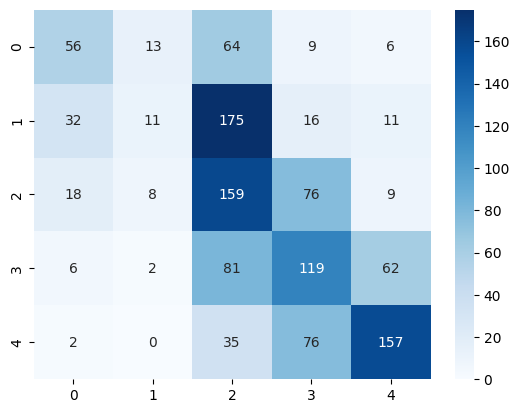

In [187]:
testing(model_la_13, test_ru_la, 'LaBASE', 'rating')

### bert

precision: 0.498, recall: 0.496, F1: 0.487
              precision    recall  f1-score   support

           1       0.52      0.59      0.55       148
           2       0.52      0.27      0.36       245
           3       0.41      0.54      0.47       270
           4       0.42      0.40      0.41       270
           5       0.62      0.68      0.65       270

    accuracy                           0.49      1203
   macro avg       0.50      0.50      0.49      1203
weighted avg       0.50      0.49      0.48      1203



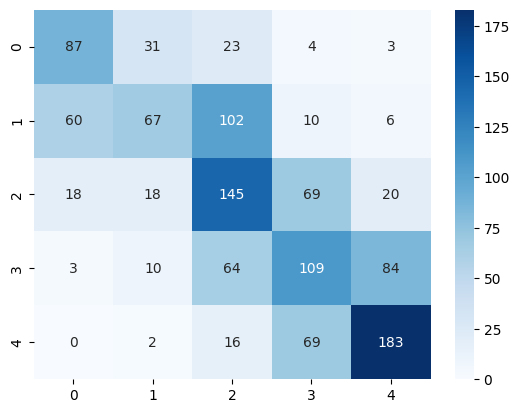

In [188]:
testing(model_bt_2, test_ru_bt, 'bert', 'rating')

precision: 0.497, recall: 0.494, F1: 0.486
              precision    recall  f1-score   support

           1       0.50      0.56      0.53       148
           2       0.55      0.29      0.38       245
           3       0.39      0.50      0.44       270
           4       0.43      0.40      0.42       270
           5       0.62      0.72      0.66       270

    accuracy                           0.49      1203
   macro avg       0.50      0.49      0.49      1203
weighted avg       0.50      0.49      0.48      1203



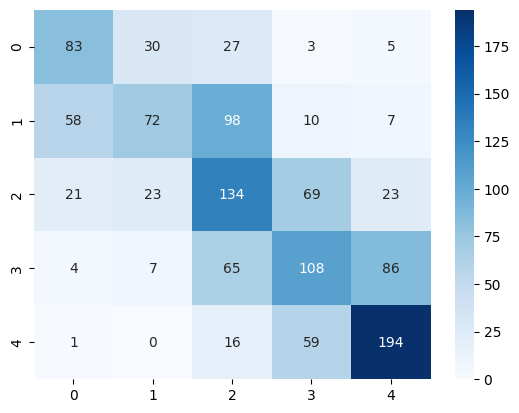

In [189]:
testing(model_bt_4, test_ru_bt, 'bert', 'rating')

precision: 0.479, recall: 0.482, F1: 0.473
              precision    recall  f1-score   support

           1       0.53      0.52      0.53       148
           2       0.45      0.27      0.33       245
           3       0.38      0.37      0.37       270
           4       0.43      0.49      0.46       270
           5       0.60      0.76      0.67       270

    accuracy                           0.48      1203
   macro avg       0.48      0.48      0.47      1203
weighted avg       0.47      0.48      0.47      1203



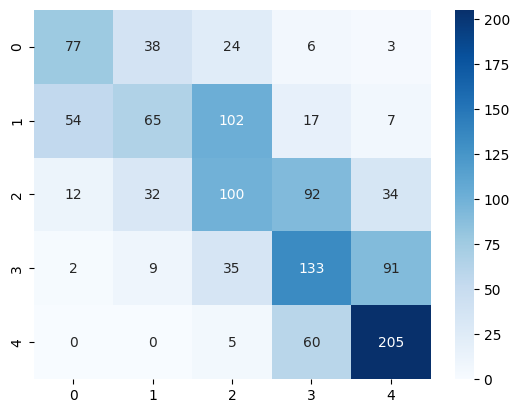

In [190]:
testing(model_bt_6, test_ru_bt, 'bert', 'rating')

precision: 0.499, recall: 0.477, F1: 0.475
              precision    recall  f1-score   support

           1       0.54      0.48      0.51       148
           2       0.49      0.22      0.30       245
           3       0.37      0.51      0.43       270
           4       0.43      0.50      0.46       270
           5       0.67      0.67      0.67       270

    accuracy                           0.48      1203
   macro avg       0.50      0.48      0.47      1203
weighted avg       0.50      0.48      0.47      1203



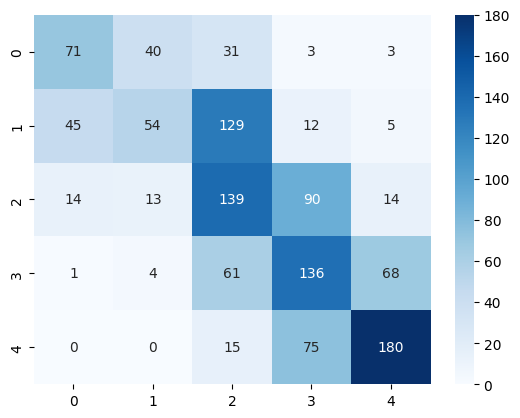

In [191]:
testing(model_bt_8, test_ru_bt, 'bert', 'rating')

precision: 0.499, recall: 0.471, F1: 0.471
              precision    recall  f1-score   support

           1       0.58      0.44      0.50       148
           2       0.52      0.29      0.37       245
           3       0.37      0.57      0.45       270
           4       0.42      0.36      0.39       270
           5       0.60      0.70      0.65       270

    accuracy                           0.48      1203
   macro avg       0.50      0.47      0.47      1203
weighted avg       0.49      0.48      0.47      1203



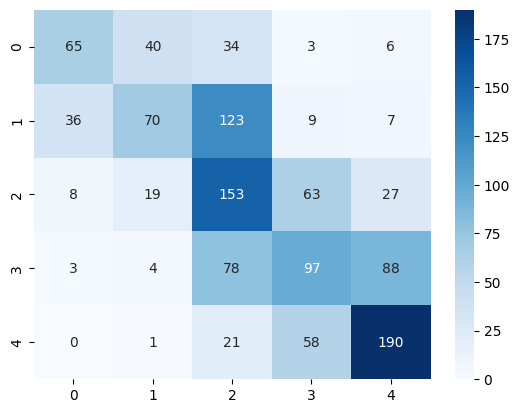

In [192]:
testing(model_bt_10, test_ru_bt, 'bert', 'rating')

precision: 0.501, recall: 0.479, F1: 0.480
              precision    recall  f1-score   support

           1       0.53      0.46      0.49       148
           2       0.49      0.28      0.36       245
           3       0.39      0.56      0.46       270
           4       0.44      0.47      0.45       270
           5       0.66      0.62      0.64       270

    accuracy                           0.48      1203
   macro avg       0.50      0.48      0.48      1203
weighted avg       0.50      0.48      0.48      1203



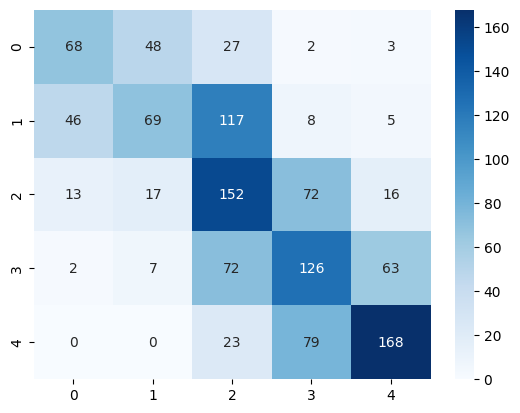

In [193]:
testing(model_bt_12, test_ru_bt, 'bert', 'rating')

precision: 0.479, recall: 0.477, F1: 0.474
              precision    recall  f1-score   support

           1       0.55      0.50      0.52       148
           2       0.47      0.49      0.48       245
           3       0.37      0.43      0.40       270
           4       0.42      0.29      0.35       270
           5       0.58      0.67      0.63       270

    accuracy                           0.47      1203
   macro avg       0.48      0.48      0.47      1203
weighted avg       0.47      0.47      0.47      1203



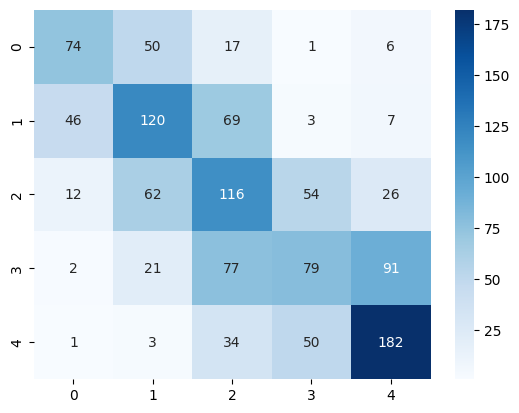

In [194]:
testing(model_bt_14, test_ru_bt, 'bert', 'rating')

# Тестирование критерия ошибки для ранжирования

## Модель

In [145]:
def rank_training(input_model, num_epochs, learning_rate, batch_size, data, embed, target):
    model = input_model
    criterion = nn.MarginRankingLoss(margin=0.1)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Разделяем на тренировочную и валидационную выборки
    train_index = data.sample(int(data.shape[0]*0.8)).index
    val_index = data.index.difference(train_index)

    # Определим датасет и даталоадер для обучения
    embeddings = data.loc[train_index][f'{embed}'].to_list()  # список с эмбеддингами отзывов
    targets = data.loc[train_index][f'{target}'].to_list()  # список с таргетами (классами)
    dataset = MyDataset(embeddings, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Определим датасет и даталоадер для валидации
    val_embeddings = data.loc[val_index][f'{embed}'].to_list()  # список с эмбеддингами отзывов для валидации
    val_targets = data.loc[val_index][f'{target}'].to_list()  # список с таргетами (классами) для валидации
    val_dataset = MyDataset(val_embeddings, val_targets)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Обучение модели
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, batch_data in enumerate(dataloader, 0):
            inputs, labels = batch_data
            labels = labels - 1
            optimizer.zero_grad()
            outputs = model(inputs)
            print(outputs)
            return None
            c = torch.max(outputs, 1).indices
            pairs = torch.combinations(c.view(-1), 2).float()
            pairs.requires_grad = True 
            lst = []
            for i in range(len(labels)):
                for j in range(i, len(labels)):
                    if i != j:
                        if labels[i] >= labels[j]:
                            lst.append(1)
                        else:
                            lst.append(-1)
            labels = torch.tensor(lst)
            loss = criterion(pairs[:, 0], pairs[:, 1], labels.float())
            # loss.requires_grad = True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_history.append(running_loss / i)
        print('[epoch: %d] loss: %.3f' % (epoch + 1, running_loss / i))
        running_loss = 0.0

        # Вычисление метрик на валидационном датасете
        val_running_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for val_data in val_dataloader:
                val_inputs, val_labels = val_data
                val_labels = val_labels - 1
                val_outputs = model(val_inputs)
                c2 = torch.max(val_outputs, 1).indices
                pairs2 = torch.combinations(c2.view(-1), 2)
                lst2 = []
                for i in range(len(val_labels)):
                    for j in range(i, len(val_labels)):
                        if i != j:
                            if val_labels[i] >= val_labels[j]:
                                lst2.append(1)
                            else:
                                lst2.append(-1)
                val_labels1 = torch.tensor(lst2)
                # print()
                val_loss = criterion(pairs2[:, 0], pairs2[:, 1], val_labels1.float())
                val_loss.requires_grad = True
                val_running_loss += val_loss.item()
                val_predictions += list(torch.argmax(val_outputs, dim=1).numpy())
                val_targets += list(val_labels.numpy())
            val_loss_history.append(val_running_loss / len(val_dataloader))
            # print(len(val_targets), len(val_predictions))
        # Вычисление метрик на валидационном датасете
            val_precision = precision_score(val_targets, val_predictions, average='macro', zero_division=True)
            val_recall = recall_score(val_targets, val_predictions, average='macro', zero_division=True)
            val_f1 = f1_score(val_targets, val_predictions, average='macro', zero_division=True)
            print('validation loss: %.3f, validation precision: %.3f, validation recall: %.3f, validation F1: %.3f' % (val_running_loss / len(val_dataloader), val_precision, val_recall, val_f1))

    # Рисуем изменение ошибки
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(num_epochs), train_loss_history, label='train')
    ax.plot(range(num_epochs), val_loss_history, label='val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    # метрики для каждого класса
    print(classification_report((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist(), zero_division=True))
    # матрица ошибок и "попаданий"
    sns.heatmap(confusion_matrix((np.array(val_targets)+1).tolist(), (np.array(val_predictions)+1).tolist()), annot=True, cmap="Blues", fmt="d")
    return model

## Проверка

In [ ]:
rank_1 = ClassifierReLU1(768, 256, 5)
rank_1 = rank_training(rank_1, 20, 0.001, 4, df2_bal, 'LaBASE', 'rating')

In [146]:
rank_2 = LSTM_text(768, 256, 1, 5)
rank_2 = rank_training(rank_2, 1, 0.001, 32, df2_bal, 'LaBASE', 'rating')

tensor([[ 0.0107,  0.0727, -0.0349,  0.0579,  0.0347],
        [ 0.0075,  0.0751, -0.0351,  0.0600,  0.0346],
        [ 0.0119,  0.0814, -0.0241,  0.0583,  0.0429],
        [ 0.0184,  0.0806, -0.0292,  0.0606,  0.0435],
        [ 0.0128,  0.0852, -0.0276,  0.0619,  0.0426],
        [ 0.0067,  0.0795, -0.0295,  0.0641,  0.0339],
        [ 0.0033,  0.0726, -0.0305,  0.0590,  0.0356],
        [ 0.0057,  0.0774, -0.0318,  0.0506,  0.0394],
        [-0.0004,  0.0837, -0.0268,  0.0460,  0.0335],
        [ 0.0004,  0.0809, -0.0333,  0.0552,  0.0378],
        [ 0.0006,  0.0798, -0.0261,  0.0562,  0.0333],
        [ 0.0071,  0.0798, -0.0275,  0.0571,  0.0406],
        [ 0.0107,  0.0808, -0.0295,  0.0577,  0.0422],
        [ 0.0120,  0.0739, -0.0315,  0.0604,  0.0477],
        [ 0.0035,  0.0789, -0.0301,  0.0597,  0.0455],
        [-0.0019,  0.0859, -0.0238,  0.0566,  0.0452],
        [ 0.0006,  0.0866, -0.0326,  0.0604,  0.0463],
        [ 0.0054,  0.0881, -0.0344,  0.0673,  0.0413],
        [ 